In [1]:
from google.colab import drive ; drive.mount('/content/drive')
!pip install gym keras keras-rl2 tensorflow==2.1
import os , sys
import pandas as pd 
from datetime import datetime as dt
import time
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
from numpy import loadtxt
from datetime import datetime
from numpy import savetxt
import random ; from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Flatten 
from tensorflow.keras.optimizers import Adam
from rl.policy import * ; from rl.memory import * ; from rl.agents import *

In [ ]:
#input_shape = ( Memoryin_window_length , ob_space_Length , window )
Memoryin_window_length      = 20
window                      = 360
ob_space_Length             = 5
actions                     = 3
MemoryLimit                 = 200000
#-----------------------------------------------------------
fee                         = 0.0002
SL                          = 0.0020
TP                          = 0.0020
max_nb_trades               = 20
max_nb_steps                = 40

In [ ]:
#os.chdir("/content/drive/MyDrive") 
!ls
name = 'EURUSD.csv'
M1 = pd.read_csv(name, encoding='utf-16',header=None, names=['Date', 'Close'] )
data = M1['Close'].to_numpy()
len(data)

EURUSD.csv  LiveTrading_uv23_4.ipynb  old  WSaved


7601433

In [ ]:
data = data[ 5000000:7000000  ]
len(data)

2000000

In [ ]:
def show(data):  # data is np
  len1 = len(data)
  plt.figure(figsize=(13, 6))
  x = data[:,0]
  y  = np.arange(start=0, stop=len(x) , step=1) 
  plt.plot(  y ,  x    , label="EURUSD Line" )
  plt.plot(  y ,  data[:,1]  , label="SMA5 Line" )
  plt.plot(  y ,  data[:,2]  , label="SMA10 Line" )
  plt.plot(  y ,  data[:,3]  , label="SMA20 Line" )
  plt.plot(  y ,  data[:,4]  , label="SMA50 Line" )
  plt.show()
  
def SMA(Data,Periodes):
    #print(' type : {} '.format(type(Data)))
    n = len(Data)-1 
    res = []
    s2 = Data[0]
    res.append(s2)
    for i in range(1,Periodes+1):
        s2 = s2 + Data[i]
        s2 = round( s2/2 ,5 )
        res.append(s2)
        
    for i in range(Periodes,n):
      iSMA = 0
      for j in range(i - Periodes ,i):
        if(j>=n):
          iSMA = iSMA + Data[n]
        else:
          iSMA = iSMA + Data[j]
      iSMA = iSMA/Periodes  
      res.append(iSMA)
    return np.array(res)  
def get_stats360(substats):
  length = len(substats)
  if (length!=(360+50)):
    print(' get360stats is not 360 + 50 data')
    return 0
  else : 
    stats = np.transpose(  [substats , SMA(substats,5) , SMA(substats,10) , SMA(substats,20) , SMA(substats,49)     ]  )
    stats = stats[50:length]
    max = stats.max() 
    min = stats.min()
    stats =   stats/(max-min) - min/(max-min) 
    return stats

In [ ]:
def build_model( ob_space_Length,window , actions,Memoryin_window_length):
    model = Sequential()
    model.add(Dense(128,activation='relu', input_shape=(Memoryin_window_length,ob_space_Length,window) ) )
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions))
    return model    
def build_agent(model, actions,Memoryin_window_length):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit= MemoryLimit , window_length=Memoryin_window_length)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000 ,
                   gamma=0.95 
                  )
    return dqn  

In [ ]:
modelive = build_model(ob_space_Length, window, actions,Memoryin_window_length)
dqnlive = build_agent(modelive, actions,Memoryin_window_length)
dqnlive.compile( Adam(lr=1e-4))

In [ ]:
class testingenv(Env ):


        return self.state
#-----------------------------------------------------------------

In [ ]:
AllReward = []
Short = []
stats360 = []

jTime= 1
for i in range(1,20):
  max_nb_steps = i
  
  jDATA=data[jTime:(jTime+360+50) ]
  jstats = get_stats360(jDATA) 
  stats360.append( jstats)
  env = testingenv( np.array(Short) , stats360 )
  _ = dqnlive.test(env, nb_episodes=1, visualize=False  )
  action = env.action
  next_data = data[(jTime+360+50):(jTime+360+50+600) ]
  price = jDATA[len(jDATA)-1]
  reward , find_new_index,Short_ = reward_of_stats( price , action , next_data , SL, TP , fee )
  AllReward.append(reward)
  Short.append([Short_,find_new_index])
  jTime+=find_new_index
  #print('r : {} '.format(reward))

In [ ]:
sum(AllReward[0:(len(AllReward)-1)])

-156.00000000000003

# ***8M traning ***

In [ ]:
def reward_of_stats( price , action , next_data , SL, TP , fee ):
  reward = 0     # 0 is action == 2
  find_new_index = 1        # 1 is action == 2
  Short_ = -1
  x = 0
  if(action==0):
    index = 0
    while( index < len(next_data) ):
        newprice = next_data[index]
        if( newprice<= (price-TP) ):
          reward =  TP - fee
          find_new_index = index 
          index = len(next_data) 
          Short_ = 0
          break
        if( newprice>= (price+SL) ):
          reward = -1*SL #- fee
          find_new_index = index 
          index = len(next_data) 
          Short_ = 1
          break
        index +=1 
  #-------------------------------------    
  if(action==1):
    index = 0
    while( index < len(next_data)  ):           
      newprice = next_data[index]
      if( newprice >= (price+TP) ):
        reward =  TP -fee
        find_new_index = index 
        index = len(next_data)
        Short_ = 2
        break
      if( newprice<=(price-SL) ):
        reward = -1*SL #- fee
        find_new_index = index 
        index = len(next_data)
        Short_ = 3
        break
      index +=1 
  if(actions==2):
     reward=0
     Short_=6
     find_new_index = random.randint(2, 15)    
  if(  Short_==-1  ):
    find_new_index = len(next_data)  
    if( action==0 ):
      reward = price - next_data[len(next_data)-1]
      Short_ = 4
    if( action==1 ):
      reward = next_data[len(next_data)-1] - price
      Short_ = 5

  reward = reward*10000  
  find_new_index += random.randint(2, 5) 
  return reward , find_new_index , Short_ 


In [ ]:
class traning_8M(Env ):
    def __init__(self):
         #------------  observation_space  observation_space --------------------------------------------
        global ob_space_Length , window ,max_nb_trades  , TP , SL , fee  , data ,jTime , AllReward , max_nb_steps
        self.observation_space = Box(low= 0.0, high= 1.0, shape=( ob_space_Length ,window), dtype=np.float64 )
        self.action_space = Discrete(2)
        #------------  Parameters --------------------------------------------
        self.iTime_episode=0
        self.action = -1
        self.jDATA = 0
        self.nb_trade = 0
        self.nb_step  = 0
         
    def step(self, action):
        global ob_space_Length , window   , TP , SL , fee  , data ,jTime , max_nb_trades , max_nb_steps
        reward = 0
        self.action = action
        if(action==0 or action==1):
          self.nb_trade+=1
        

        next_data = data[(jTime+360+50-1):(jTime+360+50+700-1) ]
        price = data[(jTime+360+50-1)]
        reward , find_new_index,Short_ = reward_of_stats( price , self.action , next_data , SL, TP , fee )
        #AllReward.append(reward)

        

        jTime+=find_new_index

        info_ = {}
        
        if(  (jTime+2000 )>len(data) ):
          jTime = 2
        self.jDATA = data[jTime:(jTime+360+50) ]
        jstats = get_stats360(self.jDATA) 
        self.state = jstats
        self.state = np.transpose(self.state)

        self.iTime_episode+=1
        done = False
        self.nb_step+=1
        if( self.nb_trade>=max_nb_trades or self.nb_step>=max_nb_steps ):
          done = True
        return self.state, reward, done, info_
    def render(self):
        g=0
    def reset(self):
        global ob_space_Length , window   , TP , SL , fee , max_nb_steps , data ,jTime 
        #print(' jTime :{} '.format(jTime))
        self.nb_trade=0
        self.nb_step  = 0
        if(  (jTime+2000 )>len(data) ):
          jTime = 2
        self.jDATA=data[jTime:(jTime+360+50) ]
        jstats = get_stats360(self.jDATA) 
        self.state = jstats
        self.state = np.transpose(self.state)
        return self.state
#-----------------------------------------------------------------
env_8M = traning_8M(  )

In [ ]:
AllReward = 0
jTime = 1
FileVersion = "WSaved/V12/"
time = datetime.now()
time = time.strftime("%H-%M-%S")
render = 0
steps = 2000000000
Looping = 1
NameSaving = "testing"
for i in range(0,Looping):
  dqnlive.fit( env_8M , nb_steps=steps, visualize=False, verbose=2)
  time_ = datetime.now()
  time_ = time_.strftime("%H-%M-%S")
  NameSaving = FileVersion+time_+'/' +"WSaveddqn_"+str(time_)+".h5f"
  print('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII') 
  print(NameSaving)
  print('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII')
  dqnlive.save_weights(NameSaving, overwrite=True)

Training for 2000000000 steps ...
         28/2000000000: episode: 1, duration: 1.008s, episode steps:  28, steps per second:  28, episode reward: -34.900, mean reward: -1.246 [-20.000, 18.000], mean action: 0.857 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
         53/2000000000: episode: 2, duration: 0.658s, episode steps:  25, steps per second:  38, episode reward: -71.100, mean reward: -2.844 [-20.000, 18.000], mean action: 0.720 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
         81/2000000000: episode: 3, duration: 0.674s, episode steps:  28, steps per second:  42, episode reward: -89.900, mean reward: -3.211 [-20.000, 18.000], mean action: 0.821 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
        110/2000000000: episode: 4, duration: 0.679s, episode steps:  29, steps per second:  43, episode reward: 84.100, mean reward:  2.900 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
        143/2000000000: episode: 5, dur

       1079/2000000000: episode: 36, duration: 3.816s, episode steps:  31, steps per second:   8, episode reward: 56.000, mean reward:  1.806 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 104.668362, mean_q: 0.269531, mean_eps: 0.904330
       1109/2000000000: episode: 37, duration: 3.855s, episode steps:  30, steps per second:   8, episode reward: -134.000, mean reward: -4.467 [-20.000, 18.000], mean action: 0.867 [0.000, 2.000],  loss: 102.263246, mean_q: 0.661261, mean_eps: 0.901585
       1142/2000000000: episode: 38, duration: 4.159s, episode steps:  33, steps per second:   8, episode reward: 94.000, mean reward:  2.848 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 102.962614, mean_q: 0.103977, mean_eps: 0.898750
       1171/2000000000: episode: 39, duration: 3.607s, episode steps:  29, steps per second:   8, episode reward: 56.000, mean reward:  1.931 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 109.218360, mean_q: 0.128110, mean_eps:

       2043/2000000000: episode: 69, duration: 2.806s, episode steps:  23, steps per second:   8, episode reward: -32.800, mean reward: -1.426 [-20.000, 18.000], mean action: 0.609 [0.000, 2.000],  loss: 92.030308, mean_q: 3.530421, mean_eps: 0.817210
       2074/2000000000: episode: 70, duration: 4.000s, episode steps:  31, steps per second:   8, episode reward: -176.000, mean reward: -5.677 [-20.000, 18.000], mean action: 1.161 [0.000, 2.000],  loss: 93.416249, mean_q: 4.674639, mean_eps: 0.814780
       2106/2000000000: episode: 71, duration: 3.978s, episode steps:  32, steps per second:   8, episode reward:  3.800, mean reward:  0.119 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 87.407740, mean_q: 4.735533, mean_eps: 0.811945
       2131/2000000000: episode: 72, duration: 3.242s, episode steps:  25, steps per second:   8, episode reward: -197.900, mean reward: -7.916 [-20.000, 18.000], mean action: 0.760 [0.000, 2.000],  loss: 91.936162, mean_q: 3.012743, mean_eps: 

       3006/2000000000: episode: 102, duration: 3.482s, episode steps:  30, steps per second:   9, episode reward: -143.500, mean reward: -4.783 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 93.710412, mean_q: 3.231948, mean_eps: 0.730855
       3039/2000000000: episode: 103, duration: 3.762s, episode steps:  33, steps per second:   9, episode reward: -90.400, mean reward: -2.739 [-20.000, 18.000], mean action: 1.182 [0.000, 2.000],  loss: 87.175750, mean_q: 4.513366, mean_eps: 0.728020
       3067/2000000000: episode: 104, duration: 2.977s, episode steps:  28, steps per second:   9, episode reward: 33.300, mean reward:  1.189 [-20.000, 18.000], mean action: 1.036 [0.000, 2.000],  loss: 85.516264, mean_q: 2.862664, mean_eps: 0.725275
       3093/2000000000: episode: 105, duration: 2.964s, episode steps:  26, steps per second:   9, episode reward: -51.300, mean reward: -1.973 [-20.000, 18.000], mean action: 0.962 [0.000, 2.000],  loss: 92.034174, mean_q: 4.530453, mean_ep

       4006/2000000000: episode: 135, duration: 3.699s, episode steps:  34, steps per second:   9, episode reward: -76.600, mean reward: -2.253 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 88.827062, mean_q: 3.690927, mean_eps: 0.641035
       4041/2000000000: episode: 136, duration: 4.027s, episode steps:  35, steps per second:   9, episode reward: 38.100, mean reward:  1.089 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 84.902050, mean_q: 3.724181, mean_eps: 0.637930
       4079/2000000000: episode: 137, duration: 5.011s, episode steps:  38, steps per second:   8, episode reward: -58.000, mean reward: -1.526 [-20.000, 18.000], mean action: 1.289 [0.000, 2.000],  loss: 87.769823, mean_q: 3.710875, mean_eps: 0.634645
       4107/2000000000: episode: 138, duration: 4.079s, episode steps:  28, steps per second:   7, episode reward: -20.000, mean reward: -0.714 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 92.145719, mean_q: 4.021432, mean_eps

       5075/2000000000: episode: 168, duration: 3.428s, episode steps:  31, steps per second:   9, episode reward: -108.100, mean reward: -3.487 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 79.705356, mean_q: 4.329818, mean_eps: 0.544690
       5100/2000000000: episode: 169, duration: 2.831s, episode steps:  25, steps per second:   9, episode reward:  9.900, mean reward:  0.396 [-20.000, 18.000], mean action: 0.720 [0.000, 2.000],  loss: 87.783745, mean_q: 4.140422, mean_eps: 0.542170
       5125/2000000000: episode: 170, duration: 3.000s, episode steps:  25, steps per second:   8, episode reward: -17.400, mean reward: -0.696 [-20.000, 18.000], mean action: 0.880 [0.000, 2.000],  loss: 81.683816, mean_q: 3.621598, mean_eps: 0.539920
       5159/2000000000: episode: 171, duration: 3.810s, episode steps:  34, steps per second:   9, episode reward: -81.600, mean reward: -2.400 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 85.672601, mean_q: 3.844288, mean_ep

       6123/2000000000: episode: 201, duration: 4.450s, episode steps:  35, steps per second:   8, episode reward: -147.800, mean reward: -4.223 [-20.000, 18.000], mean action: 1.029 [0.000, 2.000],  loss: 81.038420, mean_q: 2.546298, mean_eps: 0.450550
       6153/2000000000: episode: 202, duration: 3.800s, episode steps:  30, steps per second:   8, episode reward: 47.500, mean reward:  1.583 [-20.000, 18.000], mean action: 0.967 [0.000, 2.000],  loss: 80.322287, mean_q: 3.674027, mean_eps: 0.447625
       6185/2000000000: episode: 203, duration: 4.104s, episode steps:  32, steps per second:   8, episode reward: 82.100, mean reward:  2.566 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 79.607501, mean_q: 3.089345, mean_eps: 0.444835
       6214/2000000000: episode: 204, duration: 3.503s, episode steps:  29, steps per second:   8, episode reward: -20.000, mean reward: -0.690 [-20.000, 18.000], mean action: 1.172 [0.000, 2.000],  loss: 85.363644, mean_q: 3.601671, mean_eps

       7226/2000000000: episode: 234, duration: 4.115s, episode steps:  31, steps per second:   8, episode reward: 44.300, mean reward:  1.429 [-20.000, 18.000], mean action: 1.097 [0.000, 2.000],  loss: 78.522979, mean_q: 3.818050, mean_eps: 0.351100
       7266/2000000000: episode: 235, duration: 5.059s, episode steps:  40, steps per second:   8, episode reward: -148.700, mean reward: -3.718 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 84.486154, mean_q: 3.177444, mean_eps: 0.347905
       7306/2000000000: episode: 236, duration: 4.896s, episode steps:  40, steps per second:   8, episode reward: 38.000, mean reward:  0.950 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 84.058431, mean_q: 2.959939, mean_eps: 0.344305
       7337/2000000000: episode: 237, duration: 3.926s, episode steps:  31, steps per second:   8, episode reward: -129.200, mean reward: -4.168 [-20.000, 18.000], mean action: 0.968 [0.000, 2.000],  loss: 81.270616, mean_q: 2.647910, mean_ep

       8338/2000000000: episode: 267, duration: 3.755s, episode steps:  32, steps per second:   9, episode reward: -124.500, mean reward: -3.891 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 81.049585, mean_q: 4.157168, mean_eps: 0.251065
       8372/2000000000: episode: 268, duration: 4.192s, episode steps:  34, steps per second:   8, episode reward: 48.800, mean reward:  1.435 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 79.577519, mean_q: 3.546667, mean_eps: 0.248095
       8400/2000000000: episode: 269, duration: 3.489s, episode steps:  28, steps per second:   8, episode reward: -57.700, mean reward: -2.061 [-20.000, 18.000], mean action: 0.964 [0.000, 2.000],  loss: 83.543767, mean_q: 3.604106, mean_eps: 0.245305
       8440/2000000000: episode: 270, duration: 5.201s, episode steps:  40, steps per second:   8, episode reward: -72.000, mean reward: -1.800 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 78.368677, mean_q: 4.268948, mean_ep

       9495/2000000000: episode: 300, duration: 4.265s, episode steps:  35, steps per second:   8, episode reward: -4.600, mean reward: -0.131 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 75.005914, mean_q: 3.339083, mean_eps: 0.147070
       9527/2000000000: episode: 301, duration: 3.971s, episode steps:  32, steps per second:   8, episode reward: -8.600, mean reward: -0.269 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 76.890741, mean_q: 3.379095, mean_eps: 0.144055
       9567/2000000000: episode: 302, duration: 4.573s, episode steps:  40, steps per second:   9, episode reward: -147.400, mean reward: -3.685 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 77.961345, mean_q: 3.622057, mean_eps: 0.140815
       9605/2000000000: episode: 303, duration: 4.431s, episode steps:  38, steps per second:   9, episode reward: -31.100, mean reward: -0.818 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 78.380732, mean_q: 3.609905, mean_eps

      10608/2000000000: episode: 333, duration: 3.453s, episode steps:  30, steps per second:   9, episode reward: -162.100, mean reward: -5.403 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 79.743809, mean_q: 6.917861, mean_eps: 0.100000
      10639/2000000000: episode: 334, duration: 3.539s, episode steps:  31, steps per second:   9, episode reward: -20.000, mean reward: -0.645 [-20.000, 18.000], mean action: 0.935 [0.000, 2.000],  loss: 81.257183, mean_q: 6.443578, mean_eps: 0.100000
      10675/2000000000: episode: 335, duration: 4.087s, episode steps:  36, steps per second:   9, episode reward: -58.000, mean reward: -1.611 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 84.837684, mean_q: 6.830237, mean_eps: 0.100000
      10715/2000000000: episode: 336, duration: 4.492s, episode steps:  40, steps per second:   9, episode reward: -75.300, mean reward: -1.882 [-20.000, 18.700], mean action: 1.350 [0.000, 2.000],  loss: 81.577652, mean_q: 5.846953, mean_e

      11798/2000000000: episode: 366, duration: 4.119s, episode steps:  34, steps per second:   8, episode reward: 94.000, mean reward:  2.765 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 80.624576, mean_q: 7.873799, mean_eps: 0.100000
      11836/2000000000: episode: 367, duration: 4.793s, episode steps:  38, steps per second:   8, episode reward: -9.300, mean reward: -0.245 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 81.673033, mean_q: 6.669703, mean_eps: 0.100000
      11876/2000000000: episode: 368, duration: 4.655s, episode steps:  40, steps per second:   9, episode reward: 18.000, mean reward:  0.450 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 81.270120, mean_q: 6.580284, mean_eps: 0.100000
      11909/2000000000: episode: 369, duration: 4.294s, episode steps:  33, steps per second:   8, episode reward: -69.700, mean reward: -2.112 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 80.937062, mean_q: 7.324973, mean_eps: 

      12986/2000000000: episode: 399, duration: 3.476s, episode steps:  28, steps per second:   8, episode reward: -58.000, mean reward: -2.071 [-20.000, 18.000], mean action: 0.964 [0.000, 2.000],  loss: 77.776628, mean_q: 6.510135, mean_eps: 0.100000
      13020/2000000000: episode: 400, duration: 3.775s, episode steps:  34, steps per second:   9, episode reward: -63.000, mean reward: -1.853 [-20.000, 18.000], mean action: 1.088 [0.000, 2.000],  loss: 76.559227, mean_q: 6.691649, mean_eps: 0.100000
      13060/2000000000: episode: 401, duration: 4.535s, episode steps:  40, steps per second:   9, episode reward: 12.600, mean reward:  0.315 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 74.374527, mean_q: 6.533164, mean_eps: 0.100000
      13092/2000000000: episode: 402, duration: 3.795s, episode steps:  32, steps per second:   8, episode reward: -100.800, mean reward: -3.150 [-20.000, 18.000], mean action: 1.188 [0.000, 2.000],  loss: 75.533724, mean_q: 6.284727, mean_ep

      14227/2000000000: episode: 432, duration: 4.775s, episode steps:  36, steps per second:   8, episode reward: -160.300, mean reward: -4.453 [-20.000, 19.900], mean action: 1.222 [0.000, 2.000],  loss: 72.397451, mean_q: 6.348955, mean_eps: 0.100000
      14264/2000000000: episode: 433, duration: 5.002s, episode steps:  37, steps per second:   7, episode reward: -20.000, mean reward: -0.541 [-20.000, 18.000], mean action: 1.216 [0.000, 2.000],  loss: 68.772732, mean_q: 6.576081, mean_eps: 0.100000
      14297/2000000000: episode: 434, duration: 3.814s, episode steps:  33, steps per second:   9, episode reward: 18.000, mean reward:  0.545 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 79.484925, mean_q: 6.641076, mean_eps: 0.100000
      14335/2000000000: episode: 435, duration: 4.583s, episode steps:  38, steps per second:   8, episode reward: -58.000, mean reward: -1.526 [-20.000, 18.000], mean action: 1.289 [0.000, 2.000],  loss: 75.172177, mean_q: 6.148938, mean_ep

      15466/2000000000: episode: 465, duration: 4.753s, episode steps:  38, steps per second:   8, episode reward: -167.000, mean reward: -4.395 [-20.000, 18.000], mean action: 1.237 [0.000, 2.000],  loss: 66.960014, mean_q: 6.490880, mean_eps: 0.100000
      15506/2000000000: episode: 466, duration: 4.727s, episode steps:  40, steps per second:   8, episode reward: -37.500, mean reward: -0.938 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 78.824507, mean_q: 6.287747, mean_eps: 0.100000
      15546/2000000000: episode: 467, duration: 4.709s, episode steps:  40, steps per second:   8, episode reward: -50.200, mean reward: -1.255 [-20.000, 18.000], mean action: 1.175 [0.000, 2.000],  loss: 68.151543, mean_q: 6.234299, mean_eps: 0.100000
      15581/2000000000: episode: 468, duration: 4.225s, episode steps:  35, steps per second:   8, episode reward: -88.300, mean reward: -2.523 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 70.052867, mean_q: 6.963911, mean_e

      16663/2000000000: episode: 498, duration: 3.956s, episode steps:  33, steps per second:   8, episode reward: -20.000, mean reward: -0.606 [-20.000, 18.000], mean action: 1.091 [0.000, 2.000],  loss: 71.836058, mean_q: 6.713966, mean_eps: 0.100000
      16702/2000000000: episode: 499, duration: 4.462s, episode steps:  39, steps per second:   9, episode reward: 94.000, mean reward:  2.410 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 74.563281, mean_q: 6.248679, mean_eps: 0.100000
      16742/2000000000: episode: 500, duration: 4.496s, episode steps:  40, steps per second:   9, episode reward:  8.800, mean reward:  0.220 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 72.098630, mean_q: 6.319144, mean_eps: 0.100000
      16773/2000000000: episode: 501, duration: 3.592s, episode steps:  31, steps per second:   9, episode reward: 59.000, mean reward:  1.903 [-20.000, 18.000], mean action: 1.097 [0.000, 2.000],  loss: 74.145210, mean_q: 6.257444, mean_eps: 

      17928/2000000000: episode: 531, duration: 4.646s, episode steps:  40, steps per second:   9, episode reward: 64.400, mean reward:  1.610 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 70.601736, mean_q: 7.083248, mean_eps: 0.100000
      17968/2000000000: episode: 532, duration: 4.399s, episode steps:  40, steps per second:   9, episode reward: 36.600, mean reward:  0.915 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 72.839709, mean_q: 6.067293, mean_eps: 0.100000
      18008/2000000000: episode: 533, duration: 4.831s, episode steps:  40, steps per second:   8, episode reward: -28.600, mean reward: -0.715 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 73.519817, mean_q: 6.186972, mean_eps: 0.100000
      18047/2000000000: episode: 534, duration: 4.890s, episode steps:  39, steps per second:   8, episode reward:  6.800, mean reward:  0.174 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 69.328706, mean_q: 6.046602, mean_eps: 

      19181/2000000000: episode: 564, duration: 4.604s, episode steps:  40, steps per second:   9, episode reward: 15.900, mean reward:  0.397 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 67.230854, mean_q: 6.118241, mean_eps: 0.100000
      19220/2000000000: episode: 565, duration: 4.547s, episode steps:  39, steps per second:   9, episode reward: 39.200, mean reward:  1.005 [-20.000, 18.000], mean action: 1.308 [0.000, 2.000],  loss: 69.334790, mean_q: 6.315403, mean_eps: 0.100000
      19260/2000000000: episode: 566, duration: 4.551s, episode steps:  40, steps per second:   9, episode reward: -105.000, mean reward: -2.625 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 75.244049, mean_q: 5.740463, mean_eps: 0.100000
      19293/2000000000: episode: 567, duration: 3.786s, episode steps:  33, steps per second:   9, episode reward:  4.300, mean reward:  0.130 [-20.000, 18.000], mean action: 1.030 [0.000, 2.000],  loss: 66.383389, mean_q: 6.097363, mean_eps:

      20434/2000000000: episode: 597, duration: 4.367s, episode steps:  36, steps per second:   8, episode reward:  5.600, mean reward:  0.156 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 74.971581, mean_q: 8.917518, mean_eps: 0.100000
      20472/2000000000: episode: 598, duration: 4.887s, episode steps:  38, steps per second:   8, episode reward: -15.000, mean reward: -0.395 [-20.000, 18.000], mean action: 1.237 [0.000, 2.000],  loss: 74.389808, mean_q: 8.620903, mean_eps: 0.100000
      20508/2000000000: episode: 599, duration: 4.290s, episode steps:  36, steps per second:   8, episode reward: -45.800, mean reward: -1.272 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 73.073507, mean_q: 8.868523, mean_eps: 0.100000
      20541/2000000000: episode: 600, duration: 3.970s, episode steps:  33, steps per second:   8, episode reward: -105.100, mean reward: -3.185 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 69.033803, mean_q: 8.254366, mean_ep

      21684/2000000000: episode: 630, duration: 4.553s, episode steps:  39, steps per second:   9, episode reward: 49.400, mean reward:  1.267 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 75.541585, mean_q: 8.415297, mean_eps: 0.100000
      21724/2000000000: episode: 631, duration: 4.831s, episode steps:  40, steps per second:   8, episode reward: 48.300, mean reward:  1.208 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 69.377618, mean_q: 8.912179, mean_eps: 0.100000
      21751/2000000000: episode: 632, duration: 3.437s, episode steps:  27, steps per second:   8, episode reward: 42.300, mean reward:  1.567 [-20.000, 18.000], mean action: 0.889 [0.000, 2.000],  loss: 67.264329, mean_q: 8.697121, mean_eps: 0.100000
      21791/2000000000: episode: 633, duration: 4.966s, episode steps:  40, steps per second:   8, episode reward: -29.600, mean reward: -0.740 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 72.254950, mean_q: 8.237008, mean_eps: 

      22931/2000000000: episode: 663, duration: 5.429s, episode steps:  40, steps per second:   7, episode reward: 152.000, mean reward:  3.800 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 70.221758, mean_q: 7.963668, mean_eps: 0.100000
      22967/2000000000: episode: 664, duration: 4.726s, episode steps:  36, steps per second:   8, episode reward: -118.400, mean reward: -3.289 [-20.000, 18.000], mean action: 1.083 [0.000, 2.000],  loss: 62.113836, mean_q: 8.516223, mean_eps: 0.100000
      23007/2000000000: episode: 665, duration: 4.989s, episode steps:  40, steps per second:   8, episode reward:  4.400, mean reward:  0.110 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 67.868490, mean_q: 8.410114, mean_eps: 0.100000
      23035/2000000000: episode: 666, duration: 3.660s, episode steps:  28, steps per second:   8, episode reward: 132.000, mean reward:  4.714 [-20.000, 18.000], mean action: 0.964 [0.000, 2.000],  loss: 59.702557, mean_q: 8.536950, mean_ep

      24173/2000000000: episode: 696, duration: 5.383s, episode steps:  40, steps per second:   7, episode reward: 11.800, mean reward:  0.295 [-20.000, 18.000], mean action: 1.550 [0.000, 2.000],  loss: 66.280361, mean_q: 8.363116, mean_eps: 0.100000
      24213/2000000000: episode: 697, duration: 5.356s, episode steps:  40, steps per second:   7, episode reward: 37.000, mean reward:  0.925 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 71.838858, mean_q: 8.094694, mean_eps: 0.100000
      24246/2000000000: episode: 698, duration: 4.587s, episode steps:  33, steps per second:   7, episode reward: -20.000, mean reward: -0.606 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 62.533291, mean_q: 9.033125, mean_eps: 0.100000
      24286/2000000000: episode: 699, duration: 5.670s, episode steps:  40, steps per second:   7, episode reward: -158.800, mean reward: -3.970 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 65.040985, mean_q: 8.571621, mean_eps

      25454/2000000000: episode: 729, duration: 5.317s, episode steps:  40, steps per second:   8, episode reward: -14.900, mean reward: -0.373 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 61.575082, mean_q: 8.932411, mean_eps: 0.100000
      25494/2000000000: episode: 730, duration: 5.670s, episode steps:  40, steps per second:   7, episode reward: 13.700, mean reward:  0.343 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 62.475401, mean_q: 8.425245, mean_eps: 0.100000
      25534/2000000000: episode: 731, duration: 5.464s, episode steps:  40, steps per second:   7, episode reward: -35.600, mean reward: -0.890 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 68.466562, mean_q: 8.328815, mean_eps: 0.100000
      25574/2000000000: episode: 732, duration: 5.508s, episode steps:  40, steps per second:   7, episode reward: -75.900, mean reward: -1.897 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 64.916147, mean_q: 8.348135, mean_eps

      26733/2000000000: episode: 762, duration: 5.221s, episode steps:  40, steps per second:   8, episode reward: -64.200, mean reward: -1.605 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 66.479261, mean_q: 8.325316, mean_eps: 0.100000
      26768/2000000000: episode: 763, duration: 4.805s, episode steps:  35, steps per second:   7, episode reward: 94.000, mean reward:  2.686 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 69.477794, mean_q: 8.849327, mean_eps: 0.100000
      26804/2000000000: episode: 764, duration: 5.194s, episode steps:  36, steps per second:   7, episode reward: 18.000, mean reward:  0.500 [-20.000, 18.000], mean action: 1.167 [0.000, 2.000],  loss: 69.174977, mean_q: 7.869831, mean_eps: 0.100000
      26837/2000000000: episode: 765, duration: 4.315s, episode steps:  33, steps per second:   8, episode reward: -86.600, mean reward: -2.624 [-20.000, 18.000], mean action: 1.091 [0.000, 2.000],  loss: 64.044930, mean_q: 8.535974, mean_eps:

      27997/2000000000: episode: 795, duration: 5.225s, episode steps:  39, steps per second:   7, episode reward: -49.800, mean reward: -1.277 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 63.083879, mean_q: 8.665232, mean_eps: 0.100000
      28036/2000000000: episode: 796, duration: 5.216s, episode steps:  39, steps per second:   7, episode reward: -128.600, mean reward: -3.297 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 62.878978, mean_q: 8.574161, mean_eps: 0.100000
      28076/2000000000: episode: 797, duration: 5.346s, episode steps:  40, steps per second:   7, episode reward: -29.900, mean reward: -0.747 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 60.794261, mean_q: 8.264672, mean_eps: 0.100000
      28110/2000000000: episode: 798, duration: 4.577s, episode steps:  34, steps per second:   7, episode reward: -143.200, mean reward: -4.212 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 62.655604, mean_q: 7.950474, mean_

      29263/2000000000: episode: 828, duration: 4.234s, episode steps:  32, steps per second:   8, episode reward: -39.200, mean reward: -1.225 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 64.173315, mean_q: 8.591198, mean_eps: 0.100000
      29303/2000000000: episode: 829, duration: 5.274s, episode steps:  40, steps per second:   8, episode reward: -19.400, mean reward: -0.485 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 62.654076, mean_q: 8.685927, mean_eps: 0.100000
      29339/2000000000: episode: 830, duration: 4.862s, episode steps:  36, steps per second:   7, episode reward: 37.300, mean reward:  1.036 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 66.728426, mean_q: 8.205326, mean_eps: 0.100000
      29379/2000000000: episode: 831, duration: 5.266s, episode steps:  40, steps per second:   8, episode reward: 81.600, mean reward:  2.040 [-11.400, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 66.884655, mean_q: 8.277436, mean_eps:

      30509/2000000000: episode: 861, duration: 4.744s, episode steps:  40, steps per second:   8, episode reward:  4.000, mean reward:  0.100 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 71.581686, mean_q: 11.823887, mean_eps: 0.100000
      30549/2000000000: episode: 862, duration: 4.769s, episode steps:  40, steps per second:   8, episode reward: 64.900, mean reward:  1.623 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 74.902787, mean_q: 11.640695, mean_eps: 0.100000
      30589/2000000000: episode: 863, duration: 4.706s, episode steps:  40, steps per second:   8, episode reward: -36.000, mean reward: -0.900 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 65.687862, mean_q: 11.452506, mean_eps: 0.100000
      30629/2000000000: episode: 864, duration: 4.567s, episode steps:  40, steps per second:   9, episode reward: -21.900, mean reward: -0.548 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 68.808590, mean_q: 11.618478, mean_

      31768/2000000000: episode: 894, duration: 4.805s, episode steps:  35, steps per second:   7, episode reward: -37.100, mean reward: -1.060 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 71.012559, mean_q: 11.977555, mean_eps: 0.100000
      31806/2000000000: episode: 895, duration: 5.286s, episode steps:  38, steps per second:   7, episode reward: 65.300, mean reward:  1.718 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 72.210487, mean_q: 11.854925, mean_eps: 0.100000
      31841/2000000000: episode: 896, duration: 4.833s, episode steps:  35, steps per second:   7, episode reward: -186.700, mean reward: -5.334 [-20.000, 19.400], mean action: 1.143 [0.000, 2.000],  loss: 67.846952, mean_q: 11.265210, mean_eps: 0.100000
      31873/2000000000: episode: 897, duration: 4.068s, episode steps:  32, steps per second:   8, episode reward: -101.200, mean reward: -3.162 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 67.227555, mean_q: 12.075488, me

      33039/2000000000: episode: 927, duration: 5.059s, episode steps:  40, steps per second:   8, episode reward: 63.000, mean reward:  1.575 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 68.872647, mean_q: 12.379322, mean_eps: 0.100000
      33079/2000000000: episode: 928, duration: 5.257s, episode steps:  40, steps per second:   8, episode reward: -35.000, mean reward: -0.875 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 67.352842, mean_q: 11.452358, mean_eps: 0.100000
      33119/2000000000: episode: 929, duration: 5.041s, episode steps:  40, steps per second:   8, episode reward: -0.900, mean reward: -0.023 [-20.000, 18.000], mean action: 1.575 [0.000, 2.000],  loss: 70.832533, mean_q: 11.170558, mean_eps: 0.100000
      33150/2000000000: episode: 930, duration: 4.137s, episode steps:  31, steps per second:   7, episode reward: 83.000, mean reward:  2.677 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 70.017685, mean_q: 12.070335, mean_e

      34319/2000000000: episode: 960, duration: 5.348s, episode steps:  40, steps per second:   7, episode reward: -83.400, mean reward: -2.085 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 68.417008, mean_q: 11.602551, mean_eps: 0.100000
      34359/2000000000: episode: 961, duration: 5.164s, episode steps:  40, steps per second:   8, episode reward: -30.000, mean reward: -0.750 [-20.000, 18.000], mean action: 1.600 [0.000, 2.000],  loss: 61.178404, mean_q: 12.047023, mean_eps: 0.100000
      34395/2000000000: episode: 962, duration: 4.459s, episode steps:  36, steps per second:   8, episode reward: 56.000, mean reward:  1.556 [-20.000, 18.000], mean action: 1.028 [0.000, 2.000],  loss: 60.142586, mean_q: 10.677359, mean_eps: 0.100000
      34435/2000000000: episode: 963, duration: 5.208s, episode steps:  40, steps per second:   8, episode reward: -161.800, mean reward: -4.045 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 71.505193, mean_q: 11.466934, mea

      35604/2000000000: episode: 993, duration: 5.235s, episode steps:  40, steps per second:   8, episode reward: -75.900, mean reward: -1.897 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 64.848670, mean_q: 12.248146, mean_eps: 0.100000
      35644/2000000000: episode: 994, duration: 5.251s, episode steps:  40, steps per second:   8, episode reward: -31.000, mean reward: -0.775 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 68.340800, mean_q: 11.328294, mean_eps: 0.100000
      35681/2000000000: episode: 995, duration: 4.841s, episode steps:  37, steps per second:   8, episode reward: -108.800, mean reward: -2.941 [-20.000, 18.000], mean action: 1.270 [0.000, 2.000],  loss: 66.493531, mean_q: 11.747766, mean_eps: 0.100000
      35721/2000000000: episode: 996, duration: 5.428s, episode steps:  40, steps per second:   7, episode reward: 117.300, mean reward:  2.932 [-20.000, 18.400], mean action: 1.175 [0.000, 2.000],  loss: 73.939467, mean_q: 11.406118, me

      36871/2000000000: episode: 1026, duration: 4.936s, episode steps:  40, steps per second:   8, episode reward: 24.000, mean reward:  0.600 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 69.639686, mean_q: 12.005996, mean_eps: 0.100000
      36911/2000000000: episode: 1027, duration: 4.962s, episode steps:  40, steps per second:   8, episode reward: 31.200, mean reward:  0.780 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 61.781671, mean_q: 11.115309, mean_eps: 0.100000
      36951/2000000000: episode: 1028, duration: 5.195s, episode steps:  40, steps per second:   8, episode reward: -27.700, mean reward: -0.693 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 67.973564, mean_q: 11.855868, mean_eps: 0.100000
      36990/2000000000: episode: 1029, duration: 5.126s, episode steps:  39, steps per second:   8, episode reward: -34.500, mean reward: -0.885 [-20.000, 18.000], mean action: 1.179 [0.000, 2.000],  loss: 68.122628, mean_q: 11.657332, m

      38159/2000000000: episode: 1059, duration: 4.727s, episode steps:  40, steps per second:   8, episode reward: 62.000, mean reward:  1.550 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 66.984374, mean_q: 10.827933, mean_eps: 0.100000
      38192/2000000000: episode: 1060, duration: 3.924s, episode steps:  33, steps per second:   8, episode reward: -20.000, mean reward: -0.606 [-20.000, 18.000], mean action: 1.091 [0.000, 2.000],  loss: 59.600666, mean_q: 11.909001, mean_eps: 0.100000
      38232/2000000000: episode: 1061, duration: 4.861s, episode steps:  40, steps per second:   8, episode reward: 22.900, mean reward:  0.572 [-20.000, 18.000], mean action: 1.575 [0.000, 2.000],  loss: 62.406016, mean_q: 11.163791, mean_eps: 0.100000
      38271/2000000000: episode: 1062, duration: 4.584s, episode steps:  39, steps per second:   9, episode reward: 18.000, mean reward:  0.462 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 63.669978, mean_q: 11.099952, me

      39422/2000000000: episode: 1092, duration: 4.735s, episode steps:  40, steps per second:   8, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 63.759601, mean_q: 11.577328, mean_eps: 0.100000
      39462/2000000000: episode: 1093, duration: 4.961s, episode steps:  40, steps per second:   8, episode reward: 60.000, mean reward:  1.500 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 65.036141, mean_q: 11.609548, mean_eps: 0.100000
      39502/2000000000: episode: 1094, duration: 4.890s, episode steps:  40, steps per second:   8, episode reward: -28.300, mean reward: -0.708 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 66.443494, mean_q: 11.192682, mean_eps: 0.100000
      39542/2000000000: episode: 1095, duration: 5.057s, episode steps:  40, steps per second:   8, episode reward: 66.000, mean reward:  1.650 [-20.000, 18.000], mean action: 1.600 [0.000, 2.000],  loss: 61.844141, mean_q: 11.326738, m

      40710/2000000000: episode: 1125, duration: 4.376s, episode steps:  36, steps per second:   8, episode reward: 48.700, mean reward:  1.353 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 70.698372, mean_q: 13.004827, mean_eps: 0.100000
      40750/2000000000: episode: 1126, duration: 5.106s, episode steps:  40, steps per second:   8, episode reward: -13.900, mean reward: -0.347 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 72.872110, mean_q: 12.678926, mean_eps: 0.100000
      40790/2000000000: episode: 1127, duration: 5.225s, episode steps:  40, steps per second:   8, episode reward:  2.300, mean reward:  0.058 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 71.239120, mean_q: 13.097220, mean_eps: 0.100000
      40830/2000000000: episode: 1128, duration: 4.723s, episode steps:  40, steps per second:   8, episode reward: 14.900, mean reward:  0.373 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 64.068854, mean_q: 13.241497, me

      41940/2000000000: episode: 1158, duration: 4.962s, episode steps:  40, steps per second:   8, episode reward: -35.800, mean reward: -0.895 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 69.639824, mean_q: 13.181332, mean_eps: 0.100000
      41980/2000000000: episode: 1159, duration: 4.804s, episode steps:  40, steps per second:   8, episode reward: 76.000, mean reward:  1.900 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 66.137648, mean_q: 12.844297, mean_eps: 0.100000
      42018/2000000000: episode: 1160, duration: 4.933s, episode steps:  38, steps per second:   8, episode reward: 264.200, mean reward:  6.953 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 68.603538, mean_q: 13.133892, mean_eps: 0.100000
      42058/2000000000: episode: 1161, duration: 4.967s, episode steps:  40, steps per second:   8, episode reward: -54.000, mean reward: -1.350 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 61.275707, mean_q: 12.893897, 

      43198/2000000000: episode: 1191, duration: 4.656s, episode steps:  40, steps per second:   9, episode reward: 27.400, mean reward:  0.685 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 66.287386, mean_q: 12.797218, mean_eps: 0.100000
      43238/2000000000: episode: 1192, duration: 4.950s, episode steps:  40, steps per second:   8, episode reward: 99.500, mean reward:  2.487 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 62.251287, mean_q: 12.805773, mean_eps: 0.100000
      43271/2000000000: episode: 1193, duration: 3.968s, episode steps:  33, steps per second:   8, episode reward: -50.100, mean reward: -1.518 [-20.000, 18.000], mean action: 1.182 [0.000, 2.000],  loss: 65.493658, mean_q: 13.401594, mean_eps: 0.100000
      43305/2000000000: episode: 1194, duration: 4.156s, episode steps:  34, steps per second:   8, episode reward: -103.800, mean reward: -3.053 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 64.542503, mean_q: 13.206414, 

      44452/2000000000: episode: 1224, duration: 4.391s, episode steps:  36, steps per second:   8, episode reward: 34.200, mean reward:  0.950 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 64.366731, mean_q: 12.526249, mean_eps: 0.100000
      44492/2000000000: episode: 1225, duration: 4.251s, episode steps:  40, steps per second:   9, episode reward: 58.000, mean reward:  1.450 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 69.268696, mean_q: 12.344157, mean_eps: 0.100000
      44532/2000000000: episode: 1226, duration: 4.338s, episode steps:  40, steps per second:   9, episode reward: 107.400, mean reward:  2.685 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 62.603834, mean_q: 12.751988, mean_eps: 0.100000
      44572/2000000000: episode: 1227, duration: 4.513s, episode steps:  40, steps per second:   9, episode reward: 42.600, mean reward:  1.065 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 68.913168, mean_q: 12.724718, me

      45713/2000000000: episode: 1257, duration: 4.616s, episode steps:  40, steps per second:   9, episode reward: -23.300, mean reward: -0.582 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 60.772927, mean_q: 12.951222, mean_eps: 0.100000
      45749/2000000000: episode: 1258, duration: 4.342s, episode steps:  36, steps per second:   8, episode reward: 16.900, mean reward:  0.469 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 67.894854, mean_q: 13.289685, mean_eps: 0.100000
      45783/2000000000: episode: 1259, duration: 4.131s, episode steps:  34, steps per second:   8, episode reward: 132.000, mean reward:  3.882 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 63.916319, mean_q: 13.876947, mean_eps: 0.100000
      45823/2000000000: episode: 1260, duration: 4.785s, episode steps:  40, steps per second:   8, episode reward: 54.300, mean reward:  1.357 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 66.397521, mean_q: 12.488163, m

      46970/2000000000: episode: 1290, duration: 4.472s, episode steps:  34, steps per second:   8, episode reward: -52.300, mean reward: -1.538 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 65.289375, mean_q: 12.983322, mean_eps: 0.100000
      47010/2000000000: episode: 1291, duration: 5.028s, episode steps:  40, steps per second:   8, episode reward: -3.800, mean reward: -0.095 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 57.717289, mean_q: 12.792865, mean_eps: 0.100000
      47047/2000000000: episode: 1292, duration: 5.010s, episode steps:  37, steps per second:   7, episode reward: 94.000, mean reward:  2.541 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 61.091177, mean_q: 12.755345, mean_eps: 0.100000
      47081/2000000000: episode: 1293, duration: 4.516s, episode steps:  34, steps per second:   8, episode reward: -53.300, mean reward: -1.568 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 65.661746, mean_q: 13.238016, m

      48226/2000000000: episode: 1323, duration: 5.508s, episode steps:  40, steps per second:   7, episode reward:  6.000, mean reward:  0.150 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 62.866831, mean_q: 12.671768, mean_eps: 0.100000
      48258/2000000000: episode: 1324, duration: 4.582s, episode steps:  32, steps per second:   7, episode reward: -20.000, mean reward: -0.625 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 68.554822, mean_q: 12.874931, mean_eps: 0.100000
      48298/2000000000: episode: 1325, duration: 5.396s, episode steps:  40, steps per second:   7, episode reward: 38.200, mean reward:  0.955 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 64.341267, mean_q: 13.275503, mean_eps: 0.100000
      48338/2000000000: episode: 1326, duration: 5.378s, episode steps:  40, steps per second:   7, episode reward: -37.200, mean reward: -0.930 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 65.315955, mean_q: 13.378541, m

      49518/2000000000: episode: 1356, duration: 5.118s, episode steps:  40, steps per second:   8, episode reward: 148.000, mean reward:  3.700 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 69.680232, mean_q: 12.718704, mean_eps: 0.100000
      49550/2000000000: episode: 1357, duration: 4.376s, episode steps:  32, steps per second:   7, episode reward:  1.900, mean reward:  0.059 [-20.000, 18.000], mean action: 1.062 [0.000, 2.000],  loss: 64.603147, mean_q: 13.662828, mean_eps: 0.100000
      49590/2000000000: episode: 1358, duration: 5.285s, episode steps:  40, steps per second:   8, episode reward: 67.200, mean reward:  1.680 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 66.287971, mean_q: 12.579152, mean_eps: 0.100000
      49630/2000000000: episode: 1359, duration: 5.424s, episode steps:  40, steps per second:   7, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 60.860781, mean_q: 12.769171, me

      50795/2000000000: episode: 1389, duration: 4.616s, episode steps:  38, steps per second:   8, episode reward: -16.800, mean reward: -0.442 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 73.636567, mean_q: 14.260309, mean_eps: 0.100000
      50827/2000000000: episode: 1390, duration: 3.938s, episode steps:  32, steps per second:   8, episode reward: 54.100, mean reward:  1.691 [-20.000, 18.000], mean action: 0.969 [0.000, 2.000],  loss: 65.728710, mean_q: 15.401776, mean_eps: 0.100000
      50867/2000000000: episode: 1391, duration: 5.167s, episode steps:  40, steps per second:   8, episode reward: 78.400, mean reward:  1.960 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 70.143467, mean_q: 14.425857, mean_eps: 0.100000
      50907/2000000000: episode: 1392, duration: 4.972s, episode steps:  40, steps per second:   8, episode reward: -118.700, mean reward: -2.967 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 63.481796, mean_q: 15.075420, 

      52072/2000000000: episode: 1422, duration: 4.656s, episode steps:  40, steps per second:   9, episode reward: -58.000, mean reward: -1.450 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 69.189749, mean_q: 14.929289, mean_eps: 0.100000
      52109/2000000000: episode: 1423, duration: 4.289s, episode steps:  37, steps per second:   9, episode reward: -50.500, mean reward: -1.365 [-20.000, 18.000], mean action: 1.216 [0.000, 2.000],  loss: 67.934814, mean_q: 15.165137, mean_eps: 0.100000
      52149/2000000000: episode: 1424, duration: 4.803s, episode steps:  40, steps per second:   8, episode reward:  3.600, mean reward:  0.090 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 70.699513, mean_q: 14.471482, mean_eps: 0.100000
      52189/2000000000: episode: 1425, duration: 4.660s, episode steps:  40, steps per second:   9, episode reward: -57.400, mean reward: -1.435 [-20.000, 18.000], mean action: 1.075 [0.000, 2.000],  loss: 65.543209, mean_q: 14.408205, 

      53320/2000000000: episode: 1455, duration: 3.933s, episode steps:  33, steps per second:   8, episode reward: 108.100, mean reward:  3.276 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 70.653987, mean_q: 15.144149, mean_eps: 0.100000
      53354/2000000000: episode: 1456, duration: 3.933s, episode steps:  34, steps per second:   9, episode reward: 40.500, mean reward:  1.191 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 63.250443, mean_q: 15.094939, mean_eps: 0.100000
      53394/2000000000: episode: 1457, duration: 4.681s, episode steps:  40, steps per second:   9, episode reward: 86.700, mean reward:  2.167 [-8.700, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 68.851447, mean_q: 14.437621, mean_eps: 0.100000
      53434/2000000000: episode: 1458, duration: 4.699s, episode steps:  40, steps per second:   9, episode reward: -34.000, mean reward: -0.850 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 65.930253, mean_q: 15.065245, me

      54599/2000000000: episode: 1488, duration: 5.230s, episode steps:  40, steps per second:   8, episode reward: -150.000, mean reward: -3.750 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 63.764051, mean_q: 14.238087, mean_eps: 0.100000
      54639/2000000000: episode: 1489, duration: 5.166s, episode steps:  40, steps per second:   8, episode reward: -188.100, mean reward: -4.703 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 70.394043, mean_q: 14.794572, mean_eps: 0.100000
      54679/2000000000: episode: 1490, duration: 5.060s, episode steps:  40, steps per second:   8, episode reward: -194.400, mean reward: -4.860 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 66.543380, mean_q: 14.713274, mean_eps: 0.100000
      54719/2000000000: episode: 1491, duration: 5.200s, episode steps:  40, steps per second:   8, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 65.884136, mean_q: 14.9683

      55855/2000000000: episode: 1521, duration: 5.310s, episode steps:  40, steps per second:   8, episode reward: -41.600, mean reward: -1.040 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 60.381920, mean_q: 15.129795, mean_eps: 0.100000
      55895/2000000000: episode: 1522, duration: 5.192s, episode steps:  40, steps per second:   8, episode reward: -64.800, mean reward: -1.620 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 66.260927, mean_q: 15.236360, mean_eps: 0.100000
      55935/2000000000: episode: 1523, duration: 5.796s, episode steps:  40, steps per second:   7, episode reward: -121.700, mean reward: -3.043 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 65.966773, mean_q: 14.126174, mean_eps: 0.100000
      55975/2000000000: episode: 1524, duration: 5.553s, episode steps:  40, steps per second:   7, episode reward: -31.500, mean reward: -0.787 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 64.910600, mean_q: 14.524645

      57111/2000000000: episode: 1554, duration: 4.159s, episode steps:  34, steps per second:   8, episode reward: 15.800, mean reward:  0.465 [-20.000, 18.000], mean action: 1.029 [0.000, 2.000],  loss: 72.535399, mean_q: 14.503228, mean_eps: 0.100000
      57151/2000000000: episode: 1555, duration: 4.945s, episode steps:  40, steps per second:   8, episode reward: 86.800, mean reward:  2.170 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 63.393327, mean_q: 15.254323, mean_eps: 0.100000
      57191/2000000000: episode: 1556, duration: 5.333s, episode steps:  40, steps per second:   8, episode reward: -111.700, mean reward: -2.793 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 64.911313, mean_q: 14.845970, mean_eps: 0.100000
      57229/2000000000: episode: 1557, duration: 4.821s, episode steps:  38, steps per second:   8, episode reward: -9.900, mean reward: -0.261 [-20.000, 18.000], mean action: 1.132 [0.000, 2.000],  loss: 60.034216, mean_q: 15.213376, m

      58413/2000000000: episode: 1587, duration: 5.235s, episode steps:  40, steps per second:   8, episode reward: 41.100, mean reward:  1.027 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 72.076360, mean_q: 15.261782, mean_eps: 0.100000
      58453/2000000000: episode: 1588, duration: 4.881s, episode steps:  40, steps per second:   8, episode reward: -36.000, mean reward: -0.900 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 68.306108, mean_q: 14.747904, mean_eps: 0.100000
      58493/2000000000: episode: 1589, duration: 5.152s, episode steps:  40, steps per second:   8, episode reward: -34.000, mean reward: -0.850 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 61.803588, mean_q: 14.526522, mean_eps: 0.100000
      58520/2000000000: episode: 1590, duration: 3.515s, episode steps:  27, steps per second:   8, episode reward: -172.000, mean reward: -6.370 [-20.000, 18.000], mean action: 0.963 [0.000, 2.000],  loss: 66.209494, mean_q: 15.656936,

      59682/2000000000: episode: 1620, duration: 4.816s, episode steps:  40, steps per second:   8, episode reward: -91.200, mean reward: -2.280 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 65.891318, mean_q: 14.347080, mean_eps: 0.100000
      59722/2000000000: episode: 1621, duration: 4.597s, episode steps:  40, steps per second:   9, episode reward: -17.700, mean reward: -0.442 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 69.168491, mean_q: 15.289368, mean_eps: 0.100000
      59762/2000000000: episode: 1622, duration: 4.661s, episode steps:  40, steps per second:   9, episode reward: 25.600, mean reward:  0.640 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 65.336519, mean_q: 14.406807, mean_eps: 0.100000
      59793/2000000000: episode: 1623, duration: 3.672s, episode steps:  31, steps per second:   8, episode reward: -17.300, mean reward: -0.558 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 67.188429, mean_q: 15.223810, 

      60967/2000000000: episode: 1653, duration: 5.200s, episode steps:  40, steps per second:   8, episode reward: 121.700, mean reward:  3.042 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 72.458029, mean_q: 16.139442, mean_eps: 0.100000
      61007/2000000000: episode: 1654, duration: 5.110s, episode steps:  40, steps per second:   8, episode reward:  6.100, mean reward:  0.153 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 74.041731, mean_q: 16.201787, mean_eps: 0.100000
      61047/2000000000: episode: 1655, duration: 5.140s, episode steps:  40, steps per second:   8, episode reward: -26.600, mean reward: -0.665 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 67.209398, mean_q: 16.312710, mean_eps: 0.100000
      61087/2000000000: episode: 1656, duration: 5.092s, episode steps:  40, steps per second:   8, episode reward: -3.200, mean reward: -0.080 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 67.661522, mean_q: 17.302328, m

      62231/2000000000: episode: 1686, duration: 4.812s, episode steps:  40, steps per second:   8, episode reward: -22.300, mean reward: -0.558 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 65.238904, mean_q: 17.022074, mean_eps: 0.100000
      62261/2000000000: episode: 1687, duration: 3.592s, episode steps:  30, steps per second:   8, episode reward:  4.800, mean reward:  0.160 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 63.181572, mean_q: 16.616563, mean_eps: 0.100000
      62301/2000000000: episode: 1688, duration: 4.758s, episode steps:  40, steps per second:   8, episode reward: -52.100, mean reward: -1.303 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 68.061491, mean_q: 16.897300, mean_eps: 0.100000
      62341/2000000000: episode: 1689, duration: 5.428s, episode steps:  40, steps per second:   7, episode reward: 42.000, mean reward:  1.050 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 65.692472, mean_q: 17.075230, m

      63498/2000000000: episode: 1719, duration: 4.716s, episode steps:  40, steps per second:   8, episode reward: -151.900, mean reward: -3.798 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 71.026360, mean_q: 17.314406, mean_eps: 0.100000
      63537/2000000000: episode: 1720, duration: 4.652s, episode steps:  39, steps per second:   8, episode reward: 76.500, mean reward:  1.962 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 64.310675, mean_q: 16.851330, mean_eps: 0.100000
      63574/2000000000: episode: 1721, duration: 4.547s, episode steps:  37, steps per second:   8, episode reward: -24.800, mean reward: -0.670 [-20.000, 18.000], mean action: 1.162 [0.000, 2.000],  loss: 71.122765, mean_q: 16.446384, mean_eps: 0.100000
      63611/2000000000: episode: 1722, duration: 4.326s, episode steps:  37, steps per second:   9, episode reward: 41.300, mean reward:  1.116 [-20.000, 18.000], mean action: 1.135 [0.000, 2.000],  loss: 64.927724, mean_q: 16.697735, 

      64745/2000000000: episode: 1752, duration: 4.787s, episode steps:  40, steps per second:   8, episode reward: 111.400, mean reward:  2.785 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 70.153862, mean_q: 17.367680, mean_eps: 0.100000
      64785/2000000000: episode: 1753, duration: 4.930s, episode steps:  40, steps per second:   8, episode reward: -64.900, mean reward: -1.622 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 65.755988, mean_q: 16.902997, mean_eps: 0.100000
      64821/2000000000: episode: 1754, duration: 4.576s, episode steps:  36, steps per second:   8, episode reward: -63.400, mean reward: -1.761 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 63.490316, mean_q: 17.486705, mean_eps: 0.100000
      64861/2000000000: episode: 1755, duration: 4.853s, episode steps:  40, steps per second:   8, episode reward: 20.900, mean reward:  0.522 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 66.507891, mean_q: 16.347561, 

      66017/2000000000: episode: 1785, duration: 4.664s, episode steps:  40, steps per second:   9, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 65.505776, mean_q: 16.840874, mean_eps: 0.100000
      66057/2000000000: episode: 1786, duration: 4.727s, episode steps:  40, steps per second:   8, episode reward: 51.200, mean reward:  1.280 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 68.379885, mean_q: 16.751763, mean_eps: 0.100000
      66097/2000000000: episode: 1787, duration: 4.687s, episode steps:  40, steps per second:   9, episode reward:  3.700, mean reward:  0.093 [-20.000, 18.000], mean action: 1.175 [0.000, 2.000],  loss: 67.807612, mean_q: 16.828479, mean_eps: 0.100000
      66137/2000000000: episode: 1788, duration: 4.709s, episode steps:  40, steps per second:   8, episode reward: 49.900, mean reward:  1.247 [-20.000, 18.000], mean action: 1.725 [1.000, 2.000],  loss: 65.399474, mean_q: 16.521018, mea

      67280/2000000000: episode: 1818, duration: 4.629s, episode steps:  38, steps per second:   8, episode reward: -2.100, mean reward: -0.055 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 63.897309, mean_q: 17.070504, mean_eps: 0.100000
      67320/2000000000: episode: 1819, duration: 4.781s, episode steps:  40, steps per second:   8, episode reward: 34.700, mean reward:  0.867 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 67.383685, mean_q: 16.868515, mean_eps: 0.100000
      67354/2000000000: episode: 1820, duration: 3.973s, episode steps:  34, steps per second:   9, episode reward: 26.300, mean reward:  0.774 [-20.000, 18.000], mean action: 1.088 [0.000, 2.000],  loss: 61.946995, mean_q: 17.182000, mean_eps: 0.100000
      67392/2000000000: episode: 1821, duration: 4.549s, episode steps:  38, steps per second:   8, episode reward: -56.000, mean reward: -1.474 [-20.000, 18.000], mean action: 1.158 [0.000, 2.000],  loss: 70.309683, mean_q: 16.629983, me

      68529/2000000000: episode: 1851, duration: 5.079s, episode steps:  40, steps per second:   8, episode reward: 46.600, mean reward:  1.165 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 71.455251, mean_q: 17.010295, mean_eps: 0.100000
      68569/2000000000: episode: 1852, duration: 4.963s, episode steps:  40, steps per second:   8, episode reward: 68.100, mean reward:  1.702 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 62.491672, mean_q: 17.052429, mean_eps: 0.100000
      68609/2000000000: episode: 1853, duration: 4.672s, episode steps:  40, steps per second:   9, episode reward: 11.900, mean reward:  0.297 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 61.336881, mean_q: 16.752983, mean_eps: 0.100000
      68649/2000000000: episode: 1854, duration: 4.666s, episode steps:  40, steps per second:   9, episode reward: 30.900, mean reward:  0.772 [-20.000, 19.800], mean action: 1.500 [0.000, 2.000],  loss: 63.855818, mean_q: 17.543137, mea

      69799/2000000000: episode: 1884, duration: 4.951s, episode steps:  40, steps per second:   8, episode reward: -32.000, mean reward: -0.800 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 67.198307, mean_q: 16.750552, mean_eps: 0.100000
      69829/2000000000: episode: 1885, duration: 3.507s, episode steps:  30, steps per second:   9, episode reward: 31.800, mean reward:  1.060 [-20.000, 18.000], mean action: 0.967 [0.000, 2.000],  loss: 69.356395, mean_q: 17.745119, mean_eps: 0.100000
      69869/2000000000: episode: 1886, duration: 5.075s, episode steps:  40, steps per second:   8, episode reward: 38.000, mean reward:  0.950 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 67.262324, mean_q: 17.102231, mean_eps: 0.100000
      69909/2000000000: episode: 1887, duration: 5.204s, episode steps:  40, steps per second:   8, episode reward: -18.900, mean reward: -0.473 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 66.036581, mean_q: 17.928048, m

      71047/2000000000: episode: 1917, duration: 4.686s, episode steps:  40, steps per second:   9, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 73.799146, mean_q: 18.749658, mean_eps: 0.100000
      71084/2000000000: episode: 1918, duration: 4.398s, episode steps:  37, steps per second:   8, episode reward:  2.200, mean reward:  0.059 [-20.000, 18.000], mean action: 1.162 [0.000, 2.000],  loss: 64.689339, mean_q: 17.733711, mean_eps: 0.100000
      71124/2000000000: episode: 1919, duration: 5.230s, episode steps:  40, steps per second:   8, episode reward: -29.200, mean reward: -0.730 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 65.472231, mean_q: 17.877914, mean_eps: 0.100000
      71164/2000000000: episode: 1920, duration: 4.863s, episode steps:  40, steps per second:   8, episode reward: 48.400, mean reward:  1.210 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 68.625338, mean_q: 17.615003, m

      72311/2000000000: episode: 1950, duration: 4.839s, episode steps:  40, steps per second:   8, episode reward: 161.600, mean reward:  4.040 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 66.508520, mean_q: 17.479973, mean_eps: 0.100000
      72347/2000000000: episode: 1951, duration: 4.255s, episode steps:  36, steps per second:   8, episode reward: 94.100, mean reward:  2.614 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 71.979811, mean_q: 18.059491, mean_eps: 0.100000
      72387/2000000000: episode: 1952, duration: 4.774s, episode steps:  40, steps per second:   8, episode reward: -11.600, mean reward: -0.290 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 71.625046, mean_q: 18.223948, mean_eps: 0.100000
      72427/2000000000: episode: 1953, duration: 4.714s, episode steps:  40, steps per second:   8, episode reward: 57.700, mean reward:  1.442 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 78.520585, mean_q: 17.546221, m

      73579/2000000000: episode: 1983, duration: 4.587s, episode steps:  40, steps per second:   9, episode reward: -33.000, mean reward: -0.825 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 68.524004, mean_q: 18.541934, mean_eps: 0.100000
      73619/2000000000: episode: 1984, duration: 4.980s, episode steps:  40, steps per second:   8, episode reward: -19.800, mean reward: -0.495 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 71.605766, mean_q: 17.082509, mean_eps: 0.100000
      73659/2000000000: episode: 1985, duration: 4.924s, episode steps:  40, steps per second:   8, episode reward: -45.200, mean reward: -1.130 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 72.119813, mean_q: 18.314584, mean_eps: 0.100000
      73699/2000000000: episode: 1986, duration: 4.720s, episode steps:  40, steps per second:   8, episode reward: 56.000, mean reward:  1.400 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 61.655421, mean_q: 17.494459, 

      74858/2000000000: episode: 2016, duration: 5.228s, episode steps:  40, steps per second:   8, episode reward: 131.000, mean reward:  3.275 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 63.709444, mean_q: 18.340455, mean_eps: 0.100000
      74898/2000000000: episode: 2017, duration: 5.376s, episode steps:  40, steps per second:   7, episode reward: -47.200, mean reward: -1.180 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 68.987802, mean_q: 17.655231, mean_eps: 0.100000
      74938/2000000000: episode: 2018, duration: 5.259s, episode steps:  40, steps per second:   8, episode reward: -14.000, mean reward: -0.350 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 68.452821, mean_q: 17.332225, mean_eps: 0.100000
      74978/2000000000: episode: 2019, duration: 5.179s, episode steps:  40, steps per second:   8, episode reward: 58.100, mean reward:  1.453 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 64.798490, mean_q: 17.996868, 

      76115/2000000000: episode: 2049, duration: 5.151s, episode steps:  40, steps per second:   8, episode reward: -12.500, mean reward: -0.313 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 65.929657, mean_q: 17.678673, mean_eps: 0.100000
      76155/2000000000: episode: 2050, duration: 5.365s, episode steps:  40, steps per second:   7, episode reward: 44.400, mean reward:  1.110 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 65.140728, mean_q: 17.767454, mean_eps: 0.100000
      76184/2000000000: episode: 2051, duration: 3.928s, episode steps:  29, steps per second:   7, episode reward: -2.900, mean reward: -0.100 [-20.000, 18.000], mean action: 0.966 [0.000, 2.000],  loss: 70.803165, mean_q: 17.497696, mean_eps: 0.100000
      76222/2000000000: episode: 2052, duration: 4.845s, episode steps:  38, steps per second:   8, episode reward:  3.000, mean reward:  0.079 [-20.000, 18.000], mean action: 1.184 [0.000, 2.000],  loss: 62.201203, mean_q: 17.765089, me

      77369/2000000000: episode: 2082, duration: 5.230s, episode steps:  40, steps per second:   8, episode reward: -88.000, mean reward: -2.200 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 70.284126, mean_q: 18.258770, mean_eps: 0.100000
      77409/2000000000: episode: 2083, duration: 5.361s, episode steps:  40, steps per second:   7, episode reward: -30.000, mean reward: -0.750 [-20.000, 18.000], mean action: 1.575 [0.000, 2.000],  loss: 63.467189, mean_q: 17.762738, mean_eps: 0.100000
      77444/2000000000: episode: 2084, duration: 4.904s, episode steps:  35, steps per second:   7, episode reward: -96.000, mean reward: -2.743 [-20.000, 18.000], mean action: 1.286 [0.000, 2.000],  loss: 62.088251, mean_q: 17.993492, mean_eps: 0.100000
      77484/2000000000: episode: 2085, duration: 5.326s, episode steps:  40, steps per second:   8, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 64.603467, mean_q: 18.607753,

      78626/2000000000: episode: 2115, duration: 5.040s, episode steps:  40, steps per second:   8, episode reward: 21.500, mean reward:  0.537 [-20.000, 18.000], mean action: 1.550 [0.000, 2.000],  loss: 65.777557, mean_q: 17.869517, mean_eps: 0.100000
      78665/2000000000: episode: 2116, duration: 5.036s, episode steps:  39, steps per second:   8, episode reward: 27.600, mean reward:  0.708 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 66.381952, mean_q: 18.028608, mean_eps: 0.100000
      78705/2000000000: episode: 2117, duration: 5.286s, episode steps:  40, steps per second:   8, episode reward: -75.800, mean reward: -1.895 [-20.000, 18.200], mean action: 1.450 [0.000, 2.000],  loss: 64.061213, mean_q: 17.919558, mean_eps: 0.100000
      78745/2000000000: episode: 2118, duration: 5.278s, episode steps:  40, steps per second:   8, episode reward: 182.400, mean reward:  4.560 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 66.485486, mean_q: 18.920143, m

      79873/2000000000: episode: 2148, duration: 5.553s, episode steps:  40, steps per second:   7, episode reward: 79.600, mean reward:  1.990 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 64.119720, mean_q: 18.124773, mean_eps: 0.100000
      79913/2000000000: episode: 2149, duration: 5.430s, episode steps:  40, steps per second:   7, episode reward: -60.400, mean reward: -1.510 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 65.939988, mean_q: 17.821379, mean_eps: 0.100000
      79948/2000000000: episode: 2150, duration: 4.657s, episode steps:  35, steps per second:   8, episode reward: 56.000, mean reward:  1.600 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 68.592463, mean_q: 18.011541, mean_eps: 0.100000
      79987/2000000000: episode: 2151, duration: 5.602s, episode steps:  39, steps per second:   7, episode reward: 24.000, mean reward:  0.615 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 62.645196, mean_q: 17.803909, me

      81139/2000000000: episode: 2181, duration: 4.675s, episode steps:  37, steps per second:   8, episode reward: 158.400, mean reward:  4.281 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 66.960310, mean_q: 19.301940, mean_eps: 0.100000
      81179/2000000000: episode: 2182, duration: 4.856s, episode steps:  40, steps per second:   8, episode reward: 134.800, mean reward:  3.370 [-20.000, 18.000], mean action: 1.150 [0.000, 2.000],  loss: 65.939578, mean_q: 19.786003, mean_eps: 0.100000
      81219/2000000000: episode: 2183, duration: 4.845s, episode steps:  40, steps per second:   8, episode reward: 22.000, mean reward:  0.550 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 70.365166, mean_q: 20.055663, mean_eps: 0.100000
      81259/2000000000: episode: 2184, duration: 4.912s, episode steps:  40, steps per second:   8, episode reward: -45.600, mean reward: -1.140 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 69.985259, mean_q: 20.877513, 

      82433/2000000000: episode: 2214, duration: 5.024s, episode steps:  40, steps per second:   8, episode reward: 125.700, mean reward:  3.142 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 67.561308, mean_q: 19.677687, mean_eps: 0.100000
      82473/2000000000: episode: 2215, duration: 5.051s, episode steps:  40, steps per second:   8, episode reward: -20.100, mean reward: -0.502 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 70.003186, mean_q: 19.758726, mean_eps: 0.100000
      82506/2000000000: episode: 2216, duration: 4.284s, episode steps:  33, steps per second:   8, episode reward: 105.200, mean reward:  3.188 [-20.000, 18.000], mean action: 1.212 [0.000, 2.000],  loss: 77.677673, mean_q: 20.640654, mean_eps: 0.100000
      82546/2000000000: episode: 2217, duration: 5.117s, episode steps:  40, steps per second:   8, episode reward: 57.600, mean reward:  1.440 [-20.000, 18.000], mean action: 1.550 [0.000, 2.000],  loss: 74.400515, mean_q: 19.351206, 

      83689/2000000000: episode: 2247, duration: 4.781s, episode steps:  40, steps per second:   8, episode reward: -58.000, mean reward: -1.450 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 65.142770, mean_q: 20.061054, mean_eps: 0.100000
      83729/2000000000: episode: 2248, duration: 4.853s, episode steps:  40, steps per second:   8, episode reward:  2.000, mean reward:  0.050 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 71.822932, mean_q: 19.642149, mean_eps: 0.100000
      83768/2000000000: episode: 2249, duration: 4.787s, episode steps:  39, steps per second:   8, episode reward:  5.900, mean reward:  0.151 [-20.000, 18.000], mean action: 1.179 [0.000, 2.000],  loss: 67.869265, mean_q: 19.866169, mean_eps: 0.100000
      83807/2000000000: episode: 2250, duration: 4.664s, episode steps:  39, steps per second:   8, episode reward: -129.000, mean reward: -3.308 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 71.794126, mean_q: 20.837719, 

      84951/2000000000: episode: 2280, duration: 4.543s, episode steps:  38, steps per second:   8, episode reward: -66.800, mean reward: -1.758 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 72.315989, mean_q: 19.738653, mean_eps: 0.100000
      84988/2000000000: episode: 2281, duration: 4.403s, episode steps:  37, steps per second:   8, episode reward: 170.000, mean reward:  4.595 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 66.161677, mean_q: 20.155283, mean_eps: 0.100000
      85028/2000000000: episode: 2282, duration: 4.927s, episode steps:  40, steps per second:   8, episode reward: 144.100, mean reward:  3.602 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 63.840319, mean_q: 19.725702, mean_eps: 0.100000
      85058/2000000000: episode: 2283, duration: 3.762s, episode steps:  30, steps per second:   8, episode reward: 81.200, mean reward:  2.707 [-20.000, 18.000], mean action: 0.967 [0.000, 2.000],  loss: 70.856751, mean_q: 20.048233, 

      86156/2000000000: episode: 2313, duration: 4.587s, episode steps:  40, steps per second:   9, episode reward: 91.700, mean reward:  2.292 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 70.353713, mean_q: 19.695095, mean_eps: 0.100000
      86196/2000000000: episode: 2314, duration: 5.021s, episode steps:  40, steps per second:   8, episode reward: -66.500, mean reward: -1.663 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 65.467607, mean_q: 20.288468, mean_eps: 0.100000
      86236/2000000000: episode: 2315, duration: 4.766s, episode steps:  40, steps per second:   8, episode reward: -30.700, mean reward: -0.768 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 69.833404, mean_q: 19.627546, mean_eps: 0.100000
      86276/2000000000: episode: 2316, duration: 4.972s, episode steps:  40, steps per second:   8, episode reward: 60.300, mean reward:  1.507 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 71.390092, mean_q: 19.656048, m

      87410/2000000000: episode: 2346, duration: 4.993s, episode steps:  40, steps per second:   8, episode reward: 123.600, mean reward:  3.090 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 62.213222, mean_q: 19.820141, mean_eps: 0.100000
      87450/2000000000: episode: 2347, duration: 5.138s, episode steps:  40, steps per second:   8, episode reward: -5.800, mean reward: -0.145 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 70.284604, mean_q: 19.835942, mean_eps: 0.100000
      87490/2000000000: episode: 2348, duration: 4.912s, episode steps:  40, steps per second:   8, episode reward: -43.600, mean reward: -1.090 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 67.036270, mean_q: 20.048288, mean_eps: 0.100000
      87525/2000000000: episode: 2349, duration: 4.397s, episode steps:  35, steps per second:   8, episode reward: 56.400, mean reward:  1.611 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 71.439514, mean_q: 20.545656, m

      88657/2000000000: episode: 2379, duration: 5.183s, episode steps:  40, steps per second:   8, episode reward: 146.600, mean reward:  3.665 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 66.473946, mean_q: 20.190870, mean_eps: 0.100000
      88697/2000000000: episode: 2380, duration: 5.222s, episode steps:  40, steps per second:   8, episode reward: -39.700, mean reward: -0.992 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 64.692185, mean_q: 19.878410, mean_eps: 0.100000
      88737/2000000000: episode: 2381, duration: 5.093s, episode steps:  40, steps per second:   8, episode reward: 27.800, mean reward:  0.695 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 73.965331, mean_q: 20.143345, mean_eps: 0.100000
      88777/2000000000: episode: 2382, duration: 5.218s, episode steps:  40, steps per second:   8, episode reward: 32.900, mean reward:  0.822 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 67.104991, mean_q: 19.717412, m

      89953/2000000000: episode: 2412, duration: 5.197s, episode steps:  39, steps per second:   8, episode reward: 17.900, mean reward:  0.459 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 66.302060, mean_q: 18.930803, mean_eps: 0.100000
      89993/2000000000: episode: 2413, duration: 5.183s, episode steps:  40, steps per second:   8, episode reward: 40.000, mean reward:  1.000 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 65.713834, mean_q: 20.147346, mean_eps: 0.100000
      90033/2000000000: episode: 2414, duration: 5.195s, episode steps:  40, steps per second:   8, episode reward: -30.700, mean reward: -0.768 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 74.786987, mean_q: 21.650705, mean_eps: 0.100000
      90073/2000000000: episode: 2415, duration: 4.995s, episode steps:  40, steps per second:   8, episode reward: -67.000, mean reward: -1.675 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 76.332691, mean_q: 23.585578, m

      91189/2000000000: episode: 2445, duration: 4.766s, episode steps:  40, steps per second:   8, episode reward: -55.200, mean reward: -1.380 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 66.168790, mean_q: 23.221020, mean_eps: 0.100000
      91229/2000000000: episode: 2446, duration: 4.719s, episode steps:  40, steps per second:   8, episode reward: 74.000, mean reward:  1.850 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 68.867342, mean_q: 22.255175, mean_eps: 0.100000
      91269/2000000000: episode: 2447, duration: 5.043s, episode steps:  40, steps per second:   8, episode reward: -55.500, mean reward: -1.388 [-20.000, 18.000], mean action: 1.650 [0.000, 2.000],  loss: 71.812285, mean_q: 22.188131, mean_eps: 0.100000
      91309/2000000000: episode: 2448, duration: 5.123s, episode steps:  40, steps per second:   8, episode reward: -70.000, mean reward: -1.750 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 71.509933, mean_q: 21.925139, 

      92454/2000000000: episode: 2478, duration: 4.844s, episode steps:  39, steps per second:   8, episode reward: -49.200, mean reward: -1.262 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 68.414154, mean_q: 22.243622, mean_eps: 0.100000
      92494/2000000000: episode: 2479, duration: 4.843s, episode steps:  40, steps per second:   8, episode reward: 27.000, mean reward:  0.675 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 69.567778, mean_q: 22.357432, mean_eps: 0.100000
      92526/2000000000: episode: 2480, duration: 3.973s, episode steps:  32, steps per second:   8, episode reward: 143.000, mean reward:  4.469 [-20.000, 18.000], mean action: 0.938 [0.000, 2.000],  loss: 71.262159, mean_q: 22.064225, mean_eps: 0.100000
      92566/2000000000: episode: 2481, duration: 4.778s, episode steps:  40, steps per second:   8, episode reward: 145.400, mean reward:  3.635 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 65.963901, mean_q: 22.597293, 

      93725/2000000000: episode: 2511, duration: 5.654s, episode steps:  40, steps per second:   7, episode reward: -110.000, mean reward: -2.750 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 69.708072, mean_q: 22.515943, mean_eps: 0.100000
      93752/2000000000: episode: 2512, duration: 3.795s, episode steps:  27, steps per second:   7, episode reward: 37.800, mean reward:  1.400 [-20.000, 18.000], mean action: 0.852 [0.000, 2.000],  loss: 68.133265, mean_q: 22.543340, mean_eps: 0.100000
      93792/2000000000: episode: 2513, duration: 5.205s, episode steps:  40, steps per second:   8, episode reward: -34.000, mean reward: -0.850 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 71.450783, mean_q: 22.701336, mean_eps: 0.100000
      93832/2000000000: episode: 2514, duration: 5.478s, episode steps:  40, steps per second:   7, episode reward: 78.000, mean reward:  1.950 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 70.091180, mean_q: 21.979258, 

      94970/2000000000: episode: 2544, duration: 4.865s, episode steps:  37, steps per second:   8, episode reward:  0.400, mean reward:  0.011 [-20.000, 18.000], mean action: 1.108 [0.000, 2.000],  loss: 74.240270, mean_q: 22.138748, mean_eps: 0.100000
      95010/2000000000: episode: 2545, duration: 5.260s, episode steps:  40, steps per second:   8, episode reward: -24.000, mean reward: -0.600 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 66.248349, mean_q: 22.221061, mean_eps: 0.100000
      95050/2000000000: episode: 2546, duration: 5.731s, episode steps:  40, steps per second:   7, episode reward: 74.600, mean reward:  1.865 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 69.484668, mean_q: 22.115570, mean_eps: 0.100000
      95085/2000000000: episode: 2547, duration: 4.580s, episode steps:  35, steps per second:   8, episode reward: 101.500, mean reward:  2.900 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 61.845508, mean_q: 23.324927, m

      96238/2000000000: episode: 2577, duration: 5.118s, episode steps:  36, steps per second:   7, episode reward: 17.100, mean reward:  0.475 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 71.350632, mean_q: 23.659398, mean_eps: 0.100000
      96278/2000000000: episode: 2578, duration: 4.842s, episode steps:  40, steps per second:   8, episode reward: -33.100, mean reward: -0.828 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 72.172711, mean_q: 22.736033, mean_eps: 0.100000
      96306/2000000000: episode: 2579, duration: 3.328s, episode steps:  28, steps per second:   8, episode reward: 98.700, mean reward:  3.525 [-20.000, 18.000], mean action: 0.893 [0.000, 2.000],  loss: 65.064019, mean_q: 23.421959, mean_eps: 0.100000
      96346/2000000000: episode: 2580, duration: 4.990s, episode steps:  40, steps per second:   8, episode reward: 187.900, mean reward:  4.698 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 66.667021, mean_q: 22.575413, m

      97516/2000000000: episode: 2610, duration: 4.408s, episode steps:  35, steps per second:   8, episode reward: -26.700, mean reward: -0.763 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 69.376590, mean_q: 22.633767, mean_eps: 0.100000
      97556/2000000000: episode: 2611, duration: 5.044s, episode steps:  40, steps per second:   8, episode reward: 35.400, mean reward:  0.885 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 66.119429, mean_q: 22.889682, mean_eps: 0.100000
      97594/2000000000: episode: 2612, duration: 4.820s, episode steps:  38, steps per second:   8, episode reward: -96.000, mean reward: -2.526 [-20.000, 18.000], mean action: 1.158 [0.000, 2.000],  loss: 71.641968, mean_q: 22.161489, mean_eps: 0.100000
      97634/2000000000: episode: 2613, duration: 5.152s, episode steps:  40, steps per second:   8, episode reward: -56.000, mean reward: -1.400 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 66.800176, mean_q: 22.413851, 

      98781/2000000000: episode: 2643, duration: 4.505s, episode steps:  38, steps per second:   8, episode reward: -31.400, mean reward: -0.826 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 66.876909, mean_q: 22.767411, mean_eps: 0.100000
      98821/2000000000: episode: 2644, duration: 5.103s, episode steps:  40, steps per second:   8, episode reward: 137.700, mean reward:  3.442 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 68.668297, mean_q: 22.280464, mean_eps: 0.100000
      98850/2000000000: episode: 2645, duration: 3.490s, episode steps:  29, steps per second:   8, episode reward: 23.300, mean reward:  0.803 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 71.555321, mean_q: 22.593528, mean_eps: 0.100000
      98884/2000000000: episode: 2646, duration: 3.861s, episode steps:  34, steps per second:   9, episode reward: -101.500, mean reward: -2.985 [-20.000, 18.000], mean action: 1.206 [0.000, 2.000],  loss: 71.040452, mean_q: 22.892620,

     100018/2000000000: episode: 2676, duration: 4.261s, episode steps:  34, steps per second:   8, episode reward: 48.600, mean reward:  1.429 [-20.000, 18.600], mean action: 1.029 [0.000, 2.000],  loss: 77.769838, mean_q: 22.626342, mean_eps: 0.100000
     100058/2000000000: episode: 2677, duration: 4.932s, episode steps:  40, steps per second:   8, episode reward: 85.400, mean reward:  2.135 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 78.585680, mean_q: 23.985103, mean_eps: 0.100000
     100097/2000000000: episode: 2678, duration: 4.716s, episode steps:  39, steps per second:   8, episode reward: 29.400, mean reward:  0.754 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 74.440414, mean_q: 23.427716, mean_eps: 0.100000
     100135/2000000000: episode: 2679, duration: 5.030s, episode steps:  38, steps per second:   8, episode reward:  7.800, mean reward:  0.205 [-20.000, 18.000], mean action: 1.158 [0.000, 2.000],  loss: 74.238757, mean_q: 23.194441, mea

     101284/2000000000: episode: 2709, duration: 4.814s, episode steps:  40, steps per second:   8, episode reward: -7.800, mean reward: -0.195 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 79.012555, mean_q: 23.859396, mean_eps: 0.100000
     101324/2000000000: episode: 2710, duration: 5.044s, episode steps:  40, steps per second:   8, episode reward: -108.000, mean reward: -2.700 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 76.451758, mean_q: 23.023700, mean_eps: 0.100000
     101359/2000000000: episode: 2711, duration: 4.293s, episode steps:  35, steps per second:   8, episode reward: -58.000, mean reward: -1.657 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 68.510346, mean_q: 23.528203, mean_eps: 0.100000
     101397/2000000000: episode: 2712, duration: 4.654s, episode steps:  38, steps per second:   8, episode reward: -134.000, mean reward: -3.526 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 71.539903, mean_q: 23.464967

     102515/2000000000: episode: 2742, duration: 5.081s, episode steps:  40, steps per second:   8, episode reward: 128.800, mean reward:  3.220 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 70.345184, mean_q: 23.419982, mean_eps: 0.100000
     102555/2000000000: episode: 2743, duration: 5.199s, episode steps:  40, steps per second:   8, episode reward: -13.600, mean reward: -0.340 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 64.928414, mean_q: 23.653324, mean_eps: 0.100000
     102591/2000000000: episode: 2744, duration: 4.658s, episode steps:  36, steps per second:   8, episode reward: 92.300, mean reward:  2.564 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 70.590813, mean_q: 24.056661, mean_eps: 0.100000
     102631/2000000000: episode: 2745, duration: 5.276s, episode steps:  40, steps per second:   8, episode reward: -84.100, mean reward: -2.103 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 69.139637, mean_q: 22.945899, 

     103767/2000000000: episode: 2775, duration: 5.580s, episode steps:  38, steps per second:   7, episode reward: -96.000, mean reward: -2.526 [-20.000, 18.000], mean action: 1.079 [0.000, 2.000],  loss: 68.218743, mean_q: 23.749970, mean_eps: 0.100000
     103807/2000000000: episode: 2776, duration: 5.475s, episode steps:  40, steps per second:   7, episode reward: 24.100, mean reward:  0.603 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 67.168619, mean_q: 24.382325, mean_eps: 0.100000
     103847/2000000000: episode: 2777, duration: 5.407s, episode steps:  40, steps per second:   7, episode reward: -132.000, mean reward: -3.300 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 72.969942, mean_q: 23.681238, mean_eps: 0.100000
     103887/2000000000: episode: 2778, duration: 5.391s, episode steps:  40, steps per second:   7, episode reward: -89.500, mean reward: -2.238 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 71.746505, mean_q: 23.296192,

     105017/2000000000: episode: 2808, duration: 4.231s, episode steps:  32, steps per second:   8, episode reward: -180.700, mean reward: -5.647 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 64.592328, mean_q: 24.423564, mean_eps: 0.100000
     105057/2000000000: episode: 2809, duration: 5.315s, episode steps:  40, steps per second:   8, episode reward: 96.000, mean reward:  2.400 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 70.458143, mean_q: 24.231485, mean_eps: 0.100000
     105090/2000000000: episode: 2810, duration: 4.346s, episode steps:  33, steps per second:   8, episode reward: 94.000, mean reward:  2.848 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 74.530125, mean_q: 23.328340, mean_eps: 0.100000
     105130/2000000000: episode: 2811, duration: 4.948s, episode steps:  40, steps per second:   8, episode reward: 40.000, mean reward:  1.000 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 75.187189, mean_q: 23.888679, m

     106243/2000000000: episode: 2841, duration: 5.188s, episode steps:  40, steps per second:   8, episode reward: -108.300, mean reward: -2.707 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 67.014634, mean_q: 23.696684, mean_eps: 0.100000
     106277/2000000000: episode: 2842, duration: 4.529s, episode steps:  34, steps per second:   8, episode reward: 107.900, mean reward:  3.174 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 71.376576, mean_q: 23.609964, mean_eps: 0.100000
     106317/2000000000: episode: 2843, duration: 5.160s, episode steps:  40, steps per second:   8, episode reward: -34.800, mean reward: -0.870 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 70.752435, mean_q: 24.179854, mean_eps: 0.100000
     106357/2000000000: episode: 2844, duration: 5.224s, episode steps:  40, steps per second:   8, episode reward: 132.900, mean reward:  3.322 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 71.209653, mean_q: 23.467911

     107467/2000000000: episode: 2874, duration: 4.486s, episode steps:  33, steps per second:   7, episode reward: 80.400, mean reward:  2.436 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 65.654195, mean_q: 23.317932, mean_eps: 0.100000
     107507/2000000000: episode: 2875, duration: 5.363s, episode steps:  40, steps per second:   7, episode reward: -27.000, mean reward: -0.675 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 72.885847, mean_q: 24.077031, mean_eps: 0.100000
     107547/2000000000: episode: 2876, duration: 5.405s, episode steps:  40, steps per second:   7, episode reward: -43.100, mean reward: -1.077 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 63.575490, mean_q: 23.234270, mean_eps: 0.100000
     107583/2000000000: episode: 2877, duration: 4.639s, episode steps:  36, steps per second:   8, episode reward: 19.200, mean reward:  0.533 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 73.089234, mean_q: 22.994063, m

     108706/2000000000: episode: 2907, duration: 4.406s, episode steps:  35, steps per second:   8, episode reward: -107.200, mean reward: -3.063 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 67.877678, mean_q: 24.256571, mean_eps: 0.100000
     108746/2000000000: episode: 2908, duration: 4.981s, episode steps:  40, steps per second:   8, episode reward: -33.400, mean reward: -0.835 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 69.954336, mean_q: 22.927582, mean_eps: 0.100000
     108778/2000000000: episode: 2909, duration: 4.315s, episode steps:  32, steps per second:   7, episode reward:  0.300, mean reward:  0.009 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 68.398492, mean_q: 24.134898, mean_eps: 0.100000
     108818/2000000000: episode: 2910, duration: 5.083s, episode steps:  40, steps per second:   8, episode reward: -45.500, mean reward: -1.137 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 73.596920, mean_q: 23.671734,

     109944/2000000000: episode: 2940, duration: 5.205s, episode steps:  39, steps per second:   7, episode reward: 74.900, mean reward:  1.921 [-20.000, 18.000], mean action: 1.077 [0.000, 2.000],  loss: 68.763995, mean_q: 24.213250, mean_eps: 0.100000
     109976/2000000000: episode: 2941, duration: 4.203s, episode steps:  32, steps per second:   8, episode reward: 111.000, mean reward:  3.469 [-20.000, 18.000], mean action: 1.062 [0.000, 2.000],  loss: 73.260415, mean_q: 23.033741, mean_eps: 0.100000
     110016/2000000000: episode: 2942, duration: 4.984s, episode steps:  40, steps per second:   8, episode reward: -10.300, mean reward: -0.257 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 73.123242, mean_q: 24.153230, mean_eps: 0.100000
     110048/2000000000: episode: 2943, duration: 3.705s, episode steps:  32, steps per second:   9, episode reward:  6.600, mean reward:  0.206 [-20.000, 18.000], mean action: 0.906 [0.000, 2.000],  loss: 79.764161, mean_q: 26.462710, m

     111156/2000000000: episode: 2973, duration: 5.030s, episode steps:  40, steps per second:   8, episode reward: 23.600, mean reward:  0.590 [-20.000, 18.000], mean action: 1.550 [0.000, 2.000],  loss: 72.706326, mean_q: 25.900459, mean_eps: 0.100000
     111191/2000000000: episode: 2974, duration: 4.732s, episode steps:  35, steps per second:   7, episode reward:  5.400, mean reward:  0.154 [-20.000, 18.000], mean action: 1.229 [0.000, 2.000],  loss: 75.560596, mean_q: 26.169954, mean_eps: 0.100000
     111223/2000000000: episode: 2975, duration: 4.229s, episode steps:  32, steps per second:   8, episode reward: -54.500, mean reward: -1.703 [-20.000, 18.000], mean action: 0.969 [0.000, 2.000],  loss: 77.260882, mean_q: 26.192690, mean_eps: 0.100000
     111263/2000000000: episode: 2976, duration: 5.334s, episode steps:  40, steps per second:   7, episode reward: -36.000, mean reward: -0.900 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 75.275927, mean_q: 26.039562, m

     112386/2000000000: episode: 3006, duration: 5.203s, episode steps:  40, steps per second:   8, episode reward: -4.400, mean reward: -0.110 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 75.268847, mean_q: 26.092556, mean_eps: 0.100000
     112426/2000000000: episode: 3007, duration: 5.461s, episode steps:  40, steps per second:   7, episode reward: 48.300, mean reward:  1.208 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 71.550809, mean_q: 27.252650, mean_eps: 0.100000
     112462/2000000000: episode: 3008, duration: 4.729s, episode steps:  36, steps per second:   8, episode reward: 93.400, mean reward:  2.594 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 73.984056, mean_q: 26.552178, mean_eps: 0.100000
     112502/2000000000: episode: 3009, duration: 5.304s, episode steps:  40, steps per second:   8, episode reward: 62.400, mean reward:  1.560 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 76.206177, mean_q: 26.063684, mea

     113633/2000000000: episode: 3039, duration: 5.299s, episode steps:  40, steps per second:   8, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 71.253457, mean_q: 25.687823, mean_eps: 0.100000
     113673/2000000000: episode: 3040, duration: 5.517s, episode steps:  40, steps per second:   7, episode reward: 53.300, mean reward:  1.333 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 69.415651, mean_q: 26.612890, mean_eps: 0.100000
     113711/2000000000: episode: 3041, duration: 5.038s, episode steps:  38, steps per second:   8, episode reward: -20.000, mean reward: -0.526 [-20.000, 18.000], mean action: 1.132 [0.000, 2.000],  loss: 70.891694, mean_q: 26.197141, mean_eps: 0.100000
     113751/2000000000: episode: 3042, duration: 5.166s, episode steps:  40, steps per second:   8, episode reward: 40.600, mean reward:  1.015 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 71.157678, mean_q: 26.449202, m

     114859/2000000000: episode: 3072, duration: 4.792s, episode steps:  40, steps per second:   8, episode reward: 102.600, mean reward:  2.565 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 75.618235, mean_q: 26.512156, mean_eps: 0.100000
     114899/2000000000: episode: 3073, duration: 5.063s, episode steps:  40, steps per second:   8, episode reward: 21.800, mean reward:  0.545 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 70.559419, mean_q: 26.529364, mean_eps: 0.100000
     114931/2000000000: episode: 3074, duration: 3.886s, episode steps:  32, steps per second:   8, episode reward: 86.100, mean reward:  2.691 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 70.318843, mean_q: 26.838718, mean_eps: 0.100000
     114967/2000000000: episode: 3075, duration: 4.576s, episode steps:  36, steps per second:   8, episode reward: 123.100, mean reward:  3.419 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 74.059522, mean_q: 28.104826, m

     116074/2000000000: episode: 3105, duration: 4.707s, episode steps:  40, steps per second:   8, episode reward: -35.000, mean reward: -0.875 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 75.320516, mean_q: 26.762905, mean_eps: 0.100000
     116114/2000000000: episode: 3106, duration: 4.664s, episode steps:  40, steps per second:   9, episode reward: 26.200, mean reward:  0.655 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 68.169505, mean_q: 25.972494, mean_eps: 0.100000
     116154/2000000000: episode: 3107, duration: 4.913s, episode steps:  40, steps per second:   8, episode reward: -14.200, mean reward: -0.355 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 73.123444, mean_q: 26.458634, mean_eps: 0.100000
     116194/2000000000: episode: 3108, duration: 4.865s, episode steps:  40, steps per second:   8, episode reward:  3.000, mean reward:  0.075 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 70.331835, mean_q: 26.477814, m

     117332/2000000000: episode: 3138, duration: 4.864s, episode steps:  40, steps per second:   8, episode reward: -90.000, mean reward: -2.250 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 72.135003, mean_q: 26.106378, mean_eps: 0.100000
     117372/2000000000: episode: 3139, duration: 5.306s, episode steps:  40, steps per second:   8, episode reward: -52.000, mean reward: -1.300 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 73.006086, mean_q: 25.884485, mean_eps: 0.100000
     117407/2000000000: episode: 3140, duration: 4.511s, episode steps:  35, steps per second:   8, episode reward: 72.100, mean reward:  2.060 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 72.721154, mean_q: 25.941742, mean_eps: 0.100000
     117447/2000000000: episode: 3141, duration: 5.248s, episode steps:  40, steps per second:   8, episode reward: -70.000, mean reward: -1.750 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 69.369782, mean_q: 26.286781, 

     118554/2000000000: episode: 3171, duration: 3.928s, episode steps:  34, steps per second:   9, episode reward: 98.500, mean reward:  2.897 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 71.668503, mean_q: 26.463981, mean_eps: 0.100000
     118594/2000000000: episode: 3172, duration: 4.653s, episode steps:  40, steps per second:   9, episode reward: -14.000, mean reward: -0.350 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 70.447395, mean_q: 26.280658, mean_eps: 0.100000
     118634/2000000000: episode: 3173, duration: 4.720s, episode steps:  40, steps per second:   8, episode reward: 37.900, mean reward:  0.947 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 70.163451, mean_q: 25.685602, mean_eps: 0.100000
     118663/2000000000: episode: 3174, duration: 3.601s, episode steps:  29, steps per second:   8, episode reward: -47.100, mean reward: -1.624 [-20.000, 18.200], mean action: 1.000 [0.000, 2.000],  loss: 71.911152, mean_q: 26.976249, m

     119772/2000000000: episode: 3204, duration: 5.008s, episode steps:  40, steps per second:   8, episode reward: 34.400, mean reward:  0.860 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 70.373271, mean_q: 26.534464, mean_eps: 0.100000
     119809/2000000000: episode: 3205, duration: 4.562s, episode steps:  37, steps per second:   8, episode reward: -118.200, mean reward: -3.195 [-20.000, 18.000], mean action: 1.216 [0.000, 2.000],  loss: 71.521241, mean_q: 26.928259, mean_eps: 0.100000
     119840/2000000000: episode: 3206, duration: 3.927s, episode steps:  31, steps per second:   8, episode reward: -139.600, mean reward: -4.503 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 69.166061, mean_q: 26.471101, mean_eps: 0.100000
     119871/2000000000: episode: 3207, duration: 3.879s, episode steps:  31, steps per second:   8, episode reward: 120.000, mean reward:  3.871 [-20.000, 18.600], mean action: 1.032 [0.000, 2.000],  loss: 73.486669, mean_q: 26.544357

     120962/2000000000: episode: 3237, duration: 3.962s, episode steps:  31, steps per second:   8, episode reward: 57.500, mean reward:  1.855 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 73.227143, mean_q: 27.913293, mean_eps: 0.100000
     120996/2000000000: episode: 3238, duration: 4.174s, episode steps:  34, steps per second:   8, episode reward: -272.900, mean reward: -8.026 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 71.488870, mean_q: 27.623656, mean_eps: 0.100000
     121026/2000000000: episode: 3239, duration: 3.751s, episode steps:  30, steps per second:   8, episode reward: 17.200, mean reward:  0.573 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 69.656998, mean_q: 28.484815, mean_eps: 0.100000
     121058/2000000000: episode: 3240, duration: 3.814s, episode steps:  32, steps per second:   8, episode reward: 50.100, mean reward:  1.566 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 74.120117, mean_q: 28.011566, m

     122181/2000000000: episode: 3270, duration: 4.659s, episode steps:  36, steps per second:   8, episode reward: -85.300, mean reward: -2.369 [-20.000, 18.000], mean action: 1.139 [0.000, 2.000],  loss: 70.776335, mean_q: 27.553587, mean_eps: 0.100000
     122221/2000000000: episode: 3271, duration: 4.996s, episode steps:  40, steps per second:   8, episode reward: 17.400, mean reward:  0.435 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 75.427818, mean_q: 27.369463, mean_eps: 0.100000
     122261/2000000000: episode: 3272, duration: 5.093s, episode steps:  40, steps per second:   8, episode reward: 134.000, mean reward:  3.350 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 73.643763, mean_q: 27.972544, mean_eps: 0.100000
     122301/2000000000: episode: 3273, duration: 4.750s, episode steps:  40, steps per second:   8, episode reward: -16.000, mean reward: -0.400 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 68.883337, mean_q: 27.474962, 

     123395/2000000000: episode: 3303, duration: 4.131s, episode steps:  36, steps per second:   9, episode reward: 58.900, mean reward:  1.636 [-20.000, 18.000], mean action: 1.139 [0.000, 2.000],  loss: 69.705175, mean_q: 27.572222, mean_eps: 0.100000
     123430/2000000000: episode: 3304, duration: 4.308s, episode steps:  35, steps per second:   8, episode reward: 231.800, mean reward:  6.623 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 78.627814, mean_q: 27.448226, mean_eps: 0.100000
     123470/2000000000: episode: 3305, duration: 4.991s, episode steps:  40, steps per second:   8, episode reward: 94.600, mean reward:  2.365 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 76.201126, mean_q: 27.749630, mean_eps: 0.100000
     123502/2000000000: episode: 3306, duration: 3.979s, episode steps:  32, steps per second:   8, episode reward:  6.400, mean reward:  0.200 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 70.043713, mean_q: 27.895793, me

     124620/2000000000: episode: 3336, duration: 4.351s, episode steps:  36, steps per second:   8, episode reward:  9.500, mean reward:  0.264 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 74.155564, mean_q: 27.782214, mean_eps: 0.100000
     124660/2000000000: episode: 3337, duration: 4.947s, episode steps:  40, steps per second:   8, episode reward: 70.300, mean reward:  1.757 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 76.091377, mean_q: 27.488739, mean_eps: 0.100000
     124700/2000000000: episode: 3338, duration: 4.895s, episode steps:  40, steps per second:   8, episode reward: -48.000, mean reward: -1.200 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 67.771537, mean_q: 28.193745, mean_eps: 0.100000
     124735/2000000000: episode: 3339, duration: 4.328s, episode steps:  35, steps per second:   8, episode reward: 96.200, mean reward:  2.749 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 72.323410, mean_q: 27.503185, me

     125847/2000000000: episode: 3369, duration: 4.115s, episode steps:  34, steps per second:   8, episode reward: -41.200, mean reward: -1.212 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 66.582348, mean_q: 27.459287, mean_eps: 0.100000
     125887/2000000000: episode: 3370, duration: 4.952s, episode steps:  40, steps per second:   8, episode reward: 170.300, mean reward:  4.258 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 66.934445, mean_q: 27.344381, mean_eps: 0.100000
     125919/2000000000: episode: 3371, duration: 3.921s, episode steps:  32, steps per second:   8, episode reward: 31.500, mean reward:  0.984 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 73.514953, mean_q: 27.902109, mean_eps: 0.100000
     125959/2000000000: episode: 3372, duration: 5.092s, episode steps:  40, steps per second:   8, episode reward: -109.800, mean reward: -2.745 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 70.491488, mean_q: 27.169758,

     127080/2000000000: episode: 3402, duration: 4.960s, episode steps:  40, steps per second:   8, episode reward: -4.800, mean reward: -0.120 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 68.008918, mean_q: 28.367790, mean_eps: 0.100000
     127120/2000000000: episode: 3403, duration: 4.889s, episode steps:  40, steps per second:   8, episode reward: -102.500, mean reward: -2.562 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 70.403324, mean_q: 28.204200, mean_eps: 0.100000
     127160/2000000000: episode: 3404, duration: 4.919s, episode steps:  40, steps per second:   8, episode reward: 86.000, mean reward:  2.150 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 72.711300, mean_q: 27.797410, mean_eps: 0.100000
     127200/2000000000: episode: 3405, duration: 4.855s, episode steps:  40, steps per second:   8, episode reward: 26.400, mean reward:  0.660 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 72.250318, mean_q: 27.674162, m

     128303/2000000000: episode: 3435, duration: 4.108s, episode steps:  31, steps per second:   8, episode reward: 45.200, mean reward:  1.458 [-20.000, 18.000], mean action: 0.871 [0.000, 2.000],  loss: 74.072228, mean_q: 26.991991, mean_eps: 0.100000
     128343/2000000000: episode: 3436, duration: 4.833s, episode steps:  40, steps per second:   8, episode reward: -81.900, mean reward: -2.047 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 72.356826, mean_q: 27.276602, mean_eps: 0.100000
     128380/2000000000: episode: 3437, duration: 4.529s, episode steps:  37, steps per second:   8, episode reward: 86.400, mean reward:  2.335 [-20.000, 19.000], mean action: 1.027 [0.000, 2.000],  loss: 71.731894, mean_q: 27.453758, mean_eps: 0.100000
     128420/2000000000: episode: 3438, duration: 4.894s, episode steps:  40, steps per second:   8, episode reward: 90.900, mean reward:  2.273 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 70.705123, mean_q: 28.154226, me

     129464/2000000000: episode: 3468, duration: 4.826s, episode steps:  38, steps per second:   8, episode reward: 18.000, mean reward:  0.474 [-20.000, 18.000], mean action: 1.132 [0.000, 2.000],  loss: 71.494103, mean_q: 27.882779, mean_eps: 0.100000
     129502/2000000000: episode: 3469, duration: 4.787s, episode steps:  38, steps per second:   8, episode reward: -58.000, mean reward: -1.526 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 77.846915, mean_q: 27.014011, mean_eps: 0.100000
     129542/2000000000: episode: 3470, duration: 5.076s, episode steps:  40, steps per second:   8, episode reward: 60.000, mean reward:  1.500 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 72.200284, mean_q: 27.548946, mean_eps: 0.100000
     129582/2000000000: episode: 3471, duration: 5.093s, episode steps:  40, steps per second:   8, episode reward: -170.000, mean reward: -4.250 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 65.362358, mean_q: 27.978712, 

     130678/2000000000: episode: 3501, duration: 5.163s, episode steps:  40, steps per second:   8, episode reward: -90.400, mean reward: -2.260 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 81.137144, mean_q: 28.733182, mean_eps: 0.100000
     130718/2000000000: episode: 3502, duration: 4.829s, episode steps:  40, steps per second:   8, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 81.231147, mean_q: 28.946511, mean_eps: 0.100000
     130758/2000000000: episode: 3503, duration: 5.168s, episode steps:  40, steps per second:   8, episode reward: -94.000, mean reward: -2.350 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 70.324206, mean_q: 29.196026, mean_eps: 0.100000
     130788/2000000000: episode: 3504, duration: 3.865s, episode steps:  30, steps per second:   8, episode reward:  1.100, mean reward:  0.037 [-20.000, 18.000], mean action: 0.967 [0.000, 2.000],  loss: 74.995880, mean_q: 29.694237, 

     131903/2000000000: episode: 3534, duration: 5.246s, episode steps:  40, steps per second:   8, episode reward: -18.000, mean reward: -0.450 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 71.893862, mean_q: 28.581927, mean_eps: 0.100000
     131943/2000000000: episode: 3535, duration: 4.854s, episode steps:  40, steps per second:   8, episode reward: -126.000, mean reward: -3.150 [-20.000, 18.000], mean action: 1.600 [0.000, 2.000],  loss: 77.851136, mean_q: 29.037603, mean_eps: 0.100000
     131972/2000000000: episode: 3536, duration: 3.670s, episode steps:  29, steps per second:   8, episode reward: -59.800, mean reward: -2.062 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 70.420169, mean_q: 29.723609, mean_eps: 0.100000
     132012/2000000000: episode: 3537, duration: 4.900s, episode steps:  40, steps per second:   8, episode reward: -59.700, mean reward: -1.493 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 65.868079, mean_q: 29.132827

     133122/2000000000: episode: 3567, duration: 4.895s, episode steps:  40, steps per second:   8, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 69.331558, mean_q: 29.124863, mean_eps: 0.100000
     133162/2000000000: episode: 3568, duration: 4.817s, episode steps:  40, steps per second:   8, episode reward:  9.200, mean reward:  0.230 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 68.046534, mean_q: 28.631126, mean_eps: 0.100000
     133187/2000000000: episode: 3569, duration: 3.080s, episode steps:  25, steps per second:   8, episode reward: 59.500, mean reward:  2.380 [-20.000, 18.000], mean action: 0.760 [0.000, 2.000],  loss: 65.039161, mean_q: 28.378937, mean_eps: 0.100000
     133227/2000000000: episode: 3570, duration: 4.855s, episode steps:  40, steps per second:   8, episode reward: 58.000, mean reward:  1.450 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 73.513534, mean_q: 29.034207, mea

     134348/2000000000: episode: 3600, duration: 4.517s, episode steps:  35, steps per second:   8, episode reward: -166.100, mean reward: -4.746 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 73.491754, mean_q: 29.299064, mean_eps: 0.100000
     134388/2000000000: episode: 3601, duration: 5.205s, episode steps:  40, steps per second:   8, episode reward: 66.400, mean reward:  1.660 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 75.280340, mean_q: 29.055217, mean_eps: 0.100000
     134428/2000000000: episode: 3602, duration: 5.176s, episode steps:  40, steps per second:   8, episode reward: 55.400, mean reward:  1.385 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 73.077512, mean_q: 28.429134, mean_eps: 0.100000
     134463/2000000000: episode: 3603, duration: 4.425s, episode steps:  35, steps per second:   8, episode reward: 115.300, mean reward:  3.294 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 74.877833, mean_q: 28.813804, 

     135584/2000000000: episode: 3633, duration: 5.401s, episode steps:  40, steps per second:   7, episode reward: -34.000, mean reward: -0.850 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 74.166169, mean_q: 28.768713, mean_eps: 0.100000
     135614/2000000000: episode: 3634, duration: 3.912s, episode steps:  30, steps per second:   8, episode reward: 51.100, mean reward:  1.703 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 68.689333, mean_q: 29.878578, mean_eps: 0.100000
     135653/2000000000: episode: 3635, duration: 5.249s, episode steps:  39, steps per second:   7, episode reward: 30.300, mean reward:  0.777 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 67.821453, mean_q: 28.573396, mean_eps: 0.100000
     135692/2000000000: episode: 3636, duration: 5.095s, episode steps:  39, steps per second:   8, episode reward: 18.000, mean reward:  0.462 [-20.000, 18.000], mean action: 1.282 [0.000, 2.000],  loss: 71.872855, mean_q: 28.931622, me

     136801/2000000000: episode: 3666, duration: 5.179s, episode steps:  40, steps per second:   8, episode reward: -42.900, mean reward: -1.072 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 76.364819, mean_q: 29.330611, mean_eps: 0.100000
     136841/2000000000: episode: 3667, duration: 5.148s, episode steps:  40, steps per second:   8, episode reward: -27.900, mean reward: -0.697 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 73.513445, mean_q: 29.557618, mean_eps: 0.100000
     136879/2000000000: episode: 3668, duration: 5.076s, episode steps:  38, steps per second:   7, episode reward: -118.300, mean reward: -3.113 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 73.800283, mean_q: 29.309072, mean_eps: 0.100000
     136919/2000000000: episode: 3669, duration: 5.401s, episode steps:  40, steps per second:   7, episode reward: -36.600, mean reward: -0.915 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 70.258408, mean_q: 29.154803

     138016/2000000000: episode: 3699, duration: 4.850s, episode steps:  40, steps per second:   8, episode reward: 55.900, mean reward:  1.398 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 69.426938, mean_q: 29.356499, mean_eps: 0.100000
     138050/2000000000: episode: 3700, duration: 4.062s, episode steps:  34, steps per second:   8, episode reward: 68.300, mean reward:  2.009 [-20.000, 18.000], mean action: 1.029 [0.000, 2.000],  loss: 78.163068, mean_q: 28.860471, mean_eps: 0.100000
     138085/2000000000: episode: 3701, duration: 4.199s, episode steps:  35, steps per second:   8, episode reward: -7.700, mean reward: -0.220 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 76.520800, mean_q: 29.544820, mean_eps: 0.100000
     138122/2000000000: episode: 3702, duration: 4.505s, episode steps:  37, steps per second:   8, episode reward: -134.000, mean reward: -3.622 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 70.360154, mean_q: 28.926183, m

     139207/2000000000: episode: 3732, duration: 3.910s, episode steps:  33, steps per second:   8, episode reward: -70.400, mean reward: -2.133 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 77.784648, mean_q: 28.938975, mean_eps: 0.100000
     139247/2000000000: episode: 3733, duration: 4.541s, episode steps:  40, steps per second:   9, episode reward: -103.700, mean reward: -2.593 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 71.516603, mean_q: 29.727688, mean_eps: 0.100000
     139287/2000000000: episode: 3734, duration: 4.775s, episode steps:  40, steps per second:   8, episode reward: -44.800, mean reward: -1.120 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 76.081325, mean_q: 29.008635, mean_eps: 0.100000
     139318/2000000000: episode: 3735, duration: 3.810s, episode steps:  31, steps per second:   8, episode reward: 169.200, mean reward:  5.458 [-20.000, 18.000], mean action: 1.065 [0.000, 2.000],  loss: 72.531165, mean_q: 29.054972

     140431/2000000000: episode: 3765, duration: 4.800s, episode steps:  40, steps per second:   8, episode reward: -24.000, mean reward: -0.600 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 76.512621, mean_q: 30.852588, mean_eps: 0.100000
     140470/2000000000: episode: 3766, duration: 4.758s, episode steps:  39, steps per second:   8, episode reward: -16.200, mean reward: -0.415 [-20.000, 18.000], mean action: 1.359 [0.000, 2.000],  loss: 71.945535, mean_q: 30.087505, mean_eps: 0.100000
     140510/2000000000: episode: 3767, duration: 4.900s, episode steps:  40, steps per second:   8, episode reward:  2.000, mean reward:  0.050 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 77.707902, mean_q: 30.949949, mean_eps: 0.100000
     140550/2000000000: episode: 3768, duration: 4.738s, episode steps:  40, steps per second:   8, episode reward: 154.300, mean reward:  3.858 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 80.725080, mean_q: 29.939198, 

     141660/2000000000: episode: 3798, duration: 4.912s, episode steps:  39, steps per second:   8, episode reward: 94.000, mean reward:  2.410 [-20.000, 18.000], mean action: 1.333 [0.000, 2.000],  loss: 73.717641, mean_q: 30.379951, mean_eps: 0.100000
     141700/2000000000: episode: 3799, duration: 5.154s, episode steps:  40, steps per second:   8, episode reward: -130.900, mean reward: -3.272 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 79.306420, mean_q: 29.702073, mean_eps: 0.100000
     141740/2000000000: episode: 3800, duration: 4.872s, episode steps:  40, steps per second:   8, episode reward: 24.000, mean reward:  0.600 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 75.971823, mean_q: 30.915780, mean_eps: 0.100000
     141773/2000000000: episode: 3801, duration: 4.053s, episode steps:  33, steps per second:   8, episode reward: -58.000, mean reward: -1.758 [-20.000, 18.000], mean action: 1.030 [0.000, 2.000],  loss: 78.563808, mean_q: 30.164667, 

     142890/2000000000: episode: 3831, duration: 4.874s, episode steps:  40, steps per second:   8, episode reward: 40.100, mean reward:  1.003 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 74.258484, mean_q: 30.423169, mean_eps: 0.100000
     142929/2000000000: episode: 3832, duration: 4.606s, episode steps:  39, steps per second:   8, episode reward: -42.300, mean reward: -1.085 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 77.795495, mean_q: 30.142875, mean_eps: 0.100000
     142969/2000000000: episode: 3833, duration: 4.866s, episode steps:  40, steps per second:   8, episode reward: 76.000, mean reward:  1.900 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 71.886409, mean_q: 30.933009, mean_eps: 0.100000
     143007/2000000000: episode: 3834, duration: 4.754s, episode steps:  38, steps per second:   8, episode reward: -67.800, mean reward: -1.784 [-20.000, 18.000], mean action: 1.289 [0.000, 2.000],  loss: 74.319492, mean_q: 30.875298, m

     144103/2000000000: episode: 3864, duration: 4.498s, episode steps:  34, steps per second:   8, episode reward: -5.900, mean reward: -0.174 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 68.809515, mean_q: 31.342352, mean_eps: 0.100000
     144133/2000000000: episode: 3865, duration: 3.985s, episode steps:  30, steps per second:   8, episode reward: -2.200, mean reward: -0.073 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 71.618838, mean_q: 29.922287, mean_eps: 0.100000
     144173/2000000000: episode: 3866, duration: 5.045s, episode steps:  40, steps per second:   8, episode reward: 16.300, mean reward:  0.408 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 72.849727, mean_q: 30.940054, mean_eps: 0.100000
     144213/2000000000: episode: 3867, duration: 5.585s, episode steps:  40, steps per second:   7, episode reward: 13.700, mean reward:  0.343 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 69.988272, mean_q: 30.882622, mea

     145333/2000000000: episode: 3897, duration: 4.769s, episode steps:  40, steps per second:   8, episode reward: -15.600, mean reward: -0.390 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 68.205297, mean_q: 30.009178, mean_eps: 0.100000
     145373/2000000000: episode: 3898, duration: 4.984s, episode steps:  40, steps per second:   8, episode reward: 30.500, mean reward:  0.762 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 73.549826, mean_q: 29.805759, mean_eps: 0.100000
     145412/2000000000: episode: 3899, duration: 4.889s, episode steps:  39, steps per second:   8, episode reward: -101.400, mean reward: -2.600 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 78.610396, mean_q: 31.486014, mean_eps: 0.100000
     145452/2000000000: episode: 3900, duration: 4.880s, episode steps:  40, steps per second:   8, episode reward: 120.000, mean reward:  3.000 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 70.596921, mean_q: 30.123993,

     146560/2000000000: episode: 3930, duration: 3.671s, episode steps:  30, steps per second:   8, episode reward: 46.300, mean reward:  1.543 [-20.000, 18.000], mean action: 1.067 [0.000, 2.000],  loss: 67.488950, mean_q: 30.190069, mean_eps: 0.100000
     146592/2000000000: episode: 3931, duration: 3.957s, episode steps:  32, steps per second:   8, episode reward: 30.100, mean reward:  0.941 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 76.033162, mean_q: 30.112357, mean_eps: 0.100000
     146626/2000000000: episode: 3932, duration: 4.386s, episode steps:  34, steps per second:   8, episode reward: 91.400, mean reward:  2.688 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 80.078334, mean_q: 31.825388, mean_eps: 0.100000
     146655/2000000000: episode: 3933, duration: 3.633s, episode steps:  29, steps per second:   8, episode reward: -104.600, mean reward: -3.607 [-20.000, 18.000], mean action: 0.966 [0.000, 2.000],  loss: 83.252844, mean_q: 29.561807, m

     147750/2000000000: episode: 3963, duration: 5.002s, episode steps:  40, steps per second:   8, episode reward: 66.400, mean reward:  1.660 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 70.407172, mean_q: 30.513954, mean_eps: 0.100000
     147775/2000000000: episode: 3964, duration: 3.206s, episode steps:  25, steps per second:   8, episode reward: 76.600, mean reward:  3.064 [-20.000, 18.000], mean action: 0.920 [0.000, 2.000],  loss: 70.442317, mean_q: 30.496931, mean_eps: 0.100000
     147812/2000000000: episode: 3965, duration: 4.525s, episode steps:  37, steps per second:   8, episode reward: 68.600, mean reward:  1.854 [-20.000, 18.000], mean action: 1.216 [0.000, 2.000],  loss: 73.648701, mean_q: 30.863041, mean_eps: 0.100000
     147843/2000000000: episode: 3966, duration: 4.126s, episode steps:  31, steps per second:   8, episode reward: 69.900, mean reward:  2.255 [-20.000, 18.000], mean action: 0.968 [0.000, 2.000],  loss: 76.685792, mean_q: 30.046410, mea

     148957/2000000000: episode: 3996, duration: 4.735s, episode steps:  37, steps per second:   8, episode reward: 26.100, mean reward:  0.705 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 79.877190, mean_q: 30.333501, mean_eps: 0.100000
     148990/2000000000: episode: 3997, duration: 4.260s, episode steps:  33, steps per second:   8, episode reward: 190.700, mean reward:  5.779 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 63.288501, mean_q: 31.107291, mean_eps: 0.100000
     149022/2000000000: episode: 3998, duration: 4.320s, episode steps:  32, steps per second:   7, episode reward:  9.000, mean reward:  0.281 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 74.920365, mean_q: 30.358499, mean_eps: 0.100000
     149055/2000000000: episode: 3999, duration: 4.348s, episode steps:  33, steps per second:   8, episode reward: 73.100, mean reward:  2.215 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 71.862556, mean_q: 30.672525, me

     150172/2000000000: episode: 4029, duration: 4.759s, episode steps:  40, steps per second:   8, episode reward: 96.900, mean reward:  2.423 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 69.248033, mean_q: 32.010262, mean_eps: 0.100000
     150212/2000000000: episode: 4030, duration: 4.881s, episode steps:  40, steps per second:   8, episode reward: -91.200, mean reward: -2.280 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 78.046000, mean_q: 32.179818, mean_eps: 0.100000
     150251/2000000000: episode: 4031, duration: 4.816s, episode steps:  39, steps per second:   8, episode reward: 65.400, mean reward:  1.677 [-20.000, 18.000], mean action: 1.282 [0.000, 2.000],  loss: 83.453863, mean_q: 31.324958, mean_eps: 0.100000
     150280/2000000000: episode: 4032, duration: 3.494s, episode steps:  29, steps per second:   8, episode reward: 18.000, mean reward:  0.621 [-20.000, 18.000], mean action: 0.897 [0.000, 2.000],  loss: 76.545472, mean_q: 31.935024, me

     151412/2000000000: episode: 4062, duration: 4.890s, episode steps:  40, steps per second:   8, episode reward: 36.300, mean reward:  0.908 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 69.952556, mean_q: 31.925693, mean_eps: 0.100000
     151452/2000000000: episode: 4063, duration: 5.363s, episode steps:  40, steps per second:   7, episode reward: 43.900, mean reward:  1.097 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 75.892620, mean_q: 32.499597, mean_eps: 0.100000
     151491/2000000000: episode: 4064, duration: 4.856s, episode steps:  39, steps per second:   8, episode reward: -27.100, mean reward: -0.695 [-20.000, 18.000], mean action: 1.179 [0.000, 2.000],  loss: 72.670751, mean_q: 31.761643, mean_eps: 0.100000
     151521/2000000000: episode: 4065, duration: 4.002s, episode steps:  30, steps per second:   7, episode reward: 58.800, mean reward:  1.960 [-20.000, 18.000], mean action: 1.067 [0.000, 2.000],  loss: 77.375540, mean_q: 31.493993, me

     152609/2000000000: episode: 4095, duration: 4.486s, episode steps:  35, steps per second:   8, episode reward: 154.100, mean reward:  4.403 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 77.257633, mean_q: 31.959122, mean_eps: 0.100000
     152642/2000000000: episode: 4096, duration: 4.083s, episode steps:  33, steps per second:   8, episode reward: 26.000, mean reward:  0.788 [-20.000, 18.000], mean action: 1.273 [0.000, 2.000],  loss: 73.424723, mean_q: 32.943986, mean_eps: 0.100000
     152682/2000000000: episode: 4097, duration: 4.924s, episode steps:  40, steps per second:   8, episode reward: 17.000, mean reward:  0.425 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 77.980872, mean_q: 31.649629, mean_eps: 0.100000
     152716/2000000000: episode: 4098, duration: 4.069s, episode steps:  34, steps per second:   8, episode reward: 117.700, mean reward:  3.462 [-20.000, 18.000], mean action: 1.088 [0.000, 2.000],  loss: 78.492091, mean_q: 32.205485, m

     153821/2000000000: episode: 4128, duration: 4.727s, episode steps:  33, steps per second:   7, episode reward: 18.000, mean reward:  0.545 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 72.834587, mean_q: 32.843685, mean_eps: 0.100000
     153861/2000000000: episode: 4129, duration: 5.329s, episode steps:  40, steps per second:   8, episode reward: 63.000, mean reward:  1.575 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 69.902968, mean_q: 32.327324, mean_eps: 0.100000
     153889/2000000000: episode: 4130, duration: 3.950s, episode steps:  28, steps per second:   7, episode reward: 56.000, mean reward:  2.000 [-20.000, 18.000], mean action: 0.964 [0.000, 2.000],  loss: 81.510034, mean_q: 32.469526, mean_eps: 0.100000
     153921/2000000000: episode: 4131, duration: 4.100s, episode steps:  32, steps per second:   8, episode reward: 18.000, mean reward:  0.562 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 75.814117, mean_q: 31.720979, mea

     155015/2000000000: episode: 4161, duration: 4.964s, episode steps:  36, steps per second:   7, episode reward: -0.100, mean reward: -0.003 [-20.000, 18.000], mean action: 1.139 [0.000, 2.000],  loss: 74.630384, mean_q: 32.070777, mean_eps: 0.100000
     155055/2000000000: episode: 4162, duration: 5.752s, episode steps:  40, steps per second:   7, episode reward: 91.400, mean reward:  2.285 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 74.652719, mean_q: 32.213534, mean_eps: 0.100000
     155095/2000000000: episode: 4163, duration: 5.450s, episode steps:  40, steps per second:   7, episode reward: 73.100, mean reward:  1.828 [-20.000, 18.000], mean action: 1.175 [0.000, 2.000],  loss: 73.992410, mean_q: 31.566097, mean_eps: 0.100000
     155135/2000000000: episode: 4164, duration: 5.693s, episode steps:  40, steps per second:   7, episode reward: 18.400, mean reward:  0.460 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 72.563599, mean_q: 31.947225, mea

     156230/2000000000: episode: 4194, duration: 5.866s, episode steps:  40, steps per second:   7, episode reward: -64.900, mean reward: -1.622 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 74.826459, mean_q: 32.730826, mean_eps: 0.100000
     156270/2000000000: episode: 4195, duration: 5.468s, episode steps:  40, steps per second:   7, episode reward: 48.500, mean reward:  1.212 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 78.949975, mean_q: 32.688910, mean_eps: 0.100000
     156300/2000000000: episode: 4196, duration: 4.370s, episode steps:  30, steps per second:   7, episode reward: 67.100, mean reward:  2.237 [-20.000, 18.000], mean action: 0.967 [0.000, 2.000],  loss: 82.440851, mean_q: 33.339275, mean_eps: 0.100000
     156329/2000000000: episode: 4197, duration: 4.085s, episode steps:  29, steps per second:   7, episode reward: 41.800, mean reward:  1.441 [-20.000, 18.000], mean action: 1.069 [0.000, 2.000],  loss: 74.119432, mean_q: 32.385207, me

     157424/2000000000: episode: 4227, duration: 4.267s, episode steps:  33, steps per second:   8, episode reward: 73.300, mean reward:  2.221 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 73.685510, mean_q: 31.853864, mean_eps: 0.100000
     157459/2000000000: episode: 4228, duration: 4.393s, episode steps:  35, steps per second:   8, episode reward: 20.800, mean reward:  0.594 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 76.258279, mean_q: 31.290534, mean_eps: 0.100000
     157499/2000000000: episode: 4229, duration: 5.070s, episode steps:  40, steps per second:   8, episode reward: 53.100, mean reward:  1.327 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 70.567145, mean_q: 32.880946, mean_eps: 0.100000
     157539/2000000000: episode: 4230, duration: 4.933s, episode steps:  40, steps per second:   8, episode reward: -27.700, mean reward: -0.693 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 69.821023, mean_q: 32.096276, me

     158612/2000000000: episode: 4260, duration: 5.226s, episode steps:  40, steps per second:   8, episode reward: 97.900, mean reward:  2.447 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 76.336634, mean_q: 32.176982, mean_eps: 0.100000
     158652/2000000000: episode: 4261, duration: 5.222s, episode steps:  40, steps per second:   8, episode reward: -28.000, mean reward: -0.700 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 72.467039, mean_q: 32.807678, mean_eps: 0.100000
     158685/2000000000: episode: 4262, duration: 4.229s, episode steps:  33, steps per second:   8, episode reward: -68.800, mean reward: -2.085 [-20.000, 18.000], mean action: 1.030 [0.000, 2.000],  loss: 73.077758, mean_q: 32.603274, mean_eps: 0.100000
     158718/2000000000: episode: 4263, duration: 4.231s, episode steps:  33, steps per second:   8, episode reward: 94.000, mean reward:  2.848 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 72.614101, mean_q: 32.259240, m

     159801/2000000000: episode: 4293, duration: 5.049s, episode steps:  40, steps per second:   8, episode reward: 46.500, mean reward:  1.162 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 74.962136, mean_q: 32.114817, mean_eps: 0.100000
     159839/2000000000: episode: 4294, duration: 4.930s, episode steps:  38, steps per second:   8, episode reward: 74.400, mean reward:  1.958 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 71.092789, mean_q: 31.644389, mean_eps: 0.100000
     159875/2000000000: episode: 4295, duration: 4.815s, episode steps:  36, steps per second:   7, episode reward: -94.500, mean reward: -2.625 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 72.579732, mean_q: 32.891116, mean_eps: 0.100000
     159909/2000000000: episode: 4296, duration: 4.394s, episode steps:  34, steps per second:   8, episode reward: 34.400, mean reward:  1.012 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 76.504497, mean_q: 32.635232, me

     160978/2000000000: episode: 4326, duration: 5.258s, episode steps:  40, steps per second:   8, episode reward: 46.000, mean reward:  1.150 [-20.000, 18.000], mean action: 1.600 [0.000, 2.000],  loss: 79.804996, mean_q: 33.798511, mean_eps: 0.100000
     161000/2000000000: episode: 4327, duration: 3.050s, episode steps:  22, steps per second:   7, episode reward: 142.600, mean reward:  6.482 [-20.000, 18.000], mean action: 0.682 [0.000, 2.000],  loss: 74.972874, mean_q: 33.741675, mean_eps: 0.100000
     161033/2000000000: episode: 4328, duration: 4.455s, episode steps:  33, steps per second:   7, episode reward: 49.200, mean reward:  1.491 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 84.476964, mean_q: 34.547054, mean_eps: 0.100000
     161072/2000000000: episode: 4329, duration: 5.361s, episode steps:  39, steps per second:   7, episode reward: 69.200, mean reward:  1.774 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 76.453822, mean_q: 33.687187, me

     162137/2000000000: episode: 4359, duration: 5.105s, episode steps:  37, steps per second:   7, episode reward: 18.000, mean reward:  0.486 [-20.000, 18.000], mean action: 1.162 [0.000, 2.000],  loss: 76.808260, mean_q: 33.982149, mean_eps: 0.100000
     162177/2000000000: episode: 4360, duration: 5.315s, episode steps:  40, steps per second:   8, episode reward: -152.000, mean reward: -3.800 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 80.930057, mean_q: 33.394677, mean_eps: 0.100000
     162210/2000000000: episode: 4361, duration: 3.985s, episode steps:  33, steps per second:   8, episode reward: 75.700, mean reward:  2.294 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 74.012054, mean_q: 34.020945, mean_eps: 0.100000
     162245/2000000000: episode: 4362, duration: 4.594s, episode steps:  35, steps per second:   8, episode reward: -44.200, mean reward: -1.263 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 75.678707, mean_q: 34.597128, 

     163366/2000000000: episode: 4392, duration: 4.795s, episode steps:  40, steps per second:   8, episode reward: 66.700, mean reward:  1.667 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 70.576358, mean_q: 34.033039, mean_eps: 0.100000
     163402/2000000000: episode: 4393, duration: 4.407s, episode steps:  36, steps per second:   8, episode reward: -126.700, mean reward: -3.519 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 69.771465, mean_q: 33.669165, mean_eps: 0.100000
     163435/2000000000: episode: 4394, duration: 4.130s, episode steps:  33, steps per second:   8, episode reward: 117.400, mean reward:  3.558 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 74.113350, mean_q: 34.419969, mean_eps: 0.100000
     163463/2000000000: episode: 4395, duration: 3.438s, episode steps:  28, steps per second:   8, episode reward: 56.000, mean reward:  2.000 [-20.000, 18.000], mean action: 0.964 [0.000, 2.000],  loss: 78.591128, mean_q: 34.492191, 

     164552/2000000000: episode: 4425, duration: 5.510s, episode steps:  40, steps per second:   7, episode reward: 12.100, mean reward:  0.303 [-20.000, 18.000], mean action: 1.575 [0.000, 2.000],  loss: 73.518254, mean_q: 34.155697, mean_eps: 0.100000
     164587/2000000000: episode: 4426, duration: 4.660s, episode steps:  35, steps per second:   8, episode reward: -4.100, mean reward: -0.117 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 80.053176, mean_q: 33.920851, mean_eps: 0.100000
     164627/2000000000: episode: 4427, duration: 4.861s, episode steps:  40, steps per second:   8, episode reward: 44.300, mean reward:  1.107 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 73.503423, mean_q: 34.247226, mean_eps: 0.100000
     164666/2000000000: episode: 4428, duration: 4.939s, episode steps:  39, steps per second:   8, episode reward: 134.600, mean reward:  3.451 [-20.000, 18.000], mean action: 1.103 [0.000, 2.000],  loss: 76.545699, mean_q: 33.898278, me

     165750/2000000000: episode: 4458, duration: 4.178s, episode steps:  33, steps per second:   8, episode reward: 99.800, mean reward:  3.024 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 79.266448, mean_q: 34.559174, mean_eps: 0.100000
     165790/2000000000: episode: 4459, duration: 5.284s, episode steps:  40, steps per second:   8, episode reward: 181.000, mean reward:  4.525 [-20.000, 18.400], mean action: 1.275 [0.000, 2.000],  loss: 77.906215, mean_q: 33.679737, mean_eps: 0.100000
     165819/2000000000: episode: 4460, duration: 3.722s, episode steps:  29, steps per second:   8, episode reward: 74.800, mean reward:  2.579 [-20.000, 18.000], mean action: 0.793 [0.000, 2.000],  loss: 74.094964, mean_q: 34.547245, mean_eps: 0.100000
     165855/2000000000: episode: 4461, duration: 4.397s, episode steps:  36, steps per second:   8, episode reward: 39.900, mean reward:  1.108 [-20.000, 18.000], mean action: 1.167 [0.000, 2.000],  loss: 77.109964, mean_q: 34.437880, me

     166910/2000000000: episode: 4491, duration: 5.345s, episode steps:  39, steps per second:   7, episode reward: 121.900, mean reward:  3.126 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 77.626145, mean_q: 34.184353, mean_eps: 0.100000
     166946/2000000000: episode: 4492, duration: 4.448s, episode steps:  36, steps per second:   8, episode reward: 85.700, mean reward:  2.381 [-20.000, 18.000], mean action: 1.167 [0.000, 2.000],  loss: 74.354014, mean_q: 34.536148, mean_eps: 0.100000
     166984/2000000000: episode: 4493, duration: 4.657s, episode steps:  38, steps per second:   8, episode reward: -36.900, mean reward: -0.971 [-20.000, 18.000], mean action: 1.237 [0.000, 2.000],  loss: 73.474000, mean_q: 33.979158, mean_eps: 0.100000
     167024/2000000000: episode: 4494, duration: 4.845s, episode steps:  40, steps per second:   8, episode reward: -11.300, mean reward: -0.283 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 78.971197, mean_q: 33.319088, 

     168119/2000000000: episode: 4524, duration: 4.334s, episode steps:  34, steps per second:   8, episode reward: 59.800, mean reward:  1.759 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 75.690288, mean_q: 34.264538, mean_eps: 0.100000
     168152/2000000000: episode: 4525, duration: 4.251s, episode steps:  33, steps per second:   8, episode reward: 174.700, mean reward:  5.294 [-20.000, 19.100], mean action: 1.061 [0.000, 2.000],  loss: 68.238771, mean_q: 35.129434, mean_eps: 0.100000
     168181/2000000000: episode: 4526, duration: 3.732s, episode steps:  29, steps per second:   8, episode reward: -99.200, mean reward: -3.421 [-20.000, 18.000], mean action: 1.103 [0.000, 2.000],  loss: 74.997399, mean_q: 33.783220, mean_eps: 0.100000
     168212/2000000000: episode: 4527, duration: 3.757s, episode steps:  31, steps per second:   8, episode reward: 158.100, mean reward:  5.100 [-20.000, 18.000], mean action: 1.161 [0.000, 2.000],  loss: 73.764126, mean_q: 34.260306, 

     169316/2000000000: episode: 4557, duration: 4.890s, episode steps:  40, steps per second:   8, episode reward: -59.700, mean reward: -1.493 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 69.884852, mean_q: 34.650366, mean_eps: 0.100000
     169355/2000000000: episode: 4558, duration: 4.748s, episode steps:  39, steps per second:   8, episode reward: 27.800, mean reward:  0.713 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 71.177614, mean_q: 34.621125, mean_eps: 0.100000
     169390/2000000000: episode: 4559, duration: 4.364s, episode steps:  35, steps per second:   8, episode reward: 24.300, mean reward:  0.694 [-20.000, 18.100], mean action: 1.229 [0.000, 2.000],  loss: 76.379175, mean_q: 34.749284, mean_eps: 0.100000
     169430/2000000000: episode: 4560, duration: 4.889s, episode steps:  40, steps per second:   8, episode reward: 40.300, mean reward:  1.007 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 73.553209, mean_q: 33.753343, me

     170468/2000000000: episode: 4590, duration: 4.824s, episode steps:  38, steps per second:   8, episode reward: -8.100, mean reward: -0.213 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 74.125283, mean_q: 33.525520, mean_eps: 0.100000
     170508/2000000000: episode: 4591, duration: 4.857s, episode steps:  40, steps per second:   8, episode reward: 178.600, mean reward:  4.465 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 81.068313, mean_q: 34.900725, mean_eps: 0.100000
     170541/2000000000: episode: 4592, duration: 3.978s, episode steps:  33, steps per second:   8, episode reward: 161.300, mean reward:  4.888 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 73.806001, mean_q: 33.991423, mean_eps: 0.100000
     170581/2000000000: episode: 4593, duration: 4.916s, episode steps:  40, steps per second:   8, episode reward: 152.000, mean reward:  3.800 [-20.000, 18.000], mean action: 1.150 [0.000, 2.000],  loss: 73.600972, mean_q: 33.457048, 

     171666/2000000000: episode: 4623, duration: 5.415s, episode steps:  39, steps per second:   7, episode reward: 98.800, mean reward:  2.533 [-20.000, 18.000], mean action: 1.308 [0.000, 2.000],  loss: 81.895325, mean_q: 34.343230, mean_eps: 0.100000
     171706/2000000000: episode: 4624, duration: 5.145s, episode steps:  40, steps per second:   8, episode reward: 72.300, mean reward:  1.807 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 75.170040, mean_q: 34.063013, mean_eps: 0.100000
     171739/2000000000: episode: 4625, duration: 4.189s, episode steps:  33, steps per second:   8, episode reward: -64.000, mean reward: -1.939 [-20.000, 18.000], mean action: 1.182 [0.000, 2.000],  loss: 82.455961, mean_q: 33.064708, mean_eps: 0.100000
     171776/2000000000: episode: 4626, duration: 4.763s, episode steps:  37, steps per second:   8, episode reward: 151.200, mean reward:  4.086 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 72.742131, mean_q: 34.758095, m

     172871/2000000000: episode: 4656, duration: 5.138s, episode steps:  39, steps per second:   8, episode reward: 19.400, mean reward:  0.497 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 77.573510, mean_q: 34.078621, mean_eps: 0.100000
     172911/2000000000: episode: 4657, duration: 5.392s, episode steps:  40, steps per second:   7, episode reward: -1.700, mean reward: -0.042 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 70.095734, mean_q: 34.150005, mean_eps: 0.100000
     172940/2000000000: episode: 4658, duration: 4.043s, episode steps:  29, steps per second:   7, episode reward: 94.300, mean reward:  3.252 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 71.732682, mean_q: 33.881504, mean_eps: 0.100000
     172980/2000000000: episode: 4659, duration: 5.417s, episode steps:  40, steps per second:   7, episode reward: 99.100, mean reward:  2.478 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 71.236714, mean_q: 33.838482, mea

     174081/2000000000: episode: 4689, duration: 4.607s, episode steps:  35, steps per second:   8, episode reward: -18.500, mean reward: -0.529 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 71.886604, mean_q: 34.439819, mean_eps: 0.100000
     174121/2000000000: episode: 4690, duration: 5.628s, episode steps:  40, steps per second:   7, episode reward: -6.800, mean reward: -0.170 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 74.029443, mean_q: 34.657280, mean_eps: 0.100000
     174152/2000000000: episode: 4691, duration: 4.280s, episode steps:  31, steps per second:   7, episode reward: 183.400, mean reward:  5.916 [-20.000, 18.000], mean action: 0.871 [0.000, 2.000],  loss: 70.686635, mean_q: 34.671330, mean_eps: 0.100000
     174190/2000000000: episode: 4692, duration: 5.237s, episode steps:  38, steps per second:   7, episode reward: 79.900, mean reward:  2.103 [-20.000, 18.600], mean action: 1.211 [0.000, 2.000],  loss: 79.519133, mean_q: 34.407469, m

     175245/2000000000: episode: 4722, duration: 5.932s, episode steps:  40, steps per second:   7, episode reward: 115.100, mean reward:  2.878 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 68.248674, mean_q: 34.112520, mean_eps: 0.100000
     175285/2000000000: episode: 4723, duration: 5.384s, episode steps:  40, steps per second:   7, episode reward: -76.000, mean reward: -1.900 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 73.515283, mean_q: 33.775311, mean_eps: 0.100000
     175324/2000000000: episode: 4724, duration: 5.324s, episode steps:  39, steps per second:   7, episode reward: 180.700, mean reward:  4.633 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 76.421206, mean_q: 35.418963, mean_eps: 0.100000
     175353/2000000000: episode: 4725, duration: 3.914s, episode steps:  29, steps per second:   7, episode reward: -124.200, mean reward: -4.283 [-20.000, 18.000], mean action: 0.862 [0.000, 2.000],  loss: 73.686608, mean_q: 33.645979

     176452/2000000000: episode: 4755, duration: 4.185s, episode steps:  30, steps per second:   7, episode reward: -71.500, mean reward: -2.383 [-20.000, 18.000], mean action: 1.133 [0.000, 2.000],  loss: 72.249322, mean_q: 34.994032, mean_eps: 0.100000
     176486/2000000000: episode: 4756, duration: 4.408s, episode steps:  34, steps per second:   8, episode reward: 85.100, mean reward:  2.503 [-20.000, 18.000], mean action: 1.206 [0.000, 2.000],  loss: 76.206065, mean_q: 33.949423, mean_eps: 0.100000
     176526/2000000000: episode: 4757, duration: 5.208s, episode steps:  40, steps per second:   8, episode reward: 65.700, mean reward:  1.642 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 80.158477, mean_q: 33.926967, mean_eps: 0.100000
     176558/2000000000: episode: 4758, duration: 4.309s, episode steps:  32, steps per second:   7, episode reward: 59.100, mean reward:  1.847 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 69.820926, mean_q: 34.345442, me

     177621/2000000000: episode: 4788, duration: 5.288s, episode steps:  40, steps per second:   8, episode reward:  4.700, mean reward:  0.117 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 77.196876, mean_q: 33.641413, mean_eps: 0.100000
     177657/2000000000: episode: 4789, duration: 4.870s, episode steps:  36, steps per second:   7, episode reward: 188.500, mean reward:  5.236 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 77.716435, mean_q: 34.193784, mean_eps: 0.100000
     177694/2000000000: episode: 4790, duration: 5.135s, episode steps:  37, steps per second:   7, episode reward: -4.600, mean reward: -0.124 [-20.000, 18.000], mean action: 1.297 [0.000, 2.000],  loss: 78.699208, mean_q: 34.008348, mean_eps: 0.100000
     177734/2000000000: episode: 4791, duration: 5.652s, episode steps:  40, steps per second:   7, episode reward: -68.600, mean reward: -1.715 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 71.207837, mean_q: 34.035713, m

     178791/2000000000: episode: 4821, duration: 4.522s, episode steps:  36, steps per second:   8, episode reward:  7.900, mean reward:  0.219 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 77.866824, mean_q: 34.379304, mean_eps: 0.100000
     178831/2000000000: episode: 4822, duration: 5.111s, episode steps:  40, steps per second:   8, episode reward: -112.000, mean reward: -2.800 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 74.537677, mean_q: 34.585739, mean_eps: 0.100000
     178869/2000000000: episode: 4823, duration: 4.798s, episode steps:  38, steps per second:   8, episode reward: -45.900, mean reward: -1.208 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 74.413123, mean_q: 35.056808, mean_eps: 0.100000
     178893/2000000000: episode: 4824, duration: 3.102s, episode steps:  24, steps per second:   8, episode reward: -96.000, mean reward: -4.000 [-20.000, 18.000], mean action: 0.833 [0.000, 2.000],  loss: 74.218933, mean_q: 33.627951,

     179994/2000000000: episode: 4854, duration: 5.111s, episode steps:  40, steps per second:   8, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 78.418578, mean_q: 33.488960, mean_eps: 0.100000
     180034/2000000000: episode: 4855, duration: 5.058s, episode steps:  40, steps per second:   8, episode reward: 18.000, mean reward:  0.450 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 83.696658, mean_q: 36.355597, mean_eps: 0.100000
     180066/2000000000: episode: 4856, duration: 4.121s, episode steps:  32, steps per second:   8, episode reward: -3.600, mean reward: -0.112 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 81.123575, mean_q: 36.764409, mean_eps: 0.100000
     180101/2000000000: episode: 4857, duration: 4.462s, episode steps:  35, steps per second:   8, episode reward: 151.900, mean reward:  4.340 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 82.132453, mean_q: 36.573422, me

     181168/2000000000: episode: 4887, duration: 3.890s, episode steps:  31, steps per second:   8, episode reward: 129.500, mean reward:  4.177 [-20.000, 18.000], mean action: 1.065 [0.000, 2.000],  loss: 82.258482, mean_q: 36.346436, mean_eps: 0.100000
     181207/2000000000: episode: 4888, duration: 4.943s, episode steps:  39, steps per second:   8, episode reward: 56.000, mean reward:  1.436 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 80.990457, mean_q: 36.878183, mean_eps: 0.100000
     181247/2000000000: episode: 4889, duration: 5.257s, episode steps:  40, steps per second:   8, episode reward: -20.000, mean reward: -0.500 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 73.968849, mean_q: 37.038288, mean_eps: 0.100000
     181282/2000000000: episode: 4890, duration: 4.580s, episode steps:  35, steps per second:   8, episode reward: 56.000, mean reward:  1.600 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 75.515702, mean_q: 36.835789, m

     182370/2000000000: episode: 4920, duration: 4.370s, episode steps:  35, steps per second:   8, episode reward: 132.600, mean reward:  3.789 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 77.338441, mean_q: 37.023047, mean_eps: 0.100000
     182400/2000000000: episode: 4921, duration: 3.680s, episode steps:  30, steps per second:   8, episode reward: -35.500, mean reward: -1.183 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 75.300864, mean_q: 37.067693, mean_eps: 0.100000
     182440/2000000000: episode: 4922, duration: 5.304s, episode steps:  40, steps per second:   8, episode reward: -29.800, mean reward: -0.745 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 80.697756, mean_q: 36.357229, mean_eps: 0.100000
     182480/2000000000: episode: 4923, duration: 4.905s, episode steps:  40, steps per second:   8, episode reward: 112.300, mean reward:  2.807 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 76.377192, mean_q: 36.793857,

     183594/2000000000: episode: 4953, duration: 3.642s, episode steps:  28, steps per second:   8, episode reward: 182.300, mean reward:  6.511 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 78.634516, mean_q: 36.483416, mean_eps: 0.100000
     183634/2000000000: episode: 4954, duration: 4.950s, episode steps:  40, steps per second:   8, episode reward:  7.300, mean reward:  0.183 [-20.000, 18.000], mean action: 1.550 [0.000, 2.000],  loss: 82.513267, mean_q: 36.286016, mean_eps: 0.100000
     183664/2000000000: episode: 4955, duration: 3.994s, episode steps:  30, steps per second:   8, episode reward: -109.500, mean reward: -3.650 [-20.000, 18.000], mean action: 1.133 [0.000, 2.000],  loss: 85.539980, mean_q: 36.982628, mean_eps: 0.100000
     183692/2000000000: episode: 4956, duration: 3.680s, episode steps:  28, steps per second:   8, episode reward: -16.600, mean reward: -0.593 [-20.000, 18.000], mean action: 0.857 [0.000, 2.000],  loss: 74.110146, mean_q: 36.529982,

     184794/2000000000: episode: 4986, duration: 5.143s, episode steps:  40, steps per second:   8, episode reward: -32.300, mean reward: -0.808 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 78.404571, mean_q: 35.953908, mean_eps: 0.100000
     184827/2000000000: episode: 4987, duration: 4.361s, episode steps:  33, steps per second:   8, episode reward: 133.400, mean reward:  4.042 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 76.454021, mean_q: 37.092232, mean_eps: 0.100000
     184855/2000000000: episode: 4988, duration: 3.654s, episode steps:  28, steps per second:   8, episode reward: -61.400, mean reward: -2.193 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 85.079990, mean_q: 36.074681, mean_eps: 0.100000
     184895/2000000000: episode: 4989, duration: 5.383s, episode steps:  40, steps per second:   7, episode reward: 147.400, mean reward:  3.685 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 71.282071, mean_q: 36.928072,

     185964/2000000000: episode: 5019, duration: 5.134s, episode steps:  40, steps per second:   8, episode reward: -72.000, mean reward: -1.800 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 82.705070, mean_q: 37.385577, mean_eps: 0.100000
     186002/2000000000: episode: 5020, duration: 4.701s, episode steps:  38, steps per second:   8, episode reward: 89.000, mean reward:  2.342 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 77.169357, mean_q: 37.238918, mean_eps: 0.100000
     186037/2000000000: episode: 5021, duration: 4.235s, episode steps:  35, steps per second:   8, episode reward: 100.300, mean reward:  2.866 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 72.877151, mean_q: 38.234941, mean_eps: 0.100000
     186068/2000000000: episode: 5022, duration: 3.781s, episode steps:  31, steps per second:   8, episode reward: -53.600, mean reward: -1.729 [-20.000, 18.000], mean action: 0.903 [0.000, 2.000],  loss: 78.477767, mean_q: 36.215449, 

     187133/2000000000: episode: 5052, duration: 5.184s, episode steps:  40, steps per second:   8, episode reward: -0.400, mean reward: -0.010 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 85.181281, mean_q: 36.799456, mean_eps: 0.100000
     187170/2000000000: episode: 5053, duration: 4.692s, episode steps:  37, steps per second:   8, episode reward: 62.200, mean reward:  1.681 [-20.000, 18.000], mean action: 1.081 [0.000, 2.000],  loss: 77.288674, mean_q: 36.651524, mean_eps: 0.100000
     187210/2000000000: episode: 5054, duration: 4.893s, episode steps:  40, steps per second:   8, episode reward: 42.000, mean reward:  1.050 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 71.735588, mean_q: 36.405326, mean_eps: 0.100000
     187247/2000000000: episode: 5055, duration: 4.540s, episode steps:  37, steps per second:   8, episode reward: 60.900, mean reward:  1.646 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 79.056304, mean_q: 37.106915, mea

     188320/2000000000: episode: 5085, duration: 4.679s, episode steps:  35, steps per second:   7, episode reward: 11.500, mean reward:  0.329 [-20.000, 18.000], mean action: 1.229 [0.000, 2.000],  loss: 79.866163, mean_q: 36.871789, mean_eps: 0.100000
     188357/2000000000: episode: 5086, duration: 4.723s, episode steps:  37, steps per second:   8, episode reward: 46.200, mean reward:  1.249 [-20.000, 18.000], mean action: 1.216 [0.000, 2.000],  loss: 75.871182, mean_q: 36.426357, mean_eps: 0.100000
     188389/2000000000: episode: 5087, duration: 4.064s, episode steps:  32, steps per second:   8, episode reward: 56.000, mean reward:  1.750 [-20.000, 18.000], mean action: 0.969 [0.000, 2.000],  loss: 82.641962, mean_q: 36.869924, mean_eps: 0.100000
     188413/2000000000: episode: 5088, duration: 3.062s, episode steps:  24, steps per second:   8, episode reward: 94.000, mean reward:  3.917 [-20.000, 18.000], mean action: 0.750 [0.000, 2.000],  loss: 70.188046, mean_q: 35.745128, mea

     189464/2000000000: episode: 5118, duration: 4.963s, episode steps:  40, steps per second:   8, episode reward: 70.000, mean reward:  1.750 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 83.222046, mean_q: 36.450686, mean_eps: 0.100000
     189497/2000000000: episode: 5119, duration: 4.328s, episode steps:  33, steps per second:   8, episode reward: -46.500, mean reward: -1.409 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 75.567410, mean_q: 37.175677, mean_eps: 0.100000
     189537/2000000000: episode: 5120, duration: 4.970s, episode steps:  40, steps per second:   8, episode reward: 132.500, mean reward:  3.313 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 80.060799, mean_q: 36.141359, mean_eps: 0.100000
     189577/2000000000: episode: 5121, duration: 5.111s, episode steps:  40, steps per second:   8, episode reward: -12.800, mean reward: -0.320 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 75.490982, mean_q: 37.360509, 

     190600/2000000000: episode: 5151, duration: 3.925s, episode steps:  29, steps per second:   7, episode reward: -10.500, mean reward: -0.362 [-20.000, 18.000], mean action: 0.897 [0.000, 2.000],  loss: 86.999785, mean_q: 38.250439, mean_eps: 0.100000
     190635/2000000000: episode: 5152, duration: 4.614s, episode steps:  35, steps per second:   8, episode reward: 105.900, mean reward:  3.026 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 79.591378, mean_q: 38.358717, mean_eps: 0.100000
     190675/2000000000: episode: 5153, duration: 5.093s, episode steps:  40, steps per second:   8, episode reward: 211.500, mean reward:  5.287 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 82.514044, mean_q: 38.592818, mean_eps: 0.100000
     190706/2000000000: episode: 5154, duration: 3.961s, episode steps:  31, steps per second:   8, episode reward: 191.500, mean reward:  6.177 [-20.000, 18.000], mean action: 1.097 [0.000, 2.000],  loss: 77.035858, mean_q: 38.712554,

     191824/2000000000: episode: 5184, duration: 4.719s, episode steps:  40, steps per second:   8, episode reward: 228.000, mean reward:  5.700 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 80.495516, mean_q: 38.018053, mean_eps: 0.100000
     191860/2000000000: episode: 5185, duration: 4.512s, episode steps:  36, steps per second:   8, episode reward: 42.700, mean reward:  1.186 [-20.000, 18.000], mean action: 1.083 [0.000, 2.000],  loss: 86.136783, mean_q: 38.310008, mean_eps: 0.100000
     191894/2000000000: episode: 5186, duration: 4.406s, episode steps:  34, steps per second:   8, episode reward: 56.000, mean reward:  1.647 [-20.000, 18.000], mean action: 1.029 [0.000, 2.000],  loss: 81.178281, mean_q: 38.540098, mean_eps: 0.100000
     191934/2000000000: episode: 5187, duration: 5.647s, episode steps:  40, steps per second:   7, episode reward: -16.000, mean reward: -0.400 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 83.692063, mean_q: 38.149067, m

     193002/2000000000: episode: 5217, duration: 4.568s, episode steps:  34, steps per second:   7, episode reward: -28.800, mean reward: -0.847 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 87.583849, mean_q: 37.872802, mean_eps: 0.100000
     193042/2000000000: episode: 5218, duration: 5.396s, episode steps:  40, steps per second:   7, episode reward: 76.400, mean reward:  1.910 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 77.408810, mean_q: 38.627477, mean_eps: 0.100000
     193079/2000000000: episode: 5219, duration: 5.030s, episode steps:  37, steps per second:   7, episode reward: -6.500, mean reward: -0.176 [-20.000, 18.000], mean action: 1.108 [0.000, 2.000],  loss: 75.446734, mean_q: 38.044375, mean_eps: 0.100000
     193119/2000000000: episode: 5220, duration: 5.600s, episode steps:  40, steps per second:   7, episode reward: 72.800, mean reward:  1.820 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 78.256649, mean_q: 38.259514, me

     194228/2000000000: episode: 5250, duration: 5.660s, episode steps:  40, steps per second:   7, episode reward: -14.600, mean reward: -0.365 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 77.771606, mean_q: 38.235191, mean_eps: 0.100000
     194263/2000000000: episode: 5251, duration: 5.192s, episode steps:  35, steps per second:   7, episode reward: 246.000, mean reward:  7.029 [-20.000, 18.000], mean action: 1.057 [0.000, 2.000],  loss: 84.106943, mean_q: 38.238799, mean_eps: 0.100000
     194303/2000000000: episode: 5252, duration: 5.917s, episode steps:  40, steps per second:   7, episode reward: 84.300, mean reward:  2.107 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 86.604510, mean_q: 37.981302, mean_eps: 0.100000
     194339/2000000000: episode: 5253, duration: 4.757s, episode steps:  36, steps per second:   8, episode reward: 160.600, mean reward:  4.461 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 76.925738, mean_q: 39.192031, 

     195406/2000000000: episode: 5283, duration: 4.337s, episode steps:  29, steps per second:   7, episode reward: -18.800, mean reward: -0.648 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 77.003238, mean_q: 39.202697, mean_eps: 0.100000
     195443/2000000000: episode: 5284, duration: 5.458s, episode steps:  37, steps per second:   7, episode reward: 93.200, mean reward:  2.519 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 80.926544, mean_q: 38.369121, mean_eps: 0.100000
     195483/2000000000: episode: 5285, duration: 5.646s, episode steps:  40, steps per second:   7, episode reward: -37.900, mean reward: -0.947 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 86.414035, mean_q: 37.795217, mean_eps: 0.100000
     195523/2000000000: episode: 5286, duration: 5.873s, episode steps:  40, steps per second:   7, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 85.256633, mean_q: 38.073299, m

     196625/2000000000: episode: 5316, duration: 4.644s, episode steps:  35, steps per second:   8, episode reward: -58.000, mean reward: -1.657 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 84.164896, mean_q: 37.948546, mean_eps: 0.100000
     196662/2000000000: episode: 5317, duration: 5.083s, episode steps:  37, steps per second:   7, episode reward: 23.600, mean reward:  0.638 [-20.000, 18.000], mean action: 1.108 [0.000, 2.000],  loss: 81.061074, mean_q: 37.642351, mean_eps: 0.100000
     196695/2000000000: episode: 5318, duration: 4.417s, episode steps:  33, steps per second:   7, episode reward: 125.500, mean reward:  3.803 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 76.837685, mean_q: 38.389391, mean_eps: 0.100000
     196726/2000000000: episode: 5319, duration: 4.020s, episode steps:  31, steps per second:   8, episode reward: -58.000, mean reward: -1.871 [-20.000, 18.000], mean action: 1.097 [0.000, 2.000],  loss: 75.025440, mean_q: 38.287294, 

     197792/2000000000: episode: 5349, duration: 5.275s, episode steps:  40, steps per second:   8, episode reward:  5.200, mean reward:  0.130 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 77.782148, mean_q: 36.914022, mean_eps: 0.100000
     197832/2000000000: episode: 5350, duration: 5.425s, episode steps:  40, steps per second:   7, episode reward: 49.600, mean reward:  1.240 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 76.885207, mean_q: 38.239390, mean_eps: 0.100000
     197872/2000000000: episode: 5351, duration: 5.282s, episode steps:  40, steps per second:   8, episode reward: 160.800, mean reward:  4.020 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 90.191899, mean_q: 38.230334, mean_eps: 0.100000
     197911/2000000000: episode: 5352, duration: 5.208s, episode steps:  39, steps per second:   7, episode reward: 35.000, mean reward:  0.897 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 80.292120, mean_q: 37.955804, me

     199018/2000000000: episode: 5382, duration: 4.168s, episode steps:  31, steps per second:   7, episode reward: 129.300, mean reward:  4.171 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 71.544004, mean_q: 38.528120, mean_eps: 0.100000
     199052/2000000000: episode: 5383, duration: 4.244s, episode steps:  34, steps per second:   8, episode reward: 130.300, mean reward:  3.832 [-20.000, 18.900], mean action: 1.000 [0.000, 2.000],  loss: 73.077920, mean_q: 38.458011, mean_eps: 0.100000
     199087/2000000000: episode: 5384, duration: 4.374s, episode steps:  35, steps per second:   8, episode reward: 39.600, mean reward:  1.131 [-20.000, 18.000], mean action: 1.286 [0.000, 2.000],  loss: 78.917005, mean_q: 38.447124, mean_eps: 0.100000
     199118/2000000000: episode: 5385, duration: 3.881s, episode steps:  31, steps per second:   8, episode reward: -103.400, mean reward: -3.335 [-20.000, 18.000], mean action: 0.968 [0.000, 2.000],  loss: 82.022042, mean_q: 38.375683,

     200192/2000000000: episode: 5415, duration: 4.666s, episode steps:  36, steps per second:   8, episode reward: -20.000, mean reward: -0.556 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 81.993973, mean_q: 38.440318, mean_eps: 0.100000
     200230/2000000000: episode: 5416, duration: 5.172s, episode steps:  38, steps per second:   7, episode reward: -18.300, mean reward: -0.482 [-20.000, 18.000], mean action: 1.184 [0.000, 2.000],  loss: 88.199723, mean_q: 38.316554, mean_eps: 0.100000
     200270/2000000000: episode: 5417, duration: 5.319s, episode steps:  40, steps per second:   8, episode reward: 40.000, mean reward:  1.000 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 77.349010, mean_q: 38.338373, mean_eps: 0.100000
     200305/2000000000: episode: 5418, duration: 4.601s, episode steps:  35, steps per second:   8, episode reward: 56.000, mean reward:  1.600 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 76.975836, mean_q: 38.406736, m

     201336/2000000000: episode: 5448, duration: 5.291s, episode steps:  40, steps per second:   8, episode reward: 96.100, mean reward:  2.403 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 72.440487, mean_q: 38.041667, mean_eps: 0.100000
     201372/2000000000: episode: 5449, duration: 4.868s, episode steps:  36, steps per second:   7, episode reward: -36.400, mean reward: -1.011 [-20.000, 18.000], mean action: 1.111 [0.000, 2.000],  loss: 81.409436, mean_q: 38.532344, mean_eps: 0.100000
     201405/2000000000: episode: 5450, duration: 4.311s, episode steps:  33, steps per second:   8, episode reward: 126.000, mean reward:  3.818 [-20.000, 19.800], mean action: 1.121 [0.000, 2.000],  loss: 86.761422, mean_q: 39.089190, mean_eps: 0.100000
     201443/2000000000: episode: 5451, duration: 4.653s, episode steps:  38, steps per second:   8, episode reward: -36.900, mean reward: -0.971 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 80.708317, mean_q: 37.669498, 

     202495/2000000000: episode: 5481, duration: 5.001s, episode steps:  37, steps per second:   7, episode reward: -38.200, mean reward: -1.032 [-20.000, 18.000], mean action: 1.135 [0.000, 2.000],  loss: 74.378608, mean_q: 38.257940, mean_eps: 0.100000
     202535/2000000000: episode: 5482, duration: 4.907s, episode steps:  40, steps per second:   8, episode reward: 184.300, mean reward:  4.607 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 73.486802, mean_q: 38.017268, mean_eps: 0.100000
     202564/2000000000: episode: 5483, duration: 3.782s, episode steps:  29, steps per second:   8, episode reward: -32.600, mean reward: -1.124 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 82.649823, mean_q: 38.243307, mean_eps: 0.100000
     202601/2000000000: episode: 5484, duration: 4.728s, episode steps:  37, steps per second:   8, episode reward: 30.000, mean reward:  0.811 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 79.706613, mean_q: 38.317807, 

     203717/2000000000: episode: 5514, duration: 4.935s, episode steps:  38, steps per second:   8, episode reward: -46.400, mean reward: -1.221 [-20.000, 18.000], mean action: 1.184 [0.000, 2.000],  loss: 74.055062, mean_q: 38.668591, mean_eps: 0.100000
     203757/2000000000: episode: 5515, duration: 5.224s, episode steps:  40, steps per second:   8, episode reward: -118.400, mean reward: -2.960 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 78.421088, mean_q: 38.458368, mean_eps: 0.100000
     203787/2000000000: episode: 5516, duration: 3.818s, episode steps:  30, steps per second:   8, episode reward: 260.300, mean reward:  8.677 [-20.000, 18.000], mean action: 1.033 [0.000, 2.000],  loss: 71.842428, mean_q: 38.749620, mean_eps: 0.100000
     203820/2000000000: episode: 5517, duration: 4.351s, episode steps:  33, steps per second:   8, episode reward: 88.000, mean reward:  2.667 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 74.876372, mean_q: 38.312963,

     204855/2000000000: episode: 5547, duration: 5.330s, episode steps:  40, steps per second:   8, episode reward: 64.000, mean reward:  1.600 [-20.000, 18.000], mean action: 1.600 [0.000, 2.000],  loss: 86.692719, mean_q: 38.404719, mean_eps: 0.100000
     204889/2000000000: episode: 5548, duration: 4.293s, episode steps:  34, steps per second:   8, episode reward: 56.000, mean reward:  1.647 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 81.735428, mean_q: 37.849058, mean_eps: 0.100000
     204929/2000000000: episode: 5549, duration: 5.113s, episode steps:  40, steps per second:   8, episode reward: 127.700, mean reward:  3.193 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 85.084507, mean_q: 38.143878, mean_eps: 0.100000
     204962/2000000000: episode: 5550, duration: 4.143s, episode steps:  33, steps per second:   8, episode reward: 11.700, mean reward:  0.355 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 78.315949, mean_q: 38.092930, me

     206001/2000000000: episode: 5580, duration: 4.947s, episode steps:  37, steps per second:   7, episode reward: 25.000, mean reward:  0.676 [-20.000, 18.000], mean action: 1.324 [0.000, 2.000],  loss: 79.697123, mean_q: 38.520530, mean_eps: 0.100000
     206034/2000000000: episode: 5581, duration: 4.366s, episode steps:  33, steps per second:   8, episode reward: -0.700, mean reward: -0.021 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 78.464928, mean_q: 38.675358, mean_eps: 0.100000
     206064/2000000000: episode: 5582, duration: 3.965s, episode steps:  30, steps per second:   8, episode reward: 160.300, mean reward:  5.343 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 83.873949, mean_q: 38.828165, mean_eps: 0.100000
     206104/2000000000: episode: 5583, duration: 5.054s, episode steps:  40, steps per second:   8, episode reward: 29.300, mean reward:  0.733 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 75.190539, mean_q: 38.855262, me

     207154/2000000000: episode: 5613, duration: 4.572s, episode steps:  37, steps per second:   8, episode reward: -31.500, mean reward: -0.851 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 83.969468, mean_q: 38.819721, mean_eps: 0.100000
     207194/2000000000: episode: 5614, duration: 4.812s, episode steps:  40, steps per second:   8, episode reward: 38.400, mean reward:  0.960 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 79.971961, mean_q: 38.042407, mean_eps: 0.100000
     207234/2000000000: episode: 5615, duration: 5.094s, episode steps:  40, steps per second:   8, episode reward: -23.700, mean reward: -0.593 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 85.000218, mean_q: 38.014028, mean_eps: 0.100000
     207266/2000000000: episode: 5616, duration: 4.203s, episode steps:  32, steps per second:   8, episode reward: 48.000, mean reward:  1.500 [-20.000, 18.000], mean action: 0.938 [0.000, 2.000],  loss: 79.202693, mean_q: 38.417482, m

     208337/2000000000: episode: 5646, duration: 5.420s, episode steps:  40, steps per second:   7, episode reward: 138.000, mean reward:  3.450 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 79.787454, mean_q: 38.357304, mean_eps: 0.100000
     208375/2000000000: episode: 5647, duration: 4.793s, episode steps:  38, steps per second:   8, episode reward: 54.200, mean reward:  1.426 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 83.538256, mean_q: 38.212573, mean_eps: 0.100000
     208415/2000000000: episode: 5648, duration: 5.276s, episode steps:  40, steps per second:   8, episode reward: -38.000, mean reward: -0.950 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 78.754619, mean_q: 38.819417, mean_eps: 0.100000
     208455/2000000000: episode: 5649, duration: 5.204s, episode steps:  40, steps per second:   8, episode reward: 38.000, mean reward:  0.950 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 80.007042, mean_q: 37.958897, m

     209545/2000000000: episode: 5679, duration: 4.913s, episode steps:  39, steps per second:   8, episode reward: 115.200, mean reward:  2.954 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 78.289329, mean_q: 38.666579, mean_eps: 0.100000
     209570/2000000000: episode: 5680, duration: 3.246s, episode steps:  25, steps per second:   8, episode reward: -68.600, mean reward: -2.744 [-20.000, 18.000], mean action: 0.800 [0.000, 2.000],  loss: 85.581499, mean_q: 38.845665, mean_eps: 0.100000
     209605/2000000000: episode: 5681, duration: 4.427s, episode steps:  35, steps per second:   8, episode reward: 60.400, mean reward:  1.726 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 78.865811, mean_q: 39.006178, mean_eps: 0.100000
     209645/2000000000: episode: 5682, duration: 4.831s, episode steps:  40, steps per second:   8, episode reward: 85.600, mean reward:  2.140 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 81.268608, mean_q: 38.453853, m

     210717/2000000000: episode: 5712, duration: 3.886s, episode steps:  29, steps per second:   7, episode reward: 72.600, mean reward:  2.503 [-20.000, 18.000], mean action: 0.966 [0.000, 2.000],  loss: 69.693280, mean_q: 38.818482, mean_eps: 0.100000
     210755/2000000000: episode: 5713, duration: 5.159s, episode steps:  38, steps per second:   7, episode reward: -69.700, mean reward: -1.834 [-20.000, 18.000], mean action: 1.132 [0.000, 2.000],  loss: 83.094395, mean_q: 39.398676, mean_eps: 0.100000
     210795/2000000000: episode: 5714, duration: 5.461s, episode steps:  40, steps per second:   7, episode reward: -23.800, mean reward: -0.595 [-20.000, 18.000], mean action: 1.150 [0.000, 2.000],  loss: 76.189061, mean_q: 38.784737, mean_eps: 0.100000
     210833/2000000000: episode: 5715, duration: 4.970s, episode steps:  38, steps per second:   8, episode reward: 98.900, mean reward:  2.603 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 84.756134, mean_q: 38.458888, m

     211878/2000000000: episode: 5745, duration: 4.106s, episode steps:  30, steps per second:   7, episode reward: -7.800, mean reward: -0.260 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 76.803253, mean_q: 38.150572, mean_eps: 0.100000
     211917/2000000000: episode: 5746, duration: 4.980s, episode steps:  39, steps per second:   8, episode reward:  4.500, mean reward:  0.115 [-20.000, 18.000], mean action: 1.179 [0.000, 2.000],  loss: 85.672740, mean_q: 38.974850, mean_eps: 0.100000
     211957/2000000000: episode: 5747, duration: 5.291s, episode steps:  40, steps per second:   8, episode reward: 51.800, mean reward:  1.295 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 75.929084, mean_q: 38.696239, mean_eps: 0.100000
     211989/2000000000: episode: 5748, duration: 4.145s, episode steps:  32, steps per second:   8, episode reward: -38.700, mean reward: -1.209 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 74.295642, mean_q: 39.675270, me

     213092/2000000000: episode: 5778, duration: 4.978s, episode steps:  40, steps per second:   8, episode reward: -6.200, mean reward: -0.155 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 81.417866, mean_q: 38.553833, mean_eps: 0.100000
     213127/2000000000: episode: 5779, duration: 4.290s, episode steps:  35, steps per second:   8, episode reward: 166.400, mean reward:  4.754 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 80.455164, mean_q: 39.060178, mean_eps: 0.100000
     213167/2000000000: episode: 5780, duration: 4.835s, episode steps:  40, steps per second:   8, episode reward: -108.500, mean reward: -2.713 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 80.096810, mean_q: 38.584877, mean_eps: 0.100000
     213207/2000000000: episode: 5781, duration: 4.839s, episode steps:  40, steps per second:   8, episode reward: -131.600, mean reward: -3.290 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 81.985918, mean_q: 39.009291

     214282/2000000000: episode: 5811, duration: 4.003s, episode steps:  29, steps per second:   7, episode reward: -73.300, mean reward: -2.528 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 77.575790, mean_q: 39.260773, mean_eps: 0.100000
     214307/2000000000: episode: 5812, duration: 3.247s, episode steps:  25, steps per second:   8, episode reward: 99.800, mean reward:  3.992 [-20.000, 18.000], mean action: 0.800 [0.000, 2.000],  loss: 69.072047, mean_q: 38.371362, mean_eps: 0.100000
     214347/2000000000: episode: 5813, duration: 5.109s, episode steps:  40, steps per second:   8, episode reward: -43.900, mean reward: -1.097 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 77.501601, mean_q: 38.277265, mean_eps: 0.100000
     214381/2000000000: episode: 5814, duration: 4.372s, episode steps:  34, steps per second:   8, episode reward: 142.300, mean reward:  4.185 [-20.000, 18.000], mean action: 1.235 [0.000, 2.000],  loss: 75.411304, mean_q: 38.170965, 

     215429/2000000000: episode: 5844, duration: 5.031s, episode steps:  38, steps per second:   8, episode reward: 35.100, mean reward:  0.924 [-20.000, 18.000], mean action: 1.237 [0.000, 2.000],  loss: 78.711249, mean_q: 38.666159, mean_eps: 0.100000
     215461/2000000000: episode: 5845, duration: 4.452s, episode steps:  32, steps per second:   7, episode reward: 217.400, mean reward:  6.794 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 74.648488, mean_q: 38.003219, mean_eps: 0.100000
     215497/2000000000: episode: 5846, duration: 4.789s, episode steps:  36, steps per second:   8, episode reward: 147.000, mean reward:  4.083 [-20.000, 18.000], mean action: 1.306 [0.000, 2.000],  loss: 79.590588, mean_q: 39.571503, mean_eps: 0.100000
     215537/2000000000: episode: 5847, duration: 5.242s, episode steps:  40, steps per second:   8, episode reward: -54.900, mean reward: -1.372 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 80.352892, mean_q: 38.495578, 

     216581/2000000000: episode: 5877, duration: 3.824s, episode steps:  29, steps per second:   8, episode reward: 115.300, mean reward:  3.976 [-20.000, 18.000], mean action: 0.897 [0.000, 2.000],  loss: 79.836733, mean_q: 38.183994, mean_eps: 0.100000
     216616/2000000000: episode: 5878, duration: 4.448s, episode steps:  35, steps per second:   8, episode reward: 94.000, mean reward:  2.686 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 75.422956, mean_q: 38.499843, mean_eps: 0.100000
     216653/2000000000: episode: 5879, duration: 4.802s, episode steps:  37, steps per second:   8, episode reward: 55.700, mean reward:  1.505 [-20.000, 18.000], mean action: 1.162 [0.000, 2.000],  loss: 73.791075, mean_q: 39.175558, mean_eps: 0.100000
     216686/2000000000: episode: 5880, duration: 4.237s, episode steps:  33, steps per second:   8, episode reward: -31.600, mean reward: -0.958 [-20.000, 18.000], mean action: 1.091 [0.000, 2.000],  loss: 76.969685, mean_q: 38.464258, m

     217738/2000000000: episode: 5910, duration: 4.588s, episode steps:  33, steps per second:   7, episode reward: 125.300, mean reward:  3.797 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 75.606278, mean_q: 39.727553, mean_eps: 0.100000
     217778/2000000000: episode: 5911, duration: 5.323s, episode steps:  40, steps per second:   8, episode reward: 61.900, mean reward:  1.547 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 84.920828, mean_q: 38.809619, mean_eps: 0.100000
     217818/2000000000: episode: 5912, duration: 5.459s, episode steps:  40, steps per second:   7, episode reward: 44.900, mean reward:  1.122 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 76.635198, mean_q: 37.616345, mean_eps: 0.100000
     217858/2000000000: episode: 5913, duration: 5.031s, episode steps:  40, steps per second:   8, episode reward: 58.000, mean reward:  1.450 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 79.724102, mean_q: 38.921752, me

     218911/2000000000: episode: 5943, duration: 5.210s, episode steps:  40, steps per second:   8, episode reward: 175.900, mean reward:  4.398 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 74.897701, mean_q: 39.360893, mean_eps: 0.100000
     218951/2000000000: episode: 5944, duration: 5.188s, episode steps:  40, steps per second:   8, episode reward: 18.500, mean reward:  0.462 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 81.596827, mean_q: 37.987985, mean_eps: 0.100000
     218986/2000000000: episode: 5945, duration: 4.519s, episode steps:  35, steps per second:   8, episode reward: 114.800, mean reward:  3.280 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 78.400496, mean_q: 38.624335, mean_eps: 0.100000
     219019/2000000000: episode: 5946, duration: 4.459s, episode steps:  33, steps per second:   7, episode reward: 84.100, mean reward:  2.548 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 76.997326, mean_q: 38.104308, m

     220076/2000000000: episode: 5976, duration: 5.046s, episode steps:  40, steps per second:   8, episode reward: 84.500, mean reward:  2.112 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 91.636014, mean_q: 40.191163, mean_eps: 0.100000
     220106/2000000000: episode: 5977, duration: 3.881s, episode steps:  30, steps per second:   8, episode reward: 48.200, mean reward:  1.607 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 89.056506, mean_q: 39.801717, mean_eps: 0.100000
     220142/2000000000: episode: 5978, duration: 4.491s, episode steps:  36, steps per second:   8, episode reward: 173.000, mean reward:  4.806 [-20.000, 18.000], mean action: 1.167 [0.000, 2.000],  loss: 82.575788, mean_q: 40.224158, mean_eps: 0.100000
     220168/2000000000: episode: 5979, duration: 3.380s, episode steps:  26, steps per second:   8, episode reward: 121.000, mean reward:  4.654 [-20.000, 18.000], mean action: 0.846 [0.000, 2.000],  loss: 81.906922, mean_q: 40.238461, m

     221237/2000000000: episode: 6009, duration: 5.313s, episode steps:  39, steps per second:   7, episode reward: 170.000, mean reward:  4.359 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 75.098841, mean_q: 40.210373, mean_eps: 0.100000
     221277/2000000000: episode: 6010, duration: 5.476s, episode steps:  40, steps per second:   7, episode reward: 65.900, mean reward:  1.648 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 86.228708, mean_q: 39.867918, mean_eps: 0.100000
     221303/2000000000: episode: 6011, duration: 3.335s, episode steps:  26, steps per second:   8, episode reward: 94.000, mean reward:  3.615 [-20.000, 18.000], mean action: 0.654 [0.000, 2.000],  loss: 78.600722, mean_q: 39.361532, mean_eps: 0.100000
     221334/2000000000: episode: 6012, duration: 4.085s, episode steps:  31, steps per second:   8, episode reward: 94.000, mean reward:  3.032 [-20.000, 18.000], mean action: 0.935 [0.000, 2.000],  loss: 77.210671, mean_q: 39.752795, me

     222418/2000000000: episode: 6042, duration: 5.455s, episode steps:  40, steps per second:   7, episode reward: 26.200, mean reward:  0.655 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 77.777600, mean_q: 40.070135, mean_eps: 0.100000
     222449/2000000000: episode: 6043, duration: 4.252s, episode steps:  31, steps per second:   7, episode reward: 30.800, mean reward:  0.994 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 82.077291, mean_q: 39.712269, mean_eps: 0.100000
     222478/2000000000: episode: 6044, duration: 3.973s, episode steps:  29, steps per second:   7, episode reward: -135.700, mean reward: -4.679 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 83.085723, mean_q: 40.399924, mean_eps: 0.100000
     222514/2000000000: episode: 6045, duration: 4.719s, episode steps:  36, steps per second:   8, episode reward: -3.100, mean reward: -0.086 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 86.730856, mean_q: 39.939835, m

     223584/2000000000: episode: 6075, duration: 5.184s, episode steps:  39, steps per second:   8, episode reward: 56.000, mean reward:  1.436 [-20.000, 18.000], mean action: 1.256 [0.000, 2.000],  loss: 76.802039, mean_q: 39.997771, mean_eps: 0.100000
     223622/2000000000: episode: 6076, duration: 4.931s, episode steps:  38, steps per second:   8, episode reward: 91.800, mean reward:  2.416 [-20.000, 18.000], mean action: 1.079 [0.000, 2.000],  loss: 80.948073, mean_q: 40.959239, mean_eps: 0.100000
     223659/2000000000: episode: 6077, duration: 4.836s, episode steps:  37, steps per second:   8, episode reward: 84.500, mean reward:  2.284 [-20.000, 19.200], mean action: 1.216 [0.000, 2.000],  loss: 78.413599, mean_q: 40.005171, mean_eps: 0.100000
     223690/2000000000: episode: 6078, duration: 4.070s, episode steps:  31, steps per second:   8, episode reward: 167.300, mean reward:  5.397 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 82.816093, mean_q: 39.885124, me

     224680/2000000000: episode: 6108, duration: 5.219s, episode steps:  35, steps per second:   7, episode reward: -64.800, mean reward: -1.851 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 83.121730, mean_q: 38.903933, mean_eps: 0.100000
     224720/2000000000: episode: 6109, duration: 5.733s, episode steps:  40, steps per second:   7, episode reward: 109.800, mean reward:  2.745 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 86.165762, mean_q: 39.771005, mean_eps: 0.100000
     224755/2000000000: episode: 6110, duration: 5.150s, episode steps:  35, steps per second:   7, episode reward: 94.400, mean reward:  2.697 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 72.341712, mean_q: 40.206233, mean_eps: 0.100000
     224791/2000000000: episode: 6111, duration: 5.154s, episode steps:  36, steps per second:   7, episode reward: 100.700, mean reward:  2.797 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 73.850912, mean_q: 40.746982, 

     225857/2000000000: episode: 6141, duration: 5.777s, episode steps:  40, steps per second:   7, episode reward: -97.600, mean reward: -2.440 [-20.000, 18.000], mean action: 1.525 [0.000, 2.000],  loss: 83.311062, mean_q: 39.971879, mean_eps: 0.100000
     225897/2000000000: episode: 6142, duration: 5.778s, episode steps:  40, steps per second:   7, episode reward: 135.300, mean reward:  3.382 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 79.698230, mean_q: 39.570329, mean_eps: 0.100000
     225937/2000000000: episode: 6143, duration: 5.468s, episode steps:  40, steps per second:   7, episode reward: 125.600, mean reward:  3.140 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 83.877678, mean_q: 39.194775, mean_eps: 0.100000
     225971/2000000000: episode: 6144, duration: 4.672s, episode steps:  34, steps per second:   7, episode reward: -58.000, mean reward: -1.706 [-20.000, 18.000], mean action: 1.088 [0.000, 2.000],  loss: 79.421390, mean_q: 40.031106,

     227023/2000000000: episode: 6174, duration: 4.302s, episode steps:  31, steps per second:   7, episode reward: 94.000, mean reward:  3.032 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 74.135463, mean_q: 39.972882, mean_eps: 0.100000
     227063/2000000000: episode: 6175, duration: 6.464s, episode steps:  40, steps per second:   6, episode reward: 11.000, mean reward:  0.275 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 84.316552, mean_q: 40.455672, mean_eps: 0.100000
     227094/2000000000: episode: 6176, duration: 4.668s, episode steps:  31, steps per second:   7, episode reward: 105.300, mean reward:  3.397 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 79.333913, mean_q: 39.170866, mean_eps: 0.100000
     227124/2000000000: episode: 6177, duration: 4.578s, episode steps:  30, steps per second:   7, episode reward: 135.500, mean reward:  4.517 [-20.000, 18.000], mean action: 1.067 [0.000, 2.000],  loss: 77.324548, mean_q: 40.133330, m

     228202/2000000000: episode: 6207, duration: 5.208s, episode steps:  40, steps per second:   8, episode reward: 157.100, mean reward:  3.928 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 77.265569, mean_q: 38.875311, mean_eps: 0.100000
     228235/2000000000: episode: 6208, duration: 4.448s, episode steps:  33, steps per second:   7, episode reward: 80.300, mean reward:  2.433 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 73.680037, mean_q: 40.445999, mean_eps: 0.100000
     228266/2000000000: episode: 6209, duration: 4.029s, episode steps:  31, steps per second:   8, episode reward: -78.900, mean reward: -2.545 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 85.199556, mean_q: 40.434165, mean_eps: 0.100000
     228299/2000000000: episode: 6210, duration: 4.183s, episode steps:  33, steps per second:   8, episode reward: 149.300, mean reward:  4.524 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 84.275835, mean_q: 39.598865, 

     229355/2000000000: episode: 6240, duration: 3.907s, episode steps:  30, steps per second:   8, episode reward: -22.600, mean reward: -0.753 [-20.000, 18.000], mean action: 1.067 [0.000, 2.000],  loss: 76.830659, mean_q: 39.936139, mean_eps: 0.100000
     229388/2000000000: episode: 6241, duration: 4.333s, episode steps:  33, steps per second:   8, episode reward: -20.000, mean reward: -0.606 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 84.364152, mean_q: 39.724742, mean_eps: 0.100000
     229428/2000000000: episode: 6242, duration: 5.148s, episode steps:  40, steps per second:   8, episode reward: -117.400, mean reward: -2.935 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 79.501236, mean_q: 39.462992, mean_eps: 0.100000
     229468/2000000000: episode: 6243, duration: 5.137s, episode steps:  40, steps per second:   8, episode reward: 82.600, mean reward:  2.065 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 76.074706, mean_q: 40.564753,

     230547/2000000000: episode: 6273, duration: 5.256s, episode steps:  40, steps per second:   8, episode reward: 39.800, mean reward:  0.995 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 84.359595, mean_q: 40.539314, mean_eps: 0.100000
     230579/2000000000: episode: 6274, duration: 4.297s, episode steps:  32, steps per second:   7, episode reward: 23.600, mean reward:  0.737 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 81.839243, mean_q: 41.688641, mean_eps: 0.100000
     230619/2000000000: episode: 6275, duration: 5.313s, episode steps:  40, steps per second:   8, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 80.776364, mean_q: 41.354622, mean_eps: 0.100000
     230656/2000000000: episode: 6276, duration: 4.822s, episode steps:  37, steps per second:   8, episode reward: 143.500, mean reward:  3.878 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 79.851327, mean_q: 40.989664, me

     231688/2000000000: episode: 6306, duration: 5.267s, episode steps:  40, steps per second:   8, episode reward: 93.000, mean reward:  2.325 [-20.000, 18.000], mean action: 1.500 [0.000, 2.000],  loss: 86.108249, mean_q: 40.855404, mean_eps: 0.100000
     231723/2000000000: episode: 6307, duration: 4.586s, episode steps:  35, steps per second:   8, episode reward: -85.800, mean reward: -2.451 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 77.470706, mean_q: 40.876261, mean_eps: 0.100000
     231753/2000000000: episode: 6308, duration: 3.781s, episode steps:  30, steps per second:   8, episode reward: -9.700, mean reward: -0.323 [-20.000, 18.000], mean action: 1.033 [0.000, 2.000],  loss: 79.467755, mean_q: 41.358147, mean_eps: 0.100000
     231781/2000000000: episode: 6309, duration: 3.653s, episode steps:  28, steps per second:   8, episode reward: 102.800, mean reward:  3.671 [-20.000, 18.000], mean action: 0.893 [0.000, 2.000],  loss: 78.142822, mean_q: 40.535834, m

     232849/2000000000: episode: 6339, duration: 4.117s, episode steps:  32, steps per second:   8, episode reward: 219.400, mean reward:  6.856 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 75.658862, mean_q: 40.861594, mean_eps: 0.100000
     232889/2000000000: episode: 6340, duration: 4.985s, episode steps:  40, steps per second:   8, episode reward: 47.800, mean reward:  1.195 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 79.417356, mean_q: 40.982343, mean_eps: 0.100000
     232917/2000000000: episode: 6341, duration: 3.318s, episode steps:  28, steps per second:   8, episode reward: 109.500, mean reward:  3.911 [-20.000, 18.000], mean action: 0.964 [0.000, 2.000],  loss: 81.711580, mean_q: 41.425616, mean_eps: 0.100000
     232955/2000000000: episode: 6342, duration: 4.683s, episode steps:  38, steps per second:   8, episode reward: -50.900, mean reward: -1.339 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 76.174012, mean_q: 41.229014, 

     233986/2000000000: episode: 6372, duration: 5.456s, episode steps:  40, steps per second:   7, episode reward: 208.000, mean reward:  5.200 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 73.353829, mean_q: 41.402018, mean_eps: 0.100000
     234018/2000000000: episode: 6373, duration: 4.289s, episode steps:  32, steps per second:   7, episode reward: 56.000, mean reward:  1.750 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 94.827989, mean_q: 41.621622, mean_eps: 0.100000
     234044/2000000000: episode: 6374, duration: 3.466s, episode steps:  26, steps per second:   8, episode reward: 18.000, mean reward:  0.692 [-20.000, 18.000], mean action: 0.692 [0.000, 2.000],  loss: 75.932251, mean_q: 40.989273, mean_eps: 0.100000
     234078/2000000000: episode: 6375, duration: 4.810s, episode steps:  34, steps per second:   7, episode reward: 94.000, mean reward:  2.765 [-20.000, 18.000], mean action: 1.176 [0.000, 2.000],  loss: 83.107493, mean_q: 40.919961, me

     235123/2000000000: episode: 6405, duration: 4.047s, episode steps:  32, steps per second:   8, episode reward: 82.200, mean reward:  2.569 [-20.000, 18.000], mean action: 1.188 [0.000, 2.000],  loss: 81.138257, mean_q: 42.187248, mean_eps: 0.100000
     235161/2000000000: episode: 6406, duration: 4.832s, episode steps:  38, steps per second:   8, episode reward: 162.000, mean reward:  4.263 [-20.000, 18.000], mean action: 1.237 [0.000, 2.000],  loss: 77.369535, mean_q: 40.984749, mean_eps: 0.100000
     235198/2000000000: episode: 6407, duration: 4.818s, episode steps:  37, steps per second:   8, episode reward: 270.200, mean reward:  7.303 [-20.000, 18.000], mean action: 1.216 [0.000, 2.000],  loss: 76.684026, mean_q: 40.513970, mean_eps: 0.100000
     235238/2000000000: episode: 6408, duration: 5.126s, episode steps:  40, steps per second:   8, episode reward: 79.800, mean reward:  1.995 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 71.033827, mean_q: 41.749898, m

     236272/2000000000: episode: 6438, duration: 5.327s, episode steps:  40, steps per second:   8, episode reward: 144.700, mean reward:  3.617 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 81.343622, mean_q: 40.943907, mean_eps: 0.100000
     236311/2000000000: episode: 6439, duration: 5.222s, episode steps:  39, steps per second:   7, episode reward: 68.400, mean reward:  1.754 [-20.000, 18.000], mean action: 1.179 [0.000, 2.000],  loss: 82.705272, mean_q: 40.885239, mean_eps: 0.100000
     236344/2000000000: episode: 6440, duration: 4.446s, episode steps:  33, steps per second:   7, episode reward: 25.600, mean reward:  0.776 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 79.059887, mean_q: 41.478185, mean_eps: 0.100000
     236384/2000000000: episode: 6441, duration: 5.261s, episode steps:  40, steps per second:   8, episode reward: -35.300, mean reward: -0.882 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 78.518367, mean_q: 40.643180, m

     237348/2000000000: episode: 6471, duration: 3.317s, episode steps:  26, steps per second:   8, episode reward: 137.000, mean reward:  5.269 [-20.000, 18.000], mean action: 0.731 [0.000, 2.000],  loss: 71.321655, mean_q: 42.520993, mean_eps: 0.100000
     237385/2000000000: episode: 6472, duration: 4.596s, episode steps:  37, steps per second:   8, episode reward: 128.500, mean reward:  3.473 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 80.017595, mean_q: 40.824006, mean_eps: 0.100000
     237420/2000000000: episode: 6473, duration: 4.386s, episode steps:  35, steps per second:   8, episode reward: 103.300, mean reward:  2.951 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 81.581759, mean_q: 41.168448, mean_eps: 0.100000
     237449/2000000000: episode: 6474, duration: 3.597s, episode steps:  29, steps per second:   8, episode reward: 131.000, mean reward:  4.517 [-20.000, 18.000], mean action: 0.966 [0.000, 2.000],  loss: 80.104471, mean_q: 40.847739,

     238524/2000000000: episode: 6504, duration: 4.809s, episode steps:  38, steps per second:   8, episode reward: 56.000, mean reward:  1.474 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 87.054464, mean_q: 40.543617, mean_eps: 0.100000
     238564/2000000000: episode: 6505, duration: 4.931s, episode steps:  40, steps per second:   8, episode reward: 38.800, mean reward:  0.970 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 79.508163, mean_q: 40.637192, mean_eps: 0.100000
     238594/2000000000: episode: 6506, duration: 3.826s, episode steps:  30, steps per second:   8, episode reward: 94.000, mean reward:  3.133 [-20.000, 18.000], mean action: 0.833 [0.000, 2.000],  loss: 82.448866, mean_q: 40.947134, mean_eps: 0.100000
     238626/2000000000: episode: 6507, duration: 4.211s, episode steps:  32, steps per second:   8, episode reward: 77.500, mean reward:  2.422 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 79.226334, mean_q: 40.973807, mea

     239681/2000000000: episode: 6537, duration: 5.073s, episode steps:  38, steps per second:   7, episode reward: 151.200, mean reward:  3.979 [-20.000, 18.000], mean action: 1.105 [0.000, 2.000],  loss: 75.734640, mean_q: 41.623976, mean_eps: 0.100000
     239721/2000000000: episode: 6538, duration: 5.032s, episode steps:  40, steps per second:   8, episode reward: 133.500, mean reward:  3.337 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 82.515020, mean_q: 40.324249, mean_eps: 0.100000
     239756/2000000000: episode: 6539, duration: 4.616s, episode steps:  35, steps per second:   8, episode reward: 96.600, mean reward:  2.760 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 81.335462, mean_q: 42.219972, mean_eps: 0.100000
     239796/2000000000: episode: 6540, duration: 6.272s, episode steps:  40, steps per second:   6, episode reward: 46.800, mean reward:  1.170 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 78.087419, mean_q: 40.658677, m

     240877/2000000000: episode: 6570, duration: 5.337s, episode steps:  40, steps per second:   7, episode reward: 100.200, mean reward:  2.505 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 80.631276, mean_q: 41.895734, mean_eps: 0.100000
     240907/2000000000: episode: 6571, duration: 4.287s, episode steps:  30, steps per second:   7, episode reward: 94.000, mean reward:  3.133 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 86.618161, mean_q: 43.027997, mean_eps: 0.100000
     240939/2000000000: episode: 6572, duration: 4.275s, episode steps:  32, steps per second:   7, episode reward: 103.000, mean reward:  3.219 [-20.000, 18.000], mean action: 0.969 [0.000, 2.000],  loss: 87.430506, mean_q: 42.693636, mean_eps: 0.100000
     240976/2000000000: episode: 6573, duration: 4.886s, episode steps:  37, steps per second:   8, episode reward: 73.900, mean reward:  1.997 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 81.888580, mean_q: 42.520619, m

     241966/2000000000: episode: 6603, duration: 5.039s, episode steps:  40, steps per second:   8, episode reward: 124.300, mean reward:  3.107 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 87.105478, mean_q: 43.248686, mean_eps: 0.100000
     242006/2000000000: episode: 6604, duration: 5.237s, episode steps:  40, steps per second:   8, episode reward: -2.800, mean reward: -0.070 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 81.213947, mean_q: 42.168297, mean_eps: 0.100000
     242046/2000000000: episode: 6605, duration: 5.196s, episode steps:  40, steps per second:   8, episode reward: 106.000, mean reward:  2.650 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 83.035847, mean_q: 42.385122, mean_eps: 0.100000
     242076/2000000000: episode: 6606, duration: 3.828s, episode steps:  30, steps per second:   8, episode reward: 21.900, mean reward:  0.730 [-20.000, 18.000], mean action: 0.900 [0.000, 2.000],  loss: 84.909919, mean_q: 43.344379, m

     243084/2000000000: episode: 6636, duration: 5.416s, episode steps:  40, steps per second:   7, episode reward: 58.000, mean reward:  1.450 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 76.569440, mean_q: 42.402795, mean_eps: 0.100000
     243120/2000000000: episode: 6637, duration: 4.735s, episode steps:  36, steps per second:   8, episode reward: 94.000, mean reward:  2.611 [-20.000, 18.000], mean action: 1.083 [0.000, 2.000],  loss: 81.246153, mean_q: 42.548763, mean_eps: 0.100000
     243160/2000000000: episode: 6638, duration: 5.380s, episode steps:  40, steps per second:   7, episode reward: -76.000, mean reward: -1.900 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 81.774710, mean_q: 42.574802, mean_eps: 0.100000
     243191/2000000000: episode: 6639, duration: 4.076s, episode steps:  31, steps per second:   8, episode reward: 18.000, mean reward:  0.581 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 87.830766, mean_q: 41.982788, me

     244195/2000000000: episode: 6669, duration: 4.368s, episode steps:  32, steps per second:   7, episode reward: 145.700, mean reward:  4.553 [-20.000, 19.300], mean action: 0.938 [0.000, 2.000],  loss: 78.291182, mean_q: 41.756192, mean_eps: 0.100000
     244224/2000000000: episode: 6670, duration: 3.907s, episode steps:  29, steps per second:   7, episode reward: 82.800, mean reward:  2.855 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 83.369228, mean_q: 43.700658, mean_eps: 0.100000
     244249/2000000000: episode: 6671, duration: 3.241s, episode steps:  25, steps per second:   8, episode reward: 89.100, mean reward:  3.564 [-20.000, 18.000], mean action: 0.840 [0.000, 2.000],  loss: 83.388887, mean_q: 42.269967, mean_eps: 0.100000
     244289/2000000000: episode: 6672, duration: 5.555s, episode steps:  40, steps per second:   7, episode reward: 177.900, mean reward:  4.448 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 83.706016, mean_q: 42.017540, m

     245338/2000000000: episode: 6702, duration: 5.314s, episode steps:  40, steps per second:   8, episode reward: 54.500, mean reward:  1.362 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 83.832565, mean_q: 42.860336, mean_eps: 0.100000
     245374/2000000000: episode: 6703, duration: 4.875s, episode steps:  36, steps per second:   7, episode reward: -9.700, mean reward: -0.269 [-20.000, 18.000], mean action: 1.056 [0.000, 2.000],  loss: 80.699209, mean_q: 42.670500, mean_eps: 0.100000
     245404/2000000000: episode: 6704, duration: 4.165s, episode steps:  30, steps per second:   7, episode reward: -38.000, mean reward: -1.267 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 77.995133, mean_q: 43.405387, mean_eps: 0.100000
     245436/2000000000: episode: 6705, duration: 4.449s, episode steps:  32, steps per second:   7, episode reward: 95.700, mean reward:  2.991 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 83.619561, mean_q: 41.899733, me

     246470/2000000000: episode: 6735, duration: 3.911s, episode steps:  29, steps per second:   7, episode reward: 94.000, mean reward:  3.241 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 84.800554, mean_q: 42.650644, mean_eps: 0.100000
     246496/2000000000: episode: 6736, duration: 3.483s, episode steps:  26, steps per second:   7, episode reward: 89.300, mean reward:  3.435 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 76.315518, mean_q: 42.807975, mean_eps: 0.100000
     246526/2000000000: episode: 6737, duration: 4.134s, episode steps:  30, steps per second:   7, episode reward: 221.300, mean reward:  7.377 [-20.000, 18.000], mean action: 0.967 [0.000, 2.000],  loss: 84.827049, mean_q: 42.666402, mean_eps: 0.100000
     246566/2000000000: episode: 6738, duration: 6.310s, episode steps:  40, steps per second:   6, episode reward: 171.000, mean reward:  4.275 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 84.920516, mean_q: 42.499524, m

     247599/2000000000: episode: 6768, duration: 4.642s, episode steps:  36, steps per second:   8, episode reward: 56.000, mean reward:  1.556 [-20.000, 18.000], mean action: 1.056 [0.000, 2.000],  loss: 77.571590, mean_q: 42.545432, mean_eps: 0.100000
     247630/2000000000: episode: 6769, duration: 4.038s, episode steps:  31, steps per second:   8, episode reward: 170.000, mean reward:  5.484 [-20.000, 18.000], mean action: 1.065 [0.000, 2.000],  loss: 81.936989, mean_q: 41.810508, mean_eps: 0.100000
     247668/2000000000: episode: 6770, duration: 5.062s, episode steps:  38, steps per second:   8, episode reward: 87.200, mean reward:  2.295 [-20.000, 18.900], mean action: 1.289 [0.000, 2.000],  loss: 79.183116, mean_q: 42.289727, mean_eps: 0.100000
     247702/2000000000: episode: 6771, duration: 4.478s, episode steps:  34, steps per second:   8, episode reward: 132.000, mean reward:  3.882 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 85.258596, mean_q: 42.804223, m

     248683/2000000000: episode: 6801, duration: 5.008s, episode steps:  39, steps per second:   8, episode reward: 34.600, mean reward:  0.887 [-20.000, 18.000], mean action: 1.308 [0.000, 2.000],  loss: 76.973107, mean_q: 42.157992, mean_eps: 0.100000
     248723/2000000000: episode: 6802, duration: 5.191s, episode steps:  40, steps per second:   8, episode reward: 99.700, mean reward:  2.493 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 82.804715, mean_q: 41.812525, mean_eps: 0.100000
     248763/2000000000: episode: 6803, duration: 5.252s, episode steps:  40, steps per second:   8, episode reward: -51.700, mean reward: -1.292 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 81.972058, mean_q: 42.303492, mean_eps: 0.100000
     248801/2000000000: episode: 6804, duration: 5.223s, episode steps:  38, steps per second:   7, episode reward: 55.800, mean reward:  1.468 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 81.036585, mean_q: 43.304814, me

     249795/2000000000: episode: 6834, duration: 4.553s, episode steps:  31, steps per second:   7, episode reward: 138.600, mean reward:  4.471 [-20.000, 18.200], mean action: 1.000 [0.000, 2.000],  loss: 82.721577, mean_q: 43.616750, mean_eps: 0.100000
     249825/2000000000: episode: 6835, duration: 4.347s, episode steps:  30, steps per second:   7, episode reward: 51.000, mean reward:  1.700 [-20.000, 18.000], mean action: 1.033 [0.000, 2.000],  loss: 80.550603, mean_q: 42.342859, mean_eps: 0.100000
     249864/2000000000: episode: 6836, duration: 5.210s, episode steps:  39, steps per second:   7, episode reward: 132.000, mean reward:  3.385 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 80.696760, mean_q: 43.175962, mean_eps: 0.100000
     249904/2000000000: episode: 6837, duration: 5.424s, episode steps:  40, steps per second:   7, episode reward: 122.200, mean reward:  3.055 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 91.057059, mean_q: 42.145607, 

     250855/2000000000: episode: 6867, duration: 3.094s, episode steps:  23, steps per second:   7, episode reward: 94.000, mean reward:  4.087 [-20.000, 18.000], mean action: 0.696 [0.000, 2.000],  loss: 89.743104, mean_q: 43.115307, mean_eps: 0.100000
     250881/2000000000: episode: 6868, duration: 3.182s, episode steps:  26, steps per second:   8, episode reward: -50.800, mean reward: -1.954 [-20.000, 18.000], mean action: 0.923 [0.000, 2.000],  loss: 75.124509, mean_q: 43.167004, mean_eps: 0.100000
     250913/2000000000: episode: 6869, duration: 4.199s, episode steps:  32, steps per second:   8, episode reward: 135.000, mean reward:  4.219 [-20.000, 18.000], mean action: 0.875 [0.000, 2.000],  loss: 80.857219, mean_q: 44.002637, mean_eps: 0.100000
     250944/2000000000: episode: 6870, duration: 4.271s, episode steps:  31, steps per second:   7, episode reward: 132.000, mean reward:  4.258 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 92.165775, mean_q: 43.486396, 

     251928/2000000000: episode: 6900, duration: 4.585s, episode steps:  33, steps per second:   7, episode reward: 53.500, mean reward:  1.621 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 81.554184, mean_q: 43.855093, mean_eps: 0.100000
     251965/2000000000: episode: 6901, duration: 4.985s, episode steps:  37, steps per second:   7, episode reward: -19.600, mean reward: -0.530 [-20.000, 18.000], mean action: 1.081 [0.000, 2.000],  loss: 88.844204, mean_q: 44.435383, mean_eps: 0.100000
     252001/2000000000: episode: 6902, duration: 4.930s, episode steps:  36, steps per second:   7, episode reward: 32.600, mean reward:  0.906 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 82.372066, mean_q: 43.099535, mean_eps: 0.100000
     252026/2000000000: episode: 6903, duration: 3.590s, episode steps:  25, steps per second:   7, episode reward: 109.500, mean reward:  4.380 [-20.000, 18.000], mean action: 0.960 [0.000, 2.000],  loss: 79.604156, mean_q: 45.022537, m

     253005/2000000000: episode: 6933, duration: 3.607s, episode steps:  28, steps per second:   8, episode reward: 165.300, mean reward:  5.904 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 87.020189, mean_q: 43.692755, mean_eps: 0.100000
     253042/2000000000: episode: 6934, duration: 4.565s, episode steps:  37, steps per second:   8, episode reward: 204.900, mean reward:  5.538 [-20.000, 18.000], mean action: 1.108 [0.000, 2.000],  loss: 85.300503, mean_q: 43.080617, mean_eps: 0.100000
     253064/2000000000: episode: 6935, duration: 2.750s, episode steps:  22, steps per second:   8, episode reward: 111.300, mean reward:  5.059 [-20.000, 18.000], mean action: 0.818 [0.000, 2.000],  loss: 93.287605, mean_q: 45.193189, mean_eps: 0.100000
     253100/2000000000: episode: 6936, duration: 4.535s, episode steps:  36, steps per second:   8, episode reward: 98.800, mean reward:  2.744 [-20.000, 18.000], mean action: 1.083 [0.000, 2.000],  loss: 86.995912, mean_q: 44.705589, 

     254133/2000000000: episode: 6966, duration: 3.514s, episode steps:  27, steps per second:   8, episode reward: 178.900, mean reward:  6.626 [-20.000, 18.000], mean action: 0.889 [0.000, 2.000],  loss: 75.328116, mean_q: 43.458615, mean_eps: 0.100000
     254164/2000000000: episode: 6967, duration: 3.959s, episode steps:  31, steps per second:   8, episode reward: 37.900, mean reward:  1.223 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 91.932580, mean_q: 43.391716, mean_eps: 0.100000
     254204/2000000000: episode: 6968, duration: 5.035s, episode steps:  40, steps per second:   8, episode reward: 68.100, mean reward:  1.702 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 84.588797, mean_q: 43.290897, mean_eps: 0.100000
     254234/2000000000: episode: 6969, duration: 3.874s, episode steps:  30, steps per second:   8, episode reward: -99.100, mean reward: -3.303 [-20.000, 18.000], mean action: 1.033 [0.000, 2.000],  loss: 77.758322, mean_q: 44.766975, m

     255202/2000000000: episode: 6999, duration: 3.358s, episode steps:  25, steps per second:   7, episode reward: 104.400, mean reward:  4.176 [-20.000, 18.000], mean action: 0.600 [0.000, 2.000],  loss: 74.471309, mean_q: 45.049205, mean_eps: 0.100000
     255232/2000000000: episode: 7000, duration: 3.844s, episode steps:  30, steps per second:   8, episode reward: 141.300, mean reward:  4.710 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 80.889129, mean_q: 43.726780, mean_eps: 0.100000
     255272/2000000000: episode: 7001, duration: 5.022s, episode steps:  40, steps per second:   8, episode reward: 29.800, mean reward:  0.745 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 83.022288, mean_q: 43.552420, mean_eps: 0.100000
     255308/2000000000: episode: 7002, duration: 4.526s, episode steps:  36, steps per second:   8, episode reward: 43.900, mean reward:  1.219 [-20.000, 18.000], mean action: 1.167 [0.000, 2.000],  loss: 79.963357, mean_q: 43.735349, m

     256310/2000000000: episode: 7032, duration: 4.995s, episode steps:  38, steps per second:   8, episode reward: 141.800, mean reward:  3.732 [-20.000, 18.000], mean action: 1.158 [0.000, 2.000],  loss: 80.680030, mean_q: 44.208942, mean_eps: 0.100000
     256345/2000000000: episode: 7033, duration: 4.412s, episode steps:  35, steps per second:   8, episode reward: 56.000, mean reward:  1.600 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 82.949874, mean_q: 43.329804, mean_eps: 0.100000
     256385/2000000000: episode: 7034, duration: 5.065s, episode steps:  40, steps per second:   8, episode reward: 66.100, mean reward:  1.652 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 79.476284, mean_q: 44.147621, mean_eps: 0.100000
     256418/2000000000: episode: 7035, duration: 4.481s, episode steps:  33, steps per second:   7, episode reward: 132.000, mean reward:  4.000 [-20.000, 18.000], mean action: 1.152 [0.000, 2.000],  loss: 88.084524, mean_q: 43.490446, m

     257456/2000000000: episode: 7065, duration: 4.670s, episode steps:  36, steps per second:   8, episode reward: 50.000, mean reward:  1.389 [-20.000, 19.200], mean action: 1.167 [0.000, 2.000],  loss: 88.859997, mean_q: 44.537775, mean_eps: 0.100000
     257487/2000000000: episode: 7066, duration: 4.076s, episode steps:  31, steps per second:   8, episode reward: -59.900, mean reward: -1.932 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 79.988729, mean_q: 43.953511, mean_eps: 0.100000
     257527/2000000000: episode: 7067, duration: 5.164s, episode steps:  40, steps per second:   8, episode reward: 130.800, mean reward:  3.270 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 79.354566, mean_q: 43.326431, mean_eps: 0.100000
     257550/2000000000: episode: 7068, duration: 3.097s, episode steps:  23, steps per second:   7, episode reward: 226.400, mean reward:  9.843 [-20.000, 18.000], mean action: 0.913 [0.000, 2.000],  loss: 75.419054, mean_q: 44.565224, 

     258559/2000000000: episode: 7098, duration: 3.327s, episode steps:  24, steps per second:   7, episode reward: 217.300, mean reward:  9.054 [-20.000, 18.000], mean action: 0.708 [0.000, 2.000],  loss: 80.840729, mean_q: 44.415686, mean_eps: 0.100000
     258599/2000000000: episode: 7099, duration: 5.535s, episode steps:  40, steps per second:   7, episode reward: 136.000, mean reward:  3.400 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 86.085102, mean_q: 44.265024, mean_eps: 0.100000
     258639/2000000000: episode: 7100, duration: 5.256s, episode steps:  40, steps per second:   8, episode reward: 159.900, mean reward:  3.997 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 89.007611, mean_q: 43.726155, mean_eps: 0.100000
     258679/2000000000: episode: 7101, duration: 5.164s, episode steps:  40, steps per second:   8, episode reward: -22.900, mean reward: -0.572 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 95.819255, mean_q: 44.661195,

     259667/2000000000: episode: 7131, duration: 4.381s, episode steps:  33, steps per second:   8, episode reward: 63.700, mean reward:  1.930 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 82.348423, mean_q: 43.534323, mean_eps: 0.100000
     259694/2000000000: episode: 7132, duration: 3.605s, episode steps:  27, steps per second:   7, episode reward: -86.100, mean reward: -3.189 [-20.000, 18.000], mean action: 0.852 [0.000, 2.000],  loss: 83.435296, mean_q: 43.426882, mean_eps: 0.100000
     259730/2000000000: episode: 7133, duration: 4.615s, episode steps:  36, steps per second:   8, episode reward: 37.300, mean reward:  1.036 [-20.000, 18.000], mean action: 1.083 [0.000, 2.000],  loss: 85.703701, mean_q: 44.335904, mean_eps: 0.100000
     259758/2000000000: episode: 7134, duration: 3.680s, episode steps:  28, steps per second:   8, episode reward: -172.000, mean reward: -6.143 [-20.000, 18.000], mean action: 1.036 [0.000, 2.000],  loss: 81.058976, mean_q: 44.013899, 

     260830/2000000000: episode: 7164, duration: 4.684s, episode steps:  37, steps per second:   8, episode reward: -96.000, mean reward: -2.595 [-20.000, 18.000], mean action: 1.162 [0.000, 2.000],  loss: 84.756948, mean_q: 43.092845, mean_eps: 0.100000
     260863/2000000000: episode: 7165, duration: 4.172s, episode steps:  33, steps per second:   8, episode reward: 94.000, mean reward:  2.848 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 88.201374, mean_q: 43.281468, mean_eps: 0.100000
     260898/2000000000: episode: 7166, duration: 4.328s, episode steps:  35, steps per second:   8, episode reward: 94.000, mean reward:  2.686 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 83.047608, mean_q: 44.313946, mean_eps: 0.100000
     260927/2000000000: episode: 7167, duration: 3.660s, episode steps:  29, steps per second:   8, episode reward: -15.400, mean reward: -0.531 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 77.559003, mean_q: 43.784341, m

     261947/2000000000: episode: 7197, duration: 5.176s, episode steps:  40, steps per second:   8, episode reward: 60.100, mean reward:  1.503 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 84.887585, mean_q: 43.427451, mean_eps: 0.100000
     261977/2000000000: episode: 7198, duration: 3.913s, episode steps:  30, steps per second:   8, episode reward: -19.600, mean reward: -0.653 [-20.000, 18.000], mean action: 1.100 [0.000, 2.000],  loss: 84.520506, mean_q: 44.108994, mean_eps: 0.100000
     262003/2000000000: episode: 7199, duration: 3.750s, episode steps:  26, steps per second:   7, episode reward: 42.600, mean reward:  1.638 [-20.000, 18.000], mean action: 0.654 [0.000, 2.000],  loss: 74.468016, mean_q: 43.831670, mean_eps: 0.100000
     262038/2000000000: episode: 7200, duration: 4.825s, episode steps:  35, steps per second:   7, episode reward: 111.600, mean reward:  3.189 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 78.682384, mean_q: 44.140071, m

     263070/2000000000: episode: 7230, duration: 4.886s, episode steps:  40, steps per second:   8, episode reward: 134.000, mean reward:  3.350 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 79.898957, mean_q: 44.281088, mean_eps: 0.100000
     263103/2000000000: episode: 7231, duration: 4.315s, episode steps:  33, steps per second:   8, episode reward: -49.000, mean reward: -1.485 [-20.000, 18.000], mean action: 1.030 [0.000, 2.000],  loss: 71.502725, mean_q: 44.369944, mean_eps: 0.100000
     263136/2000000000: episode: 7232, duration: 4.229s, episode steps:  33, steps per second:   8, episode reward: 111.400, mean reward:  3.376 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 78.806696, mean_q: 42.941558, mean_eps: 0.100000
     263168/2000000000: episode: 7233, duration: 4.138s, episode steps:  32, steps per second:   8, episode reward: 160.200, mean reward:  5.006 [-20.000, 18.000], mean action: 1.062 [0.000, 2.000],  loss: 80.376558, mean_q: 44.703863,

     264180/2000000000: episode: 7263, duration: 3.188s, episode steps:  26, steps per second:   8, episode reward: 75.900, mean reward:  2.919 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 84.176846, mean_q: 43.857452, mean_eps: 0.100000
     264220/2000000000: episode: 7264, duration: 4.733s, episode steps:  40, steps per second:   8, episode reward: 93.800, mean reward:  2.345 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 83.106774, mean_q: 42.736869, mean_eps: 0.100000
     264255/2000000000: episode: 7265, duration: 4.222s, episode steps:  35, steps per second:   8, episode reward: 95.300, mean reward:  2.723 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 91.422187, mean_q: 43.858478, mean_eps: 0.100000
     264286/2000000000: episode: 7266, duration: 3.871s, episode steps:  31, steps per second:   8, episode reward: 170.000, mean reward:  5.484 [-20.000, 18.000], mean action: 0.968 [0.000, 2.000],  loss: 74.000541, mean_q: 44.309567, me

     265291/2000000000: episode: 7296, duration: 4.492s, episode steps:  38, steps per second:   8, episode reward: 175.600, mean reward:  4.621 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 81.030507, mean_q: 43.674858, mean_eps: 0.100000
     265318/2000000000: episode: 7297, duration: 3.101s, episode steps:  27, steps per second:   9, episode reward: 94.000, mean reward:  3.481 [-20.000, 18.000], mean action: 0.778 [0.000, 2.000],  loss: 87.479279, mean_q: 44.463232, mean_eps: 0.100000
     265358/2000000000: episode: 7298, duration: 4.805s, episode steps:  40, steps per second:   8, episode reward: 123.900, mean reward:  3.098 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 79.927612, mean_q: 43.523590, mean_eps: 0.100000
     265397/2000000000: episode: 7299, duration: 4.423s, episode steps:  39, steps per second:   9, episode reward: 32.400, mean reward:  0.831 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 92.251844, mean_q: 43.439761, m

     266416/2000000000: episode: 7329, duration: 4.006s, episode steps:  31, steps per second:   8, episode reward: 32.300, mean reward:  1.042 [-20.000, 18.000], mean action: 1.161 [0.000, 2.000],  loss: 84.529899, mean_q: 43.234480, mean_eps: 0.100000
     266455/2000000000: episode: 7330, duration: 4.946s, episode steps:  39, steps per second:   8, episode reward: 110.400, mean reward:  2.831 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 77.536872, mean_q: 44.164151, mean_eps: 0.100000
     266483/2000000000: episode: 7331, duration: 3.914s, episode steps:  28, steps per second:   7, episode reward: 18.000, mean reward:  0.643 [-20.000, 18.000], mean action: 0.750 [0.000, 2.000],  loss: 84.199221, mean_q: 44.380042, mean_eps: 0.100000
     266523/2000000000: episode: 7332, duration: 5.314s, episode steps:  40, steps per second:   8, episode reward: 79.700, mean reward:  1.993 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 80.845974, mean_q: 44.209824, me

     267499/2000000000: episode: 7362, duration: 3.310s, episode steps:  26, steps per second:   8, episode reward: 15.500, mean reward:  0.596 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 81.508057, mean_q: 44.681798, mean_eps: 0.100000
     267533/2000000000: episode: 7363, duration: 4.327s, episode steps:  34, steps per second:   8, episode reward: 59.600, mean reward:  1.753 [-20.000, 18.000], mean action: 1.029 [0.000, 2.000],  loss: 83.654677, mean_q: 43.371268, mean_eps: 0.100000
     267563/2000000000: episode: 7364, duration: 3.864s, episode steps:  30, steps per second:   8, episode reward: 82.400, mean reward:  2.747 [-20.000, 18.000], mean action: 1.033 [0.000, 2.000],  loss: 75.868666, mean_q: 43.882508, mean_eps: 0.100000
     267595/2000000000: episode: 7365, duration: 4.269s, episode steps:  32, steps per second:   7, episode reward: 69.700, mean reward:  2.178 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 85.841455, mean_q: 42.714306, mea

     268597/2000000000: episode: 7395, duration: 4.582s, episode steps:  36, steps per second:   8, episode reward: 236.800, mean reward:  6.578 [-20.000, 18.000], mean action: 1.278 [0.000, 2.000],  loss: 78.656895, mean_q: 44.708053, mean_eps: 0.100000
     268623/2000000000: episode: 7396, duration: 3.215s, episode steps:  26, steps per second:   8, episode reward: 81.100, mean reward:  3.119 [-20.000, 18.000], mean action: 0.962 [0.000, 2.000],  loss: 68.914609, mean_q: 43.985800, mean_eps: 0.100000
     268658/2000000000: episode: 7397, duration: 4.177s, episode steps:  35, steps per second:   8, episode reward: 32.100, mean reward:  0.917 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 82.026165, mean_q: 44.144984, mean_eps: 0.100000
     268687/2000000000: episode: 7398, duration: 3.740s, episode steps:  29, steps per second:   8, episode reward: -42.400, mean reward: -1.462 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 81.267656, mean_q: 44.499424, m

     269698/2000000000: episode: 7428, duration: 4.954s, episode steps:  34, steps per second:   7, episode reward: 56.000, mean reward:  1.647 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 74.639575, mean_q: 44.216708, mean_eps: 0.100000
     269735/2000000000: episode: 7429, duration: 5.268s, episode steps:  37, steps per second:   7, episode reward: 102.400, mean reward:  2.768 [-20.000, 18.000], mean action: 1.135 [0.000, 2.000],  loss: 79.830370, mean_q: 44.057311, mean_eps: 0.100000
     269775/2000000000: episode: 7430, duration: 5.351s, episode steps:  40, steps per second:   7, episode reward: 96.000, mean reward:  2.400 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 76.023362, mean_q: 43.787427, mean_eps: 0.100000
     269805/2000000000: episode: 7431, duration: 3.837s, episode steps:  30, steps per second:   8, episode reward: 18.000, mean reward:  0.600 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 73.409113, mean_q: 43.596603, me

     270815/2000000000: episode: 7461, duration: 3.694s, episode steps:  29, steps per second:   8, episode reward: -39.500, mean reward: -1.362 [-20.000, 18.000], mean action: 0.862 [0.000, 2.000],  loss: 85.213753, mean_q: 46.030063, mean_eps: 0.100000
     270844/2000000000: episode: 7462, duration: 3.713s, episode steps:  29, steps per second:   8, episode reward: 127.500, mean reward:  4.397 [-20.000, 18.000], mean action: 0.862 [0.000, 2.000],  loss: 81.625442, mean_q: 45.803580, mean_eps: 0.100000
     270876/2000000000: episode: 7463, duration: 4.294s, episode steps:  32, steps per second:   7, episode reward: 145.400, mean reward:  4.544 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 88.390247, mean_q: 46.159325, mean_eps: 0.100000
     270907/2000000000: episode: 7464, duration: 3.944s, episode steps:  31, steps per second:   8, episode reward: -55.100, mean reward: -1.777 [-20.000, 18.000], mean action: 1.161 [0.000, 2.000],  loss: 80.678581, mean_q: 46.440547,

     271985/2000000000: episode: 7494, duration: 5.134s, episode steps:  40, steps per second:   8, episode reward: 25.000, mean reward:  0.625 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 85.710182, mean_q: 45.444491, mean_eps: 0.100000
     272025/2000000000: episode: 7495, duration: 5.409s, episode steps:  40, steps per second:   7, episode reward: 104.200, mean reward:  2.605 [-20.000, 18.000], mean action: 1.400 [0.000, 2.000],  loss: 81.932614, mean_q: 45.385619, mean_eps: 0.100000
     272054/2000000000: episode: 7496, duration: 3.660s, episode steps:  29, steps per second:   8, episode reward: -15.500, mean reward: -0.534 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 78.236636, mean_q: 45.189191, mean_eps: 0.100000
     272087/2000000000: episode: 7497, duration: 4.292s, episode steps:  33, steps per second:   8, episode reward: 163.200, mean reward:  4.945 [-20.000, 18.600], mean action: 1.000 [0.000, 2.000],  loss: 90.717648, mean_q: 44.824346, 

     273105/2000000000: episode: 7527, duration: 3.719s, episode steps:  29, steps per second:   8, episode reward: -58.000, mean reward: -2.000 [-20.000, 18.000], mean action: 0.966 [0.000, 2.000],  loss: 85.851882, mean_q: 44.660741, mean_eps: 0.100000
     273144/2000000000: episode: 7528, duration: 5.059s, episode steps:  39, steps per second:   8, episode reward: 132.000, mean reward:  3.385 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 78.729842, mean_q: 46.500501, mean_eps: 0.100000
     273179/2000000000: episode: 7529, duration: 4.284s, episode steps:  35, steps per second:   8, episode reward: 54.800, mean reward:  1.566 [-20.000, 18.000], mean action: 1.114 [0.000, 2.000],  loss: 86.136334, mean_q: 44.982413, mean_eps: 0.100000
     273219/2000000000: episode: 7530, duration: 5.530s, episode steps:  40, steps per second:   7, episode reward: -5.900, mean reward: -0.147 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 79.291642, mean_q: 46.547741, m

     274248/2000000000: episode: 7560, duration: 3.127s, episode steps:  26, steps per second:   8, episode reward: 138.400, mean reward:  5.323 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 71.383599, mean_q: 45.568960, mean_eps: 0.100000
     274282/2000000000: episode: 7561, duration: 4.258s, episode steps:  34, steps per second:   8, episode reward: 97.700, mean reward:  2.874 [-20.000, 18.000], mean action: 1.088 [0.000, 2.000],  loss: 78.319488, mean_q: 45.697923, mean_eps: 0.100000
     274311/2000000000: episode: 7562, duration: 3.636s, episode steps:  29, steps per second:   8, episode reward: 158.700, mean reward:  5.472 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 82.446616, mean_q: 45.024939, mean_eps: 0.100000
     274343/2000000000: episode: 7563, duration: 4.074s, episode steps:  32, steps per second:   8, episode reward: 158.000, mean reward:  4.937 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 84.882407, mean_q: 46.305251, 

     275369/2000000000: episode: 7593, duration: 3.441s, episode steps:  26, steps per second:   8, episode reward: 82.000, mean reward:  3.154 [-20.000, 18.000], mean action: 0.769 [0.000, 2.000],  loss: 89.886411, mean_q: 45.321016, mean_eps: 0.100000
     275403/2000000000: episode: 7594, duration: 4.390s, episode steps:  34, steps per second:   8, episode reward: -20.800, mean reward: -0.612 [-20.000, 18.000], mean action: 1.059 [0.000, 2.000],  loss: 82.324633, mean_q: 45.891609, mean_eps: 0.100000
     275443/2000000000: episode: 7595, duration: 5.129s, episode steps:  40, steps per second:   8, episode reward: 100.300, mean reward:  2.507 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 84.658294, mean_q: 46.227318, mean_eps: 0.100000
     275468/2000000000: episode: 7596, duration: 3.145s, episode steps:  25, steps per second:   8, episode reward: 119.300, mean reward:  4.772 [-20.000, 18.000], mean action: 0.840 [0.000, 2.000],  loss: 86.765076, mean_q: 46.432293, 

     276425/2000000000: episode: 7626, duration: 4.073s, episode steps:  32, steps per second:   8, episode reward: 191.600, mean reward:  5.987 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 83.972572, mean_q: 44.952413, mean_eps: 0.100000
     276465/2000000000: episode: 7627, duration: 5.018s, episode steps:  40, steps per second:   8, episode reward: 35.500, mean reward:  0.887 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 78.040096, mean_q: 45.343280, mean_eps: 0.100000
     276505/2000000000: episode: 7628, duration: 5.065s, episode steps:  40, steps per second:   8, episode reward: -35.600, mean reward: -0.890 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 88.326941, mean_q: 46.585471, mean_eps: 0.100000
     276531/2000000000: episode: 7629, duration: 3.497s, episode steps:  26, steps per second:   7, episode reward: -66.400, mean reward: -2.554 [-20.000, 18.000], mean action: 0.846 [0.000, 2.000],  loss: 85.792993, mean_q: 46.413479, 

     277505/2000000000: episode: 7659, duration: 3.544s, episode steps:  28, steps per second:   8, episode reward: 107.200, mean reward:  3.829 [-20.000, 18.000], mean action: 0.857 [0.000, 2.000],  loss: 81.629728, mean_q: 45.180877, mean_eps: 0.100000
     277545/2000000000: episode: 7660, duration: 5.344s, episode steps:  40, steps per second:   7, episode reward: 94.000, mean reward:  2.350 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 86.464215, mean_q: 45.592920, mean_eps: 0.100000
     277579/2000000000: episode: 7661, duration: 4.408s, episode steps:  34, steps per second:   8, episode reward: -20.000, mean reward: -0.588 [-20.000, 18.000], mean action: 1.206 [0.000, 2.000],  loss: 84.682446, mean_q: 45.095864, mean_eps: 0.100000
     277615/2000000000: episode: 7662, duration: 4.768s, episode steps:  36, steps per second:   8, episode reward: -63.100, mean reward: -1.753 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 86.950671, mean_q: 45.567383, 

     278649/2000000000: episode: 7692, duration: 3.369s, episode steps:  25, steps per second:   7, episode reward: 250.000, mean reward: 10.000 [-20.000, 18.000], mean action: 0.920 [0.000, 2.000],  loss: 84.804018, mean_q: 46.993092, mean_eps: 0.100000
     278675/2000000000: episode: 7693, duration: 3.467s, episode steps:  26, steps per second:   7, episode reward: 56.000, mean reward:  2.154 [-20.000, 18.000], mean action: 0.962 [0.000, 2.000],  loss: 96.572670, mean_q: 45.503974, mean_eps: 0.100000
     278715/2000000000: episode: 7694, duration: 5.231s, episode steps:  40, steps per second:   8, episode reward: 177.400, mean reward:  4.435 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 84.583782, mean_q: 46.456481, mean_eps: 0.100000
     278755/2000000000: episode: 7695, duration: 5.310s, episode steps:  40, steps per second:   8, episode reward: 69.400, mean reward:  1.735 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 83.685476, mean_q: 46.514456, m

     279751/2000000000: episode: 7725, duration: 5.129s, episode steps:  40, steps per second:   8, episode reward: 186.700, mean reward:  4.668 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 83.134965, mean_q: 46.545012, mean_eps: 0.100000
     279777/2000000000: episode: 7726, duration: 3.511s, episode steps:  26, steps per second:   7, episode reward: 63.600, mean reward:  2.446 [-20.000, 18.000], mean action: 0.923 [0.000, 2.000],  loss: 81.854597, mean_q: 45.920224, mean_eps: 0.100000
     279814/2000000000: episode: 7727, duration: 5.756s, episode steps:  37, steps per second:   6, episode reward: -63.400, mean reward: -1.714 [-20.000, 18.000], mean action: 1.135 [0.000, 2.000],  loss: 80.824296, mean_q: 45.380626, mean_eps: 0.100000
     279846/2000000000: episode: 7728, duration: 4.767s, episode steps:  32, steps per second:   7, episode reward: -77.200, mean reward: -2.412 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 80.891964, mean_q: 45.578549, 

     280852/2000000000: episode: 7758, duration: 4.867s, episode steps:  38, steps per second:   8, episode reward: 137.300, mean reward:  3.613 [-20.000, 18.000], mean action: 1.316 [0.000, 2.000],  loss: 80.085506, mean_q: 47.118074, mean_eps: 0.100000
     280890/2000000000: episode: 7759, duration: 4.998s, episode steps:  38, steps per second:   8, episode reward: 95.100, mean reward:  2.503 [-20.000, 18.000], mean action: 1.289 [0.000, 2.000],  loss: 83.694783, mean_q: 48.619036, mean_eps: 0.100000
     280927/2000000000: episode: 7760, duration: 4.888s, episode steps:  37, steps per second:   8, episode reward: 84.700, mean reward:  2.289 [-20.000, 18.000], mean action: 1.108 [0.000, 2.000],  loss: 82.266716, mean_q: 47.192998, mean_eps: 0.100000
     280963/2000000000: episode: 7761, duration: 4.810s, episode steps:  36, steps per second:   7, episode reward: 13.500, mean reward:  0.375 [-20.000, 18.000], mean action: 1.278 [0.000, 2.000],  loss: 87.994968, mean_q: 46.600118, me

     281986/2000000000: episode: 7791, duration: 4.705s, episode steps:  37, steps per second:   8, episode reward: 94.000, mean reward:  2.541 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 88.455451, mean_q: 46.786441, mean_eps: 0.100000
     282026/2000000000: episode: 7792, duration: 5.129s, episode steps:  40, steps per second:   8, episode reward: 80.000, mean reward:  2.000 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 82.056651, mean_q: 47.955461, mean_eps: 0.100000
     282056/2000000000: episode: 7793, duration: 3.988s, episode steps:  30, steps per second:   8, episode reward: -20.000, mean reward: -0.667 [-20.000, 18.000], mean action: 1.133 [0.000, 2.000],  loss: 88.386311, mean_q: 48.016671, mean_eps: 0.100000
     282095/2000000000: episode: 7794, duration: 4.972s, episode steps:  39, steps per second:   8, episode reward: 132.000, mean reward:  3.385 [-20.000, 18.000], mean action: 1.282 [0.000, 2.000],  loss: 83.836052, mean_q: 47.890521, m

     283087/2000000000: episode: 7824, duration: 3.944s, episode steps:  29, steps per second:   7, episode reward: 68.900, mean reward:  2.376 [-20.000, 18.000], mean action: 1.069 [0.000, 2.000],  loss: 81.705420, mean_q: 46.909772, mean_eps: 0.100000
     283113/2000000000: episode: 7825, duration: 3.465s, episode steps:  26, steps per second:   8, episode reward: 179.600, mean reward:  6.908 [-20.000, 18.000], mean action: 0.923 [0.000, 2.000],  loss: 76.987526, mean_q: 48.760639, mean_eps: 0.100000
     283145/2000000000: episode: 7826, duration: 4.307s, episode steps:  32, steps per second:   7, episode reward: 50.900, mean reward:  1.591 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 86.521662, mean_q: 48.082655, mean_eps: 0.100000
     283184/2000000000: episode: 7827, duration: 5.051s, episode steps:  39, steps per second:   8, episode reward: 140.600, mean reward:  3.605 [-20.000, 18.000], mean action: 1.231 [0.000, 2.000],  loss: 93.045327, mean_q: 46.546028, m

     284192/2000000000: episode: 7857, duration: 4.218s, episode steps:  32, steps per second:   8, episode reward: 64.000, mean reward:  2.000 [-20.000, 18.000], mean action: 1.188 [0.000, 2.000],  loss: 92.847461, mean_q: 46.925017, mean_eps: 0.100000
     284232/2000000000: episode: 7858, duration: 5.115s, episode steps:  40, steps per second:   8, episode reward: 210.000, mean reward:  5.250 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 83.319714, mean_q: 47.171732, mean_eps: 0.100000
     284261/2000000000: episode: 7859, duration: 3.931s, episode steps:  29, steps per second:   7, episode reward: 59.000, mean reward:  2.034 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 90.650703, mean_q: 47.856848, mean_eps: 0.100000
     284294/2000000000: episode: 7860, duration: 4.152s, episode steps:  33, steps per second:   8, episode reward:  5.400, mean reward:  0.164 [-20.000, 18.000], mean action: 0.970 [0.000, 2.000],  loss: 91.008594, mean_q: 46.684891, me

     285290/2000000000: episode: 7890, duration: 4.298s, episode steps:  35, steps per second:   8, episode reward: 54.200, mean reward:  1.549 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 95.093795, mean_q: 47.360237, mean_eps: 0.100000
     285322/2000000000: episode: 7891, duration: 4.068s, episode steps:  32, steps per second:   8, episode reward: 32.700, mean reward:  1.022 [-20.000, 18.000], mean action: 0.938 [0.000, 2.000],  loss: 92.092871, mean_q: 47.342337, mean_eps: 0.100000
     285354/2000000000: episode: 7892, duration: 4.016s, episode steps:  32, steps per second:   8, episode reward: 104.400, mean reward:  3.263 [-20.000, 18.000], mean action: 1.031 [0.000, 2.000],  loss: 89.209361, mean_q: 47.584568, mean_eps: 0.100000
     285394/2000000000: episode: 7893, duration: 5.072s, episode steps:  40, steps per second:   8, episode reward: 78.000, mean reward:  1.950 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 89.036273, mean_q: 46.360041, me

     286345/2000000000: episode: 7923, duration: 3.889s, episode steps:  32, steps per second:   8, episode reward: 17.100, mean reward:  0.534 [-20.000, 19.900], mean action: 1.031 [0.000, 2.000],  loss: 85.636121, mean_q: 47.243788, mean_eps: 0.100000
     286378/2000000000: episode: 7924, duration: 4.057s, episode steps:  33, steps per second:   8, episode reward: 94.000, mean reward:  2.848 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 78.461668, mean_q: 47.461209, mean_eps: 0.100000
     286418/2000000000: episode: 7925, duration: 5.280s, episode steps:  40, steps per second:   8, episode reward: 20.000, mean reward:  0.500 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 86.410179, mean_q: 48.124505, mean_eps: 0.100000
     286453/2000000000: episode: 7926, duration: 4.924s, episode steps:  35, steps per second:   7, episode reward: -14.300, mean reward: -0.409 [-20.000, 18.000], mean action: 1.057 [0.000, 2.000],  loss: 83.961109, mean_q: 46.417655, me

     287494/2000000000: episode: 7956, duration: 4.514s, episode steps:  35, steps per second:   8, episode reward: 104.000, mean reward:  2.971 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 93.092602, mean_q: 46.373367, mean_eps: 0.100000
     287531/2000000000: episode: 7957, duration: 4.692s, episode steps:  37, steps per second:   8, episode reward: -15.800, mean reward: -0.427 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 85.887661, mean_q: 46.823599, mean_eps: 0.100000
     287566/2000000000: episode: 7958, duration: 4.216s, episode steps:  35, steps per second:   8, episode reward: 82.000, mean reward:  2.343 [-20.000, 18.000], mean action: 1.057 [0.000, 2.000],  loss: 78.879708, mean_q: 47.436327, mean_eps: 0.100000
     287594/2000000000: episode: 7959, duration: 3.606s, episode steps:  28, steps per second:   8, episode reward: 207.100, mean reward:  7.396 [-20.000, 18.000], mean action: 0.857 [0.000, 2.000],  loss: 86.300465, mean_q: 46.801836, 

     288615/2000000000: episode: 7989, duration: 4.008s, episode steps:  32, steps per second:   8, episode reward: 208.000, mean reward:  6.500 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 90.706490, mean_q: 47.076891, mean_eps: 0.100000
     288648/2000000000: episode: 7990, duration: 4.109s, episode steps:  33, steps per second:   8, episode reward: 144.300, mean reward:  4.373 [-20.000, 18.000], mean action: 1.061 [0.000, 2.000],  loss: 85.354390, mean_q: 48.074936, mean_eps: 0.100000
     288679/2000000000: episode: 7991, duration: 3.917s, episode steps:  31, steps per second:   8, episode reward: 134.000, mean reward:  4.323 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 78.980095, mean_q: 48.067657, mean_eps: 0.100000
     288712/2000000000: episode: 7992, duration: 4.154s, episode steps:  33, steps per second:   8, episode reward: 47.700, mean reward:  1.445 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 78.796480, mean_q: 47.097146, 

     289723/2000000000: episode: 8022, duration: 4.125s, episode steps:  33, steps per second:   8, episode reward: 119.100, mean reward:  3.609 [-20.000, 18.000], mean action: 1.030 [0.000, 2.000],  loss: 87.514887, mean_q: 47.324747, mean_eps: 0.100000
     289760/2000000000: episode: 8023, duration: 4.687s, episode steps:  37, steps per second:   8, episode reward: 102.000, mean reward:  2.757 [-20.000, 18.000], mean action: 1.162 [0.000, 2.000],  loss: 85.271618, mean_q: 46.974467, mean_eps: 0.100000
     289800/2000000000: episode: 8024, duration: 4.772s, episode steps:  40, steps per second:   8, episode reward: 93.200, mean reward:  2.330 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 83.713174, mean_q: 47.730755, mean_eps: 0.100000
     289834/2000000000: episode: 8025, duration: 4.145s, episode steps:  34, steps per second:   8, episode reward: -124.900, mean reward: -3.674 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 90.550719, mean_q: 48.446985,

     290735/2000000000: episode: 8055, duration: 5.067s, episode steps:  39, steps per second:   8, episode reward: 34.000, mean reward:  0.872 [-20.000, 18.000], mean action: 1.128 [0.000, 2.000],  loss: 94.304209, mean_q: 48.284715, mean_eps: 0.100000
     290772/2000000000: episode: 8056, duration: 5.052s, episode steps:  37, steps per second:   7, episode reward: 26.200, mean reward:  0.708 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 88.027059, mean_q: 49.656826, mean_eps: 0.100000
     290809/2000000000: episode: 8057, duration: 4.750s, episode steps:  37, steps per second:   8, episode reward: 18.000, mean reward:  0.486 [-20.000, 18.000], mean action: 1.189 [0.000, 2.000],  loss: 85.494328, mean_q: 48.920610, mean_eps: 0.100000
     290843/2000000000: episode: 8058, duration: 4.601s, episode steps:  34, steps per second:   7, episode reward: 116.300, mean reward:  3.421 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 85.157777, mean_q: 48.025186, me

     291866/2000000000: episode: 8088, duration: 5.159s, episode steps:  40, steps per second:   8, episode reward:  8.700, mean reward:  0.217 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 92.544736, mean_q: 47.735029, mean_eps: 0.100000
     291902/2000000000: episode: 8089, duration: 4.426s, episode steps:  36, steps per second:   8, episode reward: 118.700, mean reward:  3.297 [-20.000, 18.000], mean action: 1.306 [0.000, 2.000],  loss: 88.370176, mean_q: 48.856045, mean_eps: 0.100000
     291929/2000000000: episode: 8090, duration: 3.373s, episode steps:  27, steps per second:   8, episode reward: 56.000, mean reward:  2.074 [-20.000, 18.000], mean action: 0.926 [0.000, 2.000],  loss: 85.402882, mean_q: 48.166511, mean_eps: 0.100000
     291969/2000000000: episode: 8091, duration: 5.289s, episode steps:  40, steps per second:   8, episode reward: -8.500, mean reward: -0.213 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 79.634710, mean_q: 48.475185, me

     292973/2000000000: episode: 8121, duration: 3.380s, episode steps:  25, steps per second:   7, episode reward: 80.200, mean reward:  3.208 [-20.000, 18.000], mean action: 0.720 [0.000, 2.000],  loss: 77.490421, mean_q: 49.458884, mean_eps: 0.100000
     293013/2000000000: episode: 8122, duration: 5.435s, episode steps:  40, steps per second:   7, episode reward: -2.200, mean reward: -0.055 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 96.334225, mean_q: 48.842563, mean_eps: 0.100000
     293047/2000000000: episode: 8123, duration: 4.611s, episode steps:  34, steps per second:   7, episode reward: 121.700, mean reward:  3.579 [-20.000, 18.000], mean action: 1.088 [0.000, 2.000],  loss: 85.599829, mean_q: 48.693981, mean_eps: 0.100000
     293083/2000000000: episode: 8124, duration: 5.321s, episode steps:  36, steps per second:   7, episode reward: 106.900, mean reward:  2.969 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 85.653960, mean_q: 48.355905, m

     294039/2000000000: episode: 8154, duration: 5.387s, episode steps:  40, steps per second:   7, episode reward: 41.100, mean reward:  1.027 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 90.324985, mean_q: 48.051470, mean_eps: 0.100000
     294064/2000000000: episode: 8155, duration: 3.281s, episode steps:  25, steps per second:   8, episode reward: 101.800, mean reward:  4.072 [-20.000, 18.000], mean action: 0.680 [0.000, 2.000],  loss: 80.900989, mean_q: 48.054271, mean_eps: 0.100000
     294091/2000000000: episode: 8156, duration: 3.859s, episode steps:  27, steps per second:   7, episode reward: 78.200, mean reward:  2.896 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 92.950978, mean_q: 48.212580, mean_eps: 0.100000
     294131/2000000000: episode: 8157, duration: 5.138s, episode steps:  40, steps per second:   8, episode reward: 70.700, mean reward:  1.767 [-20.000, 18.000], mean action: 1.450 [0.000, 2.000],  loss: 85.605264, mean_q: 48.329471, me

     295064/2000000000: episode: 8187, duration: 2.983s, episode steps:  23, steps per second:   8, episode reward: 18.000, mean reward:  0.783 [-20.000, 18.000], mean action: 0.435 [0.000, 2.000],  loss: 84.322567, mean_q: 48.887822, mean_eps: 0.100000
     295104/2000000000: episode: 8188, duration: 5.156s, episode steps:  40, steps per second:   8, episode reward: -88.200, mean reward: -2.205 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 80.150126, mean_q: 48.951888, mean_eps: 0.100000
     295139/2000000000: episode: 8189, duration: 4.719s, episode steps:  35, steps per second:   7, episode reward: -77.800, mean reward: -2.223 [-20.000, 18.000], mean action: 1.229 [0.000, 2.000],  loss: 83.604765, mean_q: 48.950486, mean_eps: 0.100000
     295174/2000000000: episode: 8190, duration: 4.397s, episode steps:  35, steps per second:   8, episode reward:  6.800, mean reward:  0.194 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 94.453669, mean_q: 48.130355, m

     296173/2000000000: episode: 8220, duration: 5.143s, episode steps:  40, steps per second:   8, episode reward: 58.000, mean reward:  1.450 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 82.654892, mean_q: 48.652843, mean_eps: 0.100000
     296203/2000000000: episode: 8221, duration: 3.944s, episode steps:  30, steps per second:   8, episode reward: 124.800, mean reward:  4.160 [-20.000, 18.000], mean action: 0.933 [0.000, 2.000],  loss: 78.757336, mean_q: 49.077230, mean_eps: 0.100000
     296243/2000000000: episode: 8222, duration: 5.080s, episode steps:  40, steps per second:   8, episode reward: 76.000, mean reward:  1.900 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 82.227406, mean_q: 48.775173, mean_eps: 0.100000
     296275/2000000000: episode: 8223, duration: 3.869s, episode steps:  32, steps per second:   8, episode reward: 121.200, mean reward:  3.788 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 81.219540, mean_q: 49.128408, m

     297228/2000000000: episode: 8253, duration: 3.933s, episode steps:  31, steps per second:   8, episode reward: 166.200, mean reward:  5.361 [-20.000, 18.000], mean action: 0.968 [0.000, 2.000],  loss: 87.408093, mean_q: 49.334478, mean_eps: 0.100000
     297256/2000000000: episode: 8254, duration: 3.645s, episode steps:  28, steps per second:   8, episode reward: 93.700, mean reward:  3.346 [-20.000, 18.000], mean action: 0.857 [0.000, 2.000],  loss: 92.879994, mean_q: 49.100120, mean_eps: 0.100000
     297291/2000000000: episode: 8255, duration: 4.705s, episode steps:  35, steps per second:   7, episode reward: 13.500, mean reward:  0.386 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 85.942106, mean_q: 48.673677, mean_eps: 0.100000
     297319/2000000000: episode: 8256, duration: 3.396s, episode steps:  28, steps per second:   8, episode reward: -18.900, mean reward: -0.675 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 93.090243, mean_q: 49.317582, m

     298287/2000000000: episode: 8286, duration: 5.037s, episode steps:  40, steps per second:   8, episode reward: 90.700, mean reward:  2.267 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 84.895033, mean_q: 48.839173, mean_eps: 0.100000
     298318/2000000000: episode: 8287, duration: 4.049s, episode steps:  31, steps per second:   8, episode reward: -12.500, mean reward: -0.403 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 83.262894, mean_q: 49.120942, mean_eps: 0.100000
     298346/2000000000: episode: 8288, duration: 3.634s, episode steps:  28, steps per second:   8, episode reward: 77.400, mean reward:  2.764 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 87.978598, mean_q: 47.271742, mean_eps: 0.100000
     298380/2000000000: episode: 8289, duration: 4.286s, episode steps:  34, steps per second:   8, episode reward: 109.800, mean reward:  3.229 [-20.000, 18.000], mean action: 0.971 [0.000, 2.000],  loss: 93.340511, mean_q: 49.010281, m

     299357/2000000000: episode: 8319, duration: 4.780s, episode steps:  40, steps per second:   8, episode reward: 150.300, mean reward:  3.758 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 92.775767, mean_q: 48.044005, mean_eps: 0.100000
     299383/2000000000: episode: 8320, duration: 3.186s, episode steps:  26, steps per second:   8, episode reward: -29.500, mean reward: -1.135 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 89.747752, mean_q: 48.467226, mean_eps: 0.100000
     299408/2000000000: episode: 8321, duration: 3.120s, episode steps:  25, steps per second:   8, episode reward: 131.500, mean reward:  5.260 [-20.000, 18.000], mean action: 0.840 [0.000, 2.000],  loss: 97.918759, mean_q: 49.881257, mean_eps: 0.100000
     299438/2000000000: episode: 8322, duration: 3.807s, episode steps:  30, steps per second:   8, episode reward: 169.500, mean reward:  5.650 [-14.100, 18.000], mean action: 1.033 [0.000, 2.000],  loss: 91.811154, mean_q: 48.627518,

     300441/2000000000: episode: 8352, duration: 3.530s, episode steps:  26, steps per second:   7, episode reward: 56.000, mean reward:  2.154 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 93.274824, mean_q: 50.315491, mean_eps: 0.100000
     300474/2000000000: episode: 8353, duration: 4.064s, episode steps:  33, steps per second:   8, episode reward: 56.000, mean reward:  1.697 [-20.000, 18.000], mean action: 1.091 [0.000, 2.000],  loss: 85.570617, mean_q: 48.665453, mean_eps: 0.100000
     300507/2000000000: episode: 8354, duration: 4.140s, episode steps:  33, steps per second:   8, episode reward: 55.700, mean reward:  1.688 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 81.246520, mean_q: 49.693726, mean_eps: 0.100000
     300538/2000000000: episode: 8355, duration: 4.042s, episode steps:  31, steps per second:   8, episode reward: 94.000, mean reward:  3.032 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 92.504842, mean_q: 48.711231, mea

     301489/2000000000: episode: 8385, duration: 3.551s, episode steps:  28, steps per second:   8, episode reward: -44.600, mean reward: -1.593 [-20.000, 18.000], mean action: 1.036 [0.000, 2.000],  loss: 87.747285, mean_q: 49.620392, mean_eps: 0.100000
     301521/2000000000: episode: 8386, duration: 4.109s, episode steps:  32, steps per second:   8, episode reward: 204.700, mean reward:  6.397 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 95.975614, mean_q: 48.994000, mean_eps: 0.100000
     301557/2000000000: episode: 8387, duration: 4.696s, episode steps:  36, steps per second:   8, episode reward: 21.500, mean reward:  0.597 [-20.000, 18.000], mean action: 1.222 [0.000, 2.000],  loss: 97.100085, mean_q: 49.247355, mean_eps: 0.100000
     301582/2000000000: episode: 8388, duration: 3.147s, episode steps:  25, steps per second:   8, episode reward: 132.000, mean reward:  5.280 [-20.000, 18.000], mean action: 0.960 [0.000, 2.000],  loss: 88.149156, mean_q: 50.056906, 

     302557/2000000000: episode: 8418, duration: 4.523s, episode steps:  33, steps per second:   7, episode reward: 18.000, mean reward:  0.545 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 93.347407, mean_q: 48.735204, mean_eps: 0.100000
     302596/2000000000: episode: 8419, duration: 5.410s, episode steps:  39, steps per second:   7, episode reward: 200.200, mean reward:  5.133 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 87.372014, mean_q: 49.286364, mean_eps: 0.100000
     302636/2000000000: episode: 8420, duration: 5.076s, episode steps:  40, steps per second:   8, episode reward: 44.100, mean reward:  1.103 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 90.721117, mean_q: 48.873463, mean_eps: 0.100000
     302674/2000000000: episode: 8421, duration: 4.651s, episode steps:  38, steps per second:   8, episode reward: 66.900, mean reward:  1.761 [-20.000, 18.000], mean action: 1.237 [0.000, 2.000],  loss: 87.983268, mean_q: 49.498694, me

     303621/2000000000: episode: 8451, duration: 3.712s, episode steps:  28, steps per second:   8, episode reward: 109.800, mean reward:  3.921 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 88.344183, mean_q: 49.720204, mean_eps: 0.100000
     303652/2000000000: episode: 8452, duration: 4.059s, episode steps:  31, steps per second:   8, episode reward: 97.100, mean reward:  3.132 [-20.000, 18.000], mean action: 1.065 [0.000, 2.000],  loss: 80.615953, mean_q: 50.304567, mean_eps: 0.100000
     303673/2000000000: episode: 8453, duration: 3.009s, episode steps:  21, steps per second:   7, episode reward: 83.000, mean reward:  3.952 [-20.000, 18.000], mean action: 0.571 [0.000, 2.000],  loss: 83.382514, mean_q: 50.603748, mean_eps: 0.100000
     303704/2000000000: episode: 8454, duration: 4.500s, episode steps:  31, steps per second:   7, episode reward: 234.500, mean reward:  7.565 [-20.000, 18.000], mean action: 1.097 [0.000, 2.000],  loss: 81.596308, mean_q: 49.642402, m

     304655/2000000000: episode: 8484, duration: 4.300s, episode steps:  34, steps per second:   8, episode reward: -20.000, mean reward: -0.588 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 82.218049, mean_q: 49.352816, mean_eps: 0.100000
     304678/2000000000: episode: 8485, duration: 3.208s, episode steps:  23, steps per second:   7, episode reward: 166.000, mean reward:  7.217 [-20.000, 18.000], mean action: 0.826 [0.000, 2.000],  loss: 80.339496, mean_q: 48.851392, mean_eps: 0.100000
     304713/2000000000: episode: 8486, duration: 4.489s, episode steps:  35, steps per second:   8, episode reward: 132.000, mean reward:  3.771 [-20.000, 18.000], mean action: 1.257 [0.000, 2.000],  loss: 79.771428, mean_q: 48.710664, mean_eps: 0.100000
     304744/2000000000: episode: 8487, duration: 4.004s, episode steps:  31, steps per second:   8, episode reward: 68.100, mean reward:  2.197 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 80.717072, mean_q: 49.691993, 

     305758/2000000000: episode: 8517, duration: 4.920s, episode steps:  37, steps per second:   8, episode reward: 56.000, mean reward:  1.514 [-20.000, 18.000], mean action: 1.243 [0.000, 2.000],  loss: 88.964204, mean_q: 49.535351, mean_eps: 0.100000
     305785/2000000000: episode: 8518, duration: 3.596s, episode steps:  27, steps per second:   8, episode reward: 89.900, mean reward:  3.330 [-20.000, 18.000], mean action: 0.741 [0.000, 2.000],  loss: 85.918134, mean_q: 50.482766, mean_eps: 0.100000
     305824/2000000000: episode: 8519, duration: 5.001s, episode steps:  39, steps per second:   8, episode reward: -32.100, mean reward: -0.823 [-20.000, 18.000], mean action: 1.128 [0.000, 2.000],  loss: 89.281888, mean_q: 47.971387, mean_eps: 0.100000
     305847/2000000000: episode: 8520, duration: 3.137s, episode steps:  23, steps per second:   7, episode reward: 176.900, mean reward:  7.691 [-20.000, 18.000], mean action: 0.609 [0.000, 2.000],  loss: 75.698888, mean_q: 51.028434, m

     306768/2000000000: episode: 8550, duration: 4.598s, episode steps:  36, steps per second:   8, episode reward: 144.100, mean reward:  4.003 [-20.000, 18.000], mean action: 1.278 [0.000, 2.000],  loss: 89.291472, mean_q: 49.115658, mean_eps: 0.100000
     306803/2000000000: episode: 8551, duration: 4.609s, episode steps:  35, steps per second:   8, episode reward: 109.700, mean reward:  3.134 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 89.635002, mean_q: 49.659929, mean_eps: 0.100000
     306842/2000000000: episode: 8552, duration: 5.227s, episode steps:  39, steps per second:   7, episode reward: 192.200, mean reward:  4.928 [-20.000, 18.000], mean action: 1.154 [0.000, 2.000],  loss: 73.462214, mean_q: 49.719852, mean_eps: 0.100000
     306877/2000000000: episode: 8553, duration: 4.693s, episode steps:  35, steps per second:   7, episode reward: 80.400, mean reward:  2.297 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 87.443971, mean_q: 50.747667, 

     307819/2000000000: episode: 8583, duration: 3.366s, episode steps:  26, steps per second:   8, episode reward: 44.900, mean reward:  1.727 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 84.939190, mean_q: 49.694309, mean_eps: 0.100000
     307850/2000000000: episode: 8584, duration: 4.042s, episode steps:  31, steps per second:   8, episode reward: 120.000, mean reward:  3.871 [-20.000, 18.000], mean action: 1.065 [0.000, 2.000],  loss: 85.040262, mean_q: 50.658732, mean_eps: 0.100000
     307874/2000000000: episode: 8585, duration: 3.217s, episode steps:  24, steps per second:   7, episode reward: 71.900, mean reward:  2.996 [-20.000, 18.000], mean action: 0.792 [0.000, 2.000],  loss: 84.441137, mean_q: 48.325319, mean_eps: 0.100000
     307914/2000000000: episode: 8586, duration: 5.365s, episode steps:  40, steps per second:   7, episode reward: 121.300, mean reward:  3.033 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 89.831556, mean_q: 50.199104, m

     308847/2000000000: episode: 8616, duration: 4.571s, episode steps:  34, steps per second:   7, episode reward: 56.000, mean reward:  1.647 [-20.000, 18.000], mean action: 1.029 [0.000, 2.000],  loss: 85.067597, mean_q: 49.298981, mean_eps: 0.100000
     308872/2000000000: episode: 8617, duration: 3.352s, episode steps:  25, steps per second:   7, episode reward: 106.500, mean reward:  4.260 [-20.000, 18.000], mean action: 0.760 [0.000, 2.000],  loss: 88.540819, mean_q: 49.142986, mean_eps: 0.100000
     308903/2000000000: episode: 8618, duration: 4.144s, episode steps:  31, steps per second:   7, episode reward: 170.000, mean reward:  5.484 [-20.000, 18.000], mean action: 0.903 [0.000, 2.000],  loss: 78.355298, mean_q: 49.192630, mean_eps: 0.100000
     308929/2000000000: episode: 8619, duration: 3.463s, episode steps:  26, steps per second:   8, episode reward: 180.000, mean reward:  6.923 [-20.000, 18.000], mean action: 0.923 [0.000, 2.000],  loss: 84.358971, mean_q: 49.711057, 

     309912/2000000000: episode: 8649, duration: 3.506s, episode steps:  25, steps per second:   7, episode reward: 94.000, mean reward:  3.760 [-20.000, 18.000], mean action: 0.720 [0.000, 2.000],  loss: 84.096806, mean_q: 50.132179, mean_eps: 0.100000
     309952/2000000000: episode: 8650, duration: 5.221s, episode steps:  40, steps per second:   8, episode reward: 58.700, mean reward:  1.468 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 89.088730, mean_q: 50.369222, mean_eps: 0.100000
     309984/2000000000: episode: 8651, duration: 4.205s, episode steps:  32, steps per second:   8, episode reward: 161.900, mean reward:  5.059 [-20.000, 18.000], mean action: 1.156 [0.000, 2.000],  loss: 82.546364, mean_q: 49.779902, mean_eps: 0.100000
     310021/2000000000: episode: 8652, duration: 5.251s, episode steps:  37, steps per second:   7, episode reward: 56.000, mean reward:  1.514 [-20.000, 18.000], mean action: 1.081 [0.000, 2.000],  loss: 84.332771, mean_q: 48.370719, me

     310966/2000000000: episode: 8682, duration: 3.453s, episode steps:  26, steps per second:   8, episode reward: 177.400, mean reward:  6.823 [-20.000, 18.000], mean action: 0.769 [0.000, 2.000],  loss: 83.259992, mean_q: 49.948809, mean_eps: 0.100000
     310993/2000000000: episode: 8683, duration: 3.482s, episode steps:  27, steps per second:   8, episode reward: 83.400, mean reward:  3.089 [-20.000, 18.000], mean action: 0.889 [0.000, 2.000],  loss: 85.604786, mean_q: 49.994683, mean_eps: 0.100000
     311020/2000000000: episode: 8684, duration: 3.472s, episode steps:  27, steps per second:   8, episode reward:  4.500, mean reward:  0.167 [-20.000, 18.000], mean action: 1.037 [0.000, 2.000],  loss: 86.629172, mean_q: 51.609452, mean_eps: 0.100000
     311048/2000000000: episode: 8685, duration: 3.797s, episode steps:  28, steps per second:   7, episode reward: 154.700, mean reward:  5.525 [-20.000, 18.000], mean action: 0.893 [0.000, 2.000],  loss: 89.522925, mean_q: 49.650578, m

     311980/2000000000: episode: 8715, duration: 3.229s, episode steps:  26, steps per second:   8, episode reward: 46.400, mean reward:  1.785 [-20.000, 18.000], mean action: 1.115 [0.000, 2.000],  loss: 86.483686, mean_q: 49.642616, mean_eps: 0.100000
     312018/2000000000: episode: 8716, duration: 4.546s, episode steps:  38, steps per second:   8, episode reward: 94.000, mean reward:  2.474 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 81.171698, mean_q: 49.932833, mean_eps: 0.100000
     312047/2000000000: episode: 8717, duration: 3.624s, episode steps:  29, steps per second:   8, episode reward: 128.900, mean reward:  4.445 [-20.000, 18.000], mean action: 1.069 [0.000, 2.000],  loss: 81.223896, mean_q: 50.927118, mean_eps: 0.100000
     312072/2000000000: episode: 8718, duration: 3.262s, episode steps:  25, steps per second:   8, episode reward: 108.000, mean reward:  4.320 [-20.000, 18.000], mean action: 0.800 [0.000, 2.000],  loss: 90.811284, mean_q: 50.857345, m

     313013/2000000000: episode: 8748, duration: 4.278s, episode steps:  35, steps per second:   8, episode reward: -51.800, mean reward: -1.480 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 88.043473, mean_q: 50.988495, mean_eps: 0.100000
     313045/2000000000: episode: 8749, duration: 4.003s, episode steps:  32, steps per second:   8, episode reward: 215.300, mean reward:  6.728 [-6.700, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 88.018524, mean_q: 50.759977, mean_eps: 0.100000
     313074/2000000000: episode: 8750, duration: 3.612s, episode steps:  29, steps per second:   8, episode reward: 160.900, mean reward:  5.548 [-20.000, 18.000], mean action: 0.828 [0.000, 2.000],  loss: 86.954249, mean_q: 50.020721, mean_eps: 0.100000
     313109/2000000000: episode: 8751, duration: 4.210s, episode steps:  35, steps per second:   8, episode reward: 173.600, mean reward:  4.960 [-20.000, 18.000], mean action: 1.086 [0.000, 2.000],  loss: 88.936580, mean_q: 49.471776, 

     314081/2000000000: episode: 8781, duration: 3.955s, episode steps:  30, steps per second:   8, episode reward: 246.000, mean reward:  8.200 [-20.000, 18.000], mean action: 0.833 [0.000, 2.000],  loss: 83.480982, mean_q: 50.068210, mean_eps: 0.100000
     314110/2000000000: episode: 8782, duration: 3.934s, episode steps:  29, steps per second:   7, episode reward: 195.900, mean reward:  6.755 [-20.000, 18.000], mean action: 0.793 [0.000, 2.000],  loss: 89.692695, mean_q: 50.548407, mean_eps: 0.100000
     314139/2000000000: episode: 8783, duration: 3.818s, episode steps:  29, steps per second:   8, episode reward: 132.000, mean reward:  4.552 [-20.000, 18.000], mean action: 0.862 [0.000, 2.000],  loss: 83.719464, mean_q: 50.727448, mean_eps: 0.100000
     314167/2000000000: episode: 8784, duration: 3.872s, episode steps:  28, steps per second:   7, episode reward: 75.900, mean reward:  2.711 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 87.222057, mean_q: 49.712303, 

     315139/2000000000: episode: 8814, duration: 3.747s, episode steps:  30, steps per second:   8, episode reward: 59.500, mean reward:  1.983 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 88.368845, mean_q: 50.226300, mean_eps: 0.100000
     315162/2000000000: episode: 8815, duration: 3.055s, episode steps:  23, steps per second:   8, episode reward: 109.000, mean reward:  4.739 [-20.000, 18.000], mean action: 0.609 [0.000, 2.000],  loss: 74.085911, mean_q: 49.806102, mean_eps: 0.100000
     315201/2000000000: episode: 8816, duration: 4.994s, episode steps:  39, steps per second:   8, episode reward: 178.900, mean reward:  4.587 [-20.000, 18.000], mean action: 1.205 [0.000, 2.000],  loss: 82.912565, mean_q: 50.241997, mean_eps: 0.100000
     315230/2000000000: episode: 8817, duration: 3.735s, episode steps:  29, steps per second:   8, episode reward: 85.800, mean reward:  2.959 [-20.000, 18.000], mean action: 0.828 [0.000, 2.000],  loss: 82.302439, mean_q: 50.192422, m

     316137/2000000000: episode: 8847, duration: 2.668s, episode steps:  21, steps per second:   8, episode reward: 110.600, mean reward:  5.267 [-20.000, 18.000], mean action: 0.667 [0.000, 2.000],  loss: 82.193796, mean_q: 50.444310, mean_eps: 0.100000
     316164/2000000000: episode: 8848, duration: 3.489s, episode steps:  27, steps per second:   8, episode reward: 124.900, mean reward:  4.626 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 92.407997, mean_q: 50.371996, mean_eps: 0.100000
     316204/2000000000: episode: 8849, duration: 4.952s, episode steps:  40, steps per second:   8, episode reward: 146.100, mean reward:  3.653 [-20.000, 18.000], mean action: 1.425 [0.000, 2.000],  loss: 85.706352, mean_q: 50.814903, mean_eps: 0.100000
     316228/2000000000: episode: 8850, duration: 3.034s, episode steps:  24, steps per second:   8, episode reward: 116.800, mean reward:  4.867 [-20.000, 18.000], mean action: 0.875 [0.000, 2.000],  loss: 77.399020, mean_q: 50.167405,

     317173/2000000000: episode: 8880, duration: 4.071s, episode steps:  31, steps per second:   8, episode reward: 48.000, mean reward:  1.548 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 85.854440, mean_q: 49.589370, mean_eps: 0.100000
     317199/2000000000: episode: 8881, duration: 3.220s, episode steps:  26, steps per second:   8, episode reward: -35.900, mean reward: -1.381 [-20.000, 18.000], mean action: 0.846 [0.000, 2.000],  loss: 82.496872, mean_q: 50.879549, mean_eps: 0.100000
     317226/2000000000: episode: 8882, duration: 3.623s, episode steps:  27, steps per second:   7, episode reward: 91.300, mean reward:  3.381 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 85.988344, mean_q: 49.897682, mean_eps: 0.100000
     317252/2000000000: episode: 8883, duration: 3.334s, episode steps:  26, steps per second:   8, episode reward: 37.000, mean reward:  1.423 [-20.000, 18.000], mean action: 0.769 [0.000, 2.000],  loss: 92.082595, mean_q: 50.712668, me

     318175/2000000000: episode: 8913, duration: 5.004s, episode steps:  38, steps per second:   8, episode reward: 26.900, mean reward:  0.708 [-20.000, 18.000], mean action: 1.263 [0.000, 2.000],  loss: 90.626133, mean_q: 49.698817, mean_eps: 0.100000
     318206/2000000000: episode: 8914, duration: 4.247s, episode steps:  31, steps per second:   7, episode reward: -75.900, mean reward: -2.448 [-20.000, 18.000], mean action: 1.065 [0.000, 2.000],  loss: 89.296457, mean_q: 50.676776, mean_eps: 0.100000
     318240/2000000000: episode: 8915, duration: 4.347s, episode steps:  34, steps per second:   8, episode reward: 22.500, mean reward:  0.662 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 80.918299, mean_q: 50.659358, mean_eps: 0.100000
     318280/2000000000: episode: 8916, duration: 5.047s, episode steps:  40, steps per second:   8, episode reward: 192.000, mean reward:  4.800 [-20.000, 18.000], mean action: 1.325 [0.000, 2.000],  loss: 86.670576, mean_q: 50.086602, m

     319222/2000000000: episode: 8946, duration: 4.350s, episode steps:  32, steps per second:   7, episode reward: 70.200, mean reward:  2.194 [-20.000, 18.000], mean action: 0.969 [0.000, 2.000],  loss: 87.440962, mean_q: 50.178078, mean_eps: 0.100000
     319248/2000000000: episode: 8947, duration: 3.332s, episode steps:  26, steps per second:   8, episode reward: 132.000, mean reward:  5.077 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 83.699550, mean_q: 50.342466, mean_eps: 0.100000
     319288/2000000000: episode: 8948, duration: 5.281s, episode steps:  40, steps per second:   8, episode reward:  0.000, mean reward:  0.000 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 82.263272, mean_q: 50.161687, mean_eps: 0.100000
     319328/2000000000: episode: 8949, duration: 5.062s, episode steps:  40, steps per second:   8, episode reward:  9.200, mean reward:  0.230 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 83.273452, mean_q: 49.901431, me

     320239/2000000000: episode: 8979, duration: 3.289s, episode steps:  26, steps per second:   8, episode reward: 72.900, mean reward:  2.804 [-20.000, 18.000], mean action: 0.769 [0.000, 2.000],  loss: 82.985329, mean_q: 51.644141, mean_eps: 0.100000
     320273/2000000000: episode: 8980, duration: 4.083s, episode steps:  34, steps per second:   8, episode reward: 225.100, mean reward:  6.621 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 79.287643, mean_q: 51.207888, mean_eps: 0.100000
     320312/2000000000: episode: 8981, duration: 4.808s, episode steps:  39, steps per second:   8, episode reward: -14.600, mean reward: -0.374 [-20.000, 18.000], mean action: 1.308 [0.000, 2.000],  loss: 82.623805, mean_q: 50.498136, mean_eps: 0.100000
     320336/2000000000: episode: 8982, duration: 3.081s, episode steps:  24, steps per second:   8, episode reward: -28.500, mean reward: -1.188 [-20.000, 18.100], mean action: 0.667 [0.000, 2.000],  loss: 86.286891, mean_q: 51.379801, 

     321278/2000000000: episode: 9012, duration: 3.487s, episode steps:  27, steps per second:   8, episode reward: 102.000, mean reward:  3.778 [-20.000, 18.000], mean action: 0.704 [0.000, 2.000],  loss: 87.902323, mean_q: 51.137785, mean_eps: 0.100000
     321318/2000000000: episode: 9013, duration: 5.292s, episode steps:  40, steps per second:   8, episode reward: 76.000, mean reward:  1.900 [-20.000, 18.000], mean action: 1.200 [0.000, 2.000],  loss: 89.514957, mean_q: 51.386045, mean_eps: 0.100000
     321346/2000000000: episode: 9014, duration: 3.824s, episode steps:  28, steps per second:   7, episode reward: -1.100, mean reward: -0.039 [-20.000, 18.000], mean action: 1.071 [0.000, 2.000],  loss: 90.820894, mean_q: 50.942974, mean_eps: 0.100000
     321380/2000000000: episode: 9015, duration: 4.545s, episode steps:  34, steps per second:   7, episode reward: 144.500, mean reward:  4.250 [-20.000, 18.000], mean action: 1.147 [0.000, 2.000],  loss: 86.459849, mean_q: 49.657479, m

     322322/2000000000: episode: 9045, duration: 3.311s, episode steps:  27, steps per second:   8, episode reward: 144.500, mean reward:  5.352 [-20.000, 18.000], mean action: 0.852 [0.000, 2.000],  loss: 79.250314, mean_q: 51.629259, mean_eps: 0.100000
     322344/2000000000: episode: 9046, duration: 2.802s, episode steps:  22, steps per second:   8, episode reward: 167.600, mean reward:  7.618 [-20.000, 18.000], mean action: 0.500 [0.000, 2.000],  loss: 77.891420, mean_q: 51.740355, mean_eps: 0.100000
     322376/2000000000: episode: 9047, duration: 3.958s, episode steps:  32, steps per second:   8, episode reward: 242.000, mean reward:  7.562 [-20.000, 18.000], mean action: 1.219 [0.000, 2.000],  loss: 93.246602, mean_q: 50.815462, mean_eps: 0.100000
     322404/2000000000: episode: 9048, duration: 3.494s, episode steps:  28, steps per second:   8, episode reward: 120.400, mean reward:  4.300 [-20.000, 18.200], mean action: 0.893 [0.000, 2.000],  loss: 84.230966, mean_q: 51.629449,

     323338/2000000000: episode: 9078, duration: 3.892s, episode steps:  31, steps per second:   8, episode reward: -3.500, mean reward: -0.113 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 80.296905, mean_q: 50.158453, mean_eps: 0.100000
     323370/2000000000: episode: 9079, duration: 4.031s, episode steps:  32, steps per second:   8, episode reward: 132.000, mean reward:  4.125 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 76.826425, mean_q: 50.954112, mean_eps: 0.100000
     323410/2000000000: episode: 9080, duration: 5.306s, episode steps:  40, steps per second:   8, episode reward: 58.000, mean reward:  1.450 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 85.428834, mean_q: 50.941347, mean_eps: 0.100000
     323440/2000000000: episode: 9081, duration: 3.990s, episode steps:  30, steps per second:   8, episode reward: 126.000, mean reward:  4.200 [-20.000, 18.000], mean action: 1.067 [0.000, 2.000],  loss: 75.111727, mean_q: 51.068944, m

     324391/2000000000: episode: 9111, duration: 3.560s, episode steps:  27, steps per second:   8, episode reward: 61.700, mean reward:  2.285 [-20.000, 18.000], mean action: 0.926 [0.000, 2.000],  loss: 84.298286, mean_q: 51.452772, mean_eps: 0.100000
     324418/2000000000: episode: 9112, duration: 3.567s, episode steps:  27, steps per second:   8, episode reward: 183.500, mean reward:  6.796 [-20.000, 18.000], mean action: 0.963 [0.000, 2.000],  loss: 90.746414, mean_q: 50.634821, mean_eps: 0.100000
     324453/2000000000: episode: 9113, duration: 4.535s, episode steps:  35, steps per second:   8, episode reward: 101.500, mean reward:  2.900 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 88.282294, mean_q: 50.476033, mean_eps: 0.100000
     324480/2000000000: episode: 9114, duration: 3.640s, episode steps:  27, steps per second:   7, episode reward: 98.400, mean reward:  3.644 [-20.000, 18.000], mean action: 0.741 [0.000, 2.000],  loss: 83.504534, mean_q: 50.150538, m

     325410/2000000000: episode: 9144, duration: 3.754s, episode steps:  29, steps per second:   8, episode reward: 208.600, mean reward:  7.193 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 86.605842, mean_q: 51.476059, mean_eps: 0.100000
     325443/2000000000: episode: 9145, duration: 4.524s, episode steps:  33, steps per second:   7, episode reward: 113.700, mean reward:  3.445 [-20.000, 18.000], mean action: 1.091 [0.000, 2.000],  loss: 81.715912, mean_q: 50.536324, mean_eps: 0.100000
     325471/2000000000: episode: 9146, duration: 3.807s, episode steps:  28, steps per second:   7, episode reward: 132.000, mean reward:  4.714 [-20.000, 18.000], mean action: 0.929 [0.000, 2.000],  loss: 82.533532, mean_q: 51.319300, mean_eps: 0.100000
     325500/2000000000: episode: 9147, duration: 3.960s, episode steps:  29, steps per second:   7, episode reward: 246.000, mean reward:  8.483 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 82.014360, mean_q: 51.234460,

     326474/2000000000: episode: 9177, duration: 3.398s, episode steps:  26, steps per second:   8, episode reward: 165.400, mean reward:  6.362 [-20.000, 18.000], mean action: 0.769 [0.000, 2.000],  loss: 81.655854, mean_q: 50.642759, mean_eps: 0.100000
     326514/2000000000: episode: 9178, duration: 5.109s, episode steps:  40, steps per second:   8, episode reward: 144.200, mean reward:  3.605 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 81.324827, mean_q: 50.926348, mean_eps: 0.100000
     326544/2000000000: episode: 9179, duration: 3.781s, episode steps:  30, steps per second:   8, episode reward: 182.500, mean reward:  6.083 [-20.000, 19.600], mean action: 1.100 [0.000, 2.000],  loss: 99.943222, mean_q: 51.251512, mean_eps: 0.100000
     326570/2000000000: episode: 9180, duration: 3.244s, episode steps:  26, steps per second:   8, episode reward: 118.300, mean reward:  4.550 [-20.000, 18.000], mean action: 0.769 [0.000, 2.000],  loss: 89.132875, mean_q: 51.526293,

     327492/2000000000: episode: 9210, duration: 3.424s, episode steps:  26, steps per second:   8, episode reward: 75.200, mean reward:  2.892 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 83.859059, mean_q: 51.390885, mean_eps: 0.100000
     327525/2000000000: episode: 9211, duration: 4.126s, episode steps:  33, steps per second:   8, episode reward: 176.300, mean reward:  5.342 [-20.000, 18.000], mean action: 1.182 [0.000, 2.000],  loss: 84.793384, mean_q: 51.162303, mean_eps: 0.100000
     327550/2000000000: episode: 9212, duration: 3.241s, episode steps:  25, steps per second:   8, episode reward: 94.000, mean reward:  3.760 [-20.000, 18.000], mean action: 0.760 [0.000, 2.000],  loss: 79.614228, mean_q: 51.311531, mean_eps: 0.100000
     327576/2000000000: episode: 9213, duration: 3.241s, episode steps:  26, steps per second:   8, episode reward: -9.900, mean reward: -0.381 [-20.000, 18.000], mean action: 0.731 [0.000, 2.000],  loss: 93.912228, mean_q: 50.182091, me

     328506/2000000000: episode: 9243, duration: 2.771s, episode steps:  21, steps per second:   8, episode reward: 199.500, mean reward:  9.500 [-20.000, 18.000], mean action: 0.524 [0.000, 2.000],  loss: 89.587177, mean_q: 51.793103, mean_eps: 0.100000
     328538/2000000000: episode: 9244, duration: 4.224s, episode steps:  32, steps per second:   8, episode reward: 94.000, mean reward:  2.938 [-20.000, 18.000], mean action: 0.906 [0.000, 2.000],  loss: 81.053103, mean_q: 51.124877, mean_eps: 0.100000
     328570/2000000000: episode: 9245, duration: 4.085s, episode steps:  32, steps per second:   8, episode reward: 132.000, mean reward:  4.125 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 90.010854, mean_q: 50.519301, mean_eps: 0.100000
     328610/2000000000: episode: 9246, duration: 4.914s, episode steps:  40, steps per second:   8, episode reward: 116.600, mean reward:  2.915 [-20.000, 18.000], mean action: 1.350 [0.000, 2.000],  loss: 88.946537, mean_q: 50.793547, 

     329552/2000000000: episode: 9276, duration: 4.954s, episode steps:  40, steps per second:   8, episode reward: 76.000, mean reward:  1.900 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 81.880543, mean_q: 51.275164, mean_eps: 0.100000
     329578/2000000000: episode: 9277, duration: 3.451s, episode steps:  26, steps per second:   8, episode reward: 117.900, mean reward:  4.535 [-20.000, 18.000], mean action: 0.731 [0.000, 2.000],  loss: 84.712273, mean_q: 50.770345, mean_eps: 0.100000
     329604/2000000000: episode: 9278, duration: 3.406s, episode steps:  26, steps per second:   8, episode reward: 212.400, mean reward:  8.169 [-20.000, 18.000], mean action: 0.731 [0.000, 2.000],  loss: 84.260940, mean_q: 52.866217, mean_eps: 0.100000
     329644/2000000000: episode: 9279, duration: 5.083s, episode steps:  40, steps per second:   8, episode reward: 38.100, mean reward:  0.953 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 81.847278, mean_q: 51.802958, m

     330590/2000000000: episode: 9309, duration: 3.749s, episode steps:  28, steps per second:   7, episode reward: 22.300, mean reward:  0.796 [-20.000, 19.000], mean action: 0.893 [0.000, 2.000],  loss: 87.215439, mean_q: 51.495082, mean_eps: 0.100000
     330615/2000000000: episode: 9310, duration: 3.131s, episode steps:  25, steps per second:   8, episode reward: 123.100, mean reward:  4.924 [-20.000, 18.000], mean action: 0.920 [0.000, 2.000],  loss: 86.680092, mean_q: 51.006729, mean_eps: 0.100000
     330652/2000000000: episode: 9311, duration: 4.616s, episode steps:  37, steps per second:   8, episode reward: 153.200, mean reward:  4.141 [-20.000, 18.000], mean action: 1.135 [0.000, 2.000],  loss: 92.447408, mean_q: 52.857058, mean_eps: 0.100000
     330692/2000000000: episode: 9312, duration: 4.930s, episode steps:  40, steps per second:   8, episode reward: 51.300, mean reward:  1.283 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 82.936767, mean_q: 51.220261, m

     331612/2000000000: episode: 9342, duration: 3.523s, episode steps:  29, steps per second:   8, episode reward: 123.700, mean reward:  4.266 [-20.000, 18.000], mean action: 1.069 [0.000, 2.000],  loss: 87.551934, mean_q: 50.687622, mean_eps: 0.100000
     331633/2000000000: episode: 9343, duration: 2.737s, episode steps:  21, steps per second:   8, episode reward: 116.800, mean reward:  5.562 [-20.000, 18.000], mean action: 0.619 [0.000, 2.000],  loss: 87.090325, mean_q: 51.618745, mean_eps: 0.100000
     331654/2000000000: episode: 9344, duration: 2.816s, episode steps:  21, steps per second:   7, episode reward: 81.900, mean reward:  3.900 [-20.000, 18.000], mean action: 0.381 [0.000, 2.000],  loss: 86.728499, mean_q: 52.018376, mean_eps: 0.100000
     331685/2000000000: episode: 9345, duration: 4.000s, episode steps:  31, steps per second:   8, episode reward: 228.700, mean reward:  7.377 [-20.000, 18.000], mean action: 1.129 [0.000, 2.000],  loss: 90.805993, mean_q: 52.475835, 

     332579/2000000000: episode: 9375, duration: 3.812s, episode steps:  31, steps per second:   8, episode reward: 132.000, mean reward:  4.258 [-20.000, 18.000], mean action: 0.968 [0.000, 2.000],  loss: 81.370668, mean_q: 52.964025, mean_eps: 0.100000
     332610/2000000000: episode: 9376, duration: 3.884s, episode steps:  31, steps per second:   8, episode reward: 81.000, mean reward:  2.613 [-20.000, 18.000], mean action: 1.032 [0.000, 2.000],  loss: 86.644990, mean_q: 51.416339, mean_eps: 0.100000
     332642/2000000000: episode: 9377, duration: 4.214s, episode steps:  32, steps per second:   8, episode reward: -124.400, mean reward: -3.888 [-20.000, 18.000], mean action: 0.969 [0.000, 2.000],  loss: 89.092045, mean_q: 51.545899, mean_eps: 0.100000
     332672/2000000000: episode: 9378, duration: 3.777s, episode steps:  30, steps per second:   8, episode reward: 94.000, mean reward:  3.133 [-20.000, 18.000], mean action: 0.900 [0.000, 2.000],  loss: 84.232769, mean_q: 51.231374, 

     333593/2000000000: episode: 9408, duration: 2.821s, episode steps:  22, steps per second:   8, episode reward: 45.200, mean reward:  2.055 [-20.000, 18.000], mean action: 0.591 [0.000, 2.000],  loss: 93.341278, mean_q: 52.988881, mean_eps: 0.100000
     333633/2000000000: episode: 9409, duration: 4.909s, episode steps:  40, steps per second:   8, episode reward: 60.300, mean reward:  1.508 [-20.000, 18.000], mean action: 1.300 [0.000, 2.000],  loss: 89.237660, mean_q: 50.751582, mean_eps: 0.100000
     333662/2000000000: episode: 9410, duration: 3.579s, episode steps:  29, steps per second:   8, episode reward: 237.500, mean reward:  8.190 [-20.000, 18.000], mean action: 1.034 [0.000, 2.000],  loss: 90.963652, mean_q: 51.436927, mean_eps: 0.100000
     333684/2000000000: episode: 9411, duration: 2.728s, episode steps:  22, steps per second:   8, episode reward: 231.700, mean reward: 10.532 [-20.000, 18.000], mean action: 0.591 [0.000, 2.000],  loss: 73.527851, mean_q: 52.104481, m

     334629/2000000000: episode: 9441, duration: 3.708s, episode steps:  32, steps per second:   9, episode reward: 17.000, mean reward:  0.531 [-20.000, 18.000], mean action: 1.094 [0.000, 2.000],  loss: 83.153391, mean_q: 51.793230, mean_eps: 0.100000
     334662/2000000000: episode: 9442, duration: 4.133s, episode steps:  33, steps per second:   8, episode reward: 153.000, mean reward:  4.636 [-20.000, 18.000], mean action: 1.121 [0.000, 2.000],  loss: 87.767056, mean_q: 52.409489, mean_eps: 0.100000
     334694/2000000000: episode: 9443, duration: 3.934s, episode steps:  32, steps per second:   8, episode reward: 98.400, mean reward:  3.075 [-20.000, 18.000], mean action: 1.062 [0.000, 2.000],  loss: 88.929142, mean_q: 51.362639, mean_eps: 0.100000
     334719/2000000000: episode: 9444, duration: 2.925s, episode steps:  25, steps per second:   9, episode reward: 210.900, mean reward:  8.436 [-20.000, 18.000], mean action: 0.800 [0.000, 2.000],  loss: 89.731290, mean_q: 51.414134, m

     335612/2000000000: episode: 9474, duration: 3.432s, episode steps:  25, steps per second:   7, episode reward: 137.500, mean reward:  5.500 [-20.000, 18.000], mean action: 0.800 [0.000, 2.000],  loss: 79.834029, mean_q: 51.339017, mean_eps: 0.100000
     335652/2000000000: episode: 9475, duration: 5.568s, episode steps:  40, steps per second:   7, episode reward: 114.000, mean reward:  2.850 [-20.000, 18.000], mean action: 1.225 [0.000, 2.000],  loss: 81.049736, mean_q: 51.662886, mean_eps: 0.100000
     335684/2000000000: episode: 9476, duration: 4.334s, episode steps:  32, steps per second:   7, episode reward: 94.000, mean reward:  2.938 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 84.754100, mean_q: 52.670041, mean_eps: 0.100000
     335720/2000000000: episode: 9477, duration: 4.673s, episode steps:  36, steps per second:   8, episode reward: 172.700, mean reward:  4.797 [-20.000, 18.000], mean action: 1.194 [0.000, 2.000],  loss: 87.654498, mean_q: 51.314410, 

     336598/2000000000: episode: 9507, duration: 3.512s, episode steps:  27, steps per second:   8, episode reward: 155.800, mean reward:  5.770 [-20.000, 18.000], mean action: 0.741 [0.000, 2.000],  loss: 94.552518, mean_q: 51.835522, mean_eps: 0.100000
     336631/2000000000: episode: 9508, duration: 4.278s, episode steps:  33, steps per second:   8, episode reward: -2.000, mean reward: -0.061 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 89.646035, mean_q: 51.567386, mean_eps: 0.100000
     336660/2000000000: episode: 9509, duration: 4.048s, episode steps:  29, steps per second:   7, episode reward: 73.700, mean reward:  2.541 [-20.000, 18.000], mean action: 0.897 [0.000, 2.000],  loss: 81.218212, mean_q: 52.463626, mean_eps: 0.100000
     336683/2000000000: episode: 9510, duration: 2.985s, episode steps:  23, steps per second:   8, episode reward: 146.600, mean reward:  6.374 [-20.000, 18.000], mean action: 0.652 [0.000, 2.000],  loss: 81.832487, mean_q: 52.033537, m

     337579/2000000000: episode: 9540, duration: 3.152s, episode steps:  24, steps per second:   8, episode reward: 94.000, mean reward:  3.917 [-20.000, 18.000], mean action: 0.667 [0.000, 2.000],  loss: 77.229989, mean_q: 51.781627, mean_eps: 0.100000
     337607/2000000000: episode: 9541, duration: 3.654s, episode steps:  28, steps per second:   8, episode reward: 56.000, mean reward:  2.000 [-20.000, 18.000], mean action: 0.786 [0.000, 2.000],  loss: 84.913556, mean_q: 51.839875, mean_eps: 0.100000
     337647/2000000000: episode: 9542, duration: 5.417s, episode steps:  40, steps per second:   7, episode reward: -16.000, mean reward: -0.400 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 95.360988, mean_q: 51.470463, mean_eps: 0.100000
     337671/2000000000: episode: 9543, duration: 3.318s, episode steps:  24, steps per second:   7, episode reward: 208.000, mean reward:  8.667 [-20.000, 18.000], mean action: 0.750 [0.000, 2.000],  loss: 77.058829, mean_q: 52.226164, m

     338585/2000000000: episode: 9573, duration: 5.259s, episode steps:  40, steps per second:   8, episode reward: 94.000, mean reward:  2.350 [-20.000, 18.000], mean action: 1.275 [0.000, 2.000],  loss: 83.021344, mean_q: 52.313453, mean_eps: 0.100000
     338619/2000000000: episode: 9574, duration: 4.465s, episode steps:  34, steps per second:   8, episode reward: 175.600, mean reward:  5.165 [-20.000, 18.000], mean action: 1.118 [0.000, 2.000],  loss: 80.973006, mean_q: 51.924474, mean_eps: 0.100000
     338651/2000000000: episode: 9575, duration: 4.141s, episode steps:  32, steps per second:   8, episode reward: 266.300, mean reward:  8.322 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 83.671353, mean_q: 52.297162, mean_eps: 0.100000
     338678/2000000000: episode: 9576, duration: 3.574s, episode steps:  27, steps per second:   8, episode reward: -7.100, mean reward: -0.263 [-20.000, 18.000], mean action: 0.889 [0.000, 2.000],  loss: 84.456899, mean_q: 52.692703, m

     339574/2000000000: episode: 9606, duration: 3.879s, episode steps:  30, steps per second:   8, episode reward: 125.800, mean reward:  4.193 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 85.598692, mean_q: 51.485214, mean_eps: 0.100000
     339600/2000000000: episode: 9607, duration: 3.540s, episode steps:  26, steps per second:   7, episode reward: 168.600, mean reward:  6.485 [-20.000, 18.000], mean action: 0.808 [0.000, 2.000],  loss: 83.543275, mean_q: 52.650864, mean_eps: 0.100000
     339632/2000000000: episode: 9608, duration: 4.132s, episode steps:  32, steps per second:   8, episode reward: 151.800, mean reward:  4.744 [-20.000, 18.000], mean action: 1.062 [0.000, 2.000],  loss: 88.435423, mean_q: 52.363971, mean_eps: 0.100000
     339670/2000000000: episode: 9609, duration: 5.005s, episode steps:  38, steps per second:   8, episode reward: 83.800, mean reward:  2.205 [-20.000, 18.000], mean action: 1.184 [0.000, 2.000],  loss: 90.276492, mean_q: 52.091326, 

     340536/2000000000: episode: 9639, duration: 3.005s, episode steps:  22, steps per second:   7, episode reward: 170.000, mean reward:  7.727 [-20.000, 18.000], mean action: 0.682 [0.000, 2.000],  loss: 92.197818, mean_q: 55.037140, mean_eps: 0.100000
     340564/2000000000: episode: 9640, duration: 4.036s, episode steps:  28, steps per second:   7, episode reward: 133.700, mean reward:  4.775 [-20.000, 18.000], mean action: 1.143 [0.000, 2.000],  loss: 87.233998, mean_q: 53.555409, mean_eps: 0.100000
     340588/2000000000: episode: 9641, duration: 3.223s, episode steps:  24, steps per second:   7, episode reward: 60.900, mean reward:  2.537 [-20.000, 18.000], mean action: 0.625 [0.000, 2.000],  loss: 81.716389, mean_q: 53.837327, mean_eps: 0.100000
     340620/2000000000: episode: 9642, duration: 4.457s, episode steps:  32, steps per second:   7, episode reward:  7.700, mean reward:  0.241 [-20.000, 18.000], mean action: 1.125 [0.000, 2.000],  loss: 97.331851, mean_q: 53.743466, m

     341464/2000000000: episode: 9672, duration: 4.869s, episode steps:  38, steps per second:   8, episode reward: 42.100, mean reward:  1.108 [-20.000, 18.000], mean action: 1.211 [0.000, 2.000],  loss: 80.777071, mean_q: 53.431156, mean_eps: 0.100000
     341486/2000000000: episode: 9673, duration: 2.879s, episode steps:  22, steps per second:   8, episode reward: 207.500, mean reward:  9.432 [-20.000, 18.000], mean action: 0.636 [0.000, 2.000],  loss: 93.101441, mean_q: 52.701277, mean_eps: 0.100000
     341526/2000000000: episode: 9674, duration: 5.725s, episode steps:  40, steps per second:   7, episode reward: 142.200, mean reward:  3.555 [-20.000, 18.000], mean action: 1.375 [0.000, 2.000],  loss: 88.698920, mean_q: 54.908167, mean_eps: 0.100000
     341548/2000000000: episode: 9675, duration: 3.053s, episode steps:  22, steps per second:   7, episode reward: 210.100, mean reward:  9.550 [-19.400, 18.000], mean action: 0.545 [0.000, 2.000],  loss: 88.097950, mean_q: 53.493205, 

     342487/2000000000: episode: 9705, duration: 4.995s, episode steps:  40, steps per second:   8, episode reward: 80.000, mean reward:  2.000 [-20.000, 18.000], mean action: 1.475 [0.000, 2.000],  loss: 92.458508, mean_q: 53.321456, mean_eps: 0.100000
     342509/2000000000: episode: 9706, duration: 2.800s, episode steps:  22, steps per second:   8, episode reward: 94.000, mean reward:  4.273 [-20.000, 18.000], mean action: 0.545 [0.000, 2.000],  loss: 83.192879, mean_q: 52.763235, mean_eps: 0.100000
     342536/2000000000: episode: 9707, duration: 3.396s, episode steps:  27, steps per second:   8, episode reward: 208.000, mean reward:  7.704 [-20.000, 18.000], mean action: 0.815 [0.000, 2.000],  loss: 87.236798, mean_q: 54.845194, mean_eps: 0.100000
     342569/2000000000: episode: 9708, duration: 4.165s, episode steps:  33, steps per second:   8, episode reward: -20.000, mean reward: -0.606 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 86.868589, mean_q: 54.334919, m

     343493/2000000000: episode: 9738, duration: 3.448s, episode steps:  24, steps per second:   7, episode reward: 94.000, mean reward:  3.917 [-20.000, 18.000], mean action: 0.833 [0.000, 2.000],  loss: 83.076131, mean_q: 54.717180, mean_eps: 0.100000
     343530/2000000000: episode: 9739, duration: 5.219s, episode steps:  37, steps per second:   7, episode reward: 193.700, mean reward:  5.235 [-20.000, 18.000], mean action: 1.135 [0.000, 2.000],  loss: 88.766285, mean_q: 54.665199, mean_eps: 0.100000
     343557/2000000000: episode: 9740, duration: 4.465s, episode steps:  27, steps per second:   6, episode reward: -17.900, mean reward: -0.663 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 95.698935, mean_q: 52.916392, mean_eps: 0.100000
     343588/2000000000: episode: 9741, duration: 4.367s, episode steps:  31, steps per second:   7, episode reward: 206.900, mean reward:  6.674 [-20.000, 18.000], mean action: 0.903 [0.000, 2.000],  loss: 93.269012, mean_q: 54.426533, 

     344520/2000000000: episode: 9771, duration: 4.404s, episode steps:  30, steps per second:   7, episode reward: 173.700, mean reward:  5.790 [-20.000, 18.000], mean action: 1.000 [0.000, 2.000],  loss: 76.650909, mean_q: 54.884704, mean_eps: 0.100000
     344550/2000000000: episode: 9772, duration: 4.043s, episode steps:  30, steps per second:   7, episode reward: 160.500, mean reward:  5.350 [-20.000, 18.000], mean action: 1.167 [0.000, 2.000],  loss: 85.029733, mean_q: 54.094087, mean_eps: 0.100000
     344577/2000000000: episode: 9773, duration: 3.503s, episode steps:  27, steps per second:   8, episode reward: 116.600, mean reward:  4.319 [-20.000, 18.000], mean action: 0.741 [0.000, 2.000],  loss: 80.946018, mean_q: 54.397962, mean_eps: 0.100000
     344606/2000000000: episode: 9774, duration: 3.746s, episode steps:  29, steps per second:   8, episode reward: 112.500, mean reward:  3.879 [-20.000, 18.000], mean action: 0.931 [0.000, 2.000],  loss: 76.818114, mean_q: 54.693397,

     345578/2000000000: episode: 9804, duration: 4.681s, episode steps:  35, steps per second:   7, episode reward: 268.400, mean reward:  7.669 [-20.000, 18.000], mean action: 1.171 [0.000, 2.000],  loss: 86.922882, mean_q: 54.916237, mean_eps: 0.100000
     345616/2000000000: episode: 9805, duration: 4.972s, episode steps:  38, steps per second:   8, episode reward: 150.900, mean reward:  3.971 [-20.000, 18.000], mean action: 1.132 [0.000, 2.000],  loss: 83.481839, mean_q: 54.079749, mean_eps: 0.100000
     345652/2000000000: episode: 9806, duration: 5.112s, episode steps:  36, steps per second:   7, episode reward: 147.600, mean reward:  4.100 [-20.000, 18.000], mean action: 1.139 [0.000, 2.000],  loss: 83.450551, mean_q: 54.133496, mean_eps: 0.100000
     345680/2000000000: episode: 9807, duration: 4.230s, episode steps:  28, steps per second:   7, episode reward: 75.300, mean reward:  2.689 [-20.000, 18.000], mean action: 0.821 [0.000, 2.000],  loss: 80.009140, mean_q: 54.162975, 

     346585/2000000000: episode: 9837, duration: 3.682s, episode steps:  29, steps per second:   8, episode reward: 170.200, mean reward:  5.869 [-20.000, 18.200], mean action: 0.759 [0.000, 2.000],  loss: 82.724487, mean_q: 52.526863, mean_eps: 0.100000
     346625/2000000000: episode: 9838, duration: 5.270s, episode steps:  40, steps per second:   8, episode reward: 132.000, mean reward:  3.300 [-20.000, 18.000], mean action: 1.250 [0.000, 2.000],  loss: 83.809702, mean_q: 53.589493, mean_eps: 0.100000
     346662/2000000000: episode: 9839, duration: 4.980s, episode steps:  37, steps per second:   7, episode reward: 18.000, mean reward:  0.486 [-20.000, 18.000], mean action: 1.081 [0.000, 2.000],  loss: 95.149683, mean_q: 55.103849, mean_eps: 0.100000
     346690/2000000000: episode: 9840, duration: 3.706s, episode steps:  28, steps per second:   8, episode reward: 194.800, mean reward:  6.957 [-20.000, 18.000], mean action: 0.786 [0.000, 2.000],  loss: 84.272505, mean_q: 53.944693, 

Reloud Model


In [ ]:
#name = 'WSaved/n1/13-03-03/WSaveddqn_13-03-03.h5f'
name = 'WSaved/n2/15-10-14/WSaveddqn_15-10-14.h5f'
dqnlive.load_weights(name)

In [ ]:
  AllReward = []
  jTime = 1
  dqnlive.test(env_8M,nb_episodes=30,visualize=False)
  ShowV3()

Testing for 30 episodes ...
 jTime :1 
Episode 1: reward: 44.000, steps: 25
 jTime :11336 
Episode 2: reward: 26.000, steps: 51
 jTime :40548 
Episode 3: reward: 26.000, steps: 23
 jTime :50260 
Episode 4: reward: -10.000, steps: 28
 jTime :63133 
Episode 5: reward: -10.000, steps: 20
 jTime :70783 
Episode 6: reward: 26.000, steps: 27
 jTime :83155 
Episode 7: reward: 8.000, steps: 22
 jTime :91845 
Episode 8: reward: 8.000, steps: 23
 jTime :101880 
Episode 9: reward: -28.000, steps: 38
 jTime :121887 
Episode 10: reward: 26.000, steps: 47
 jTime :148187 
Episode 11: reward: 44.000, steps: 52
 jTime :178408 
Episode 12: reward: -10.000, steps: 38
 jTime :198902 
Episode 13: reward: -28.000, steps: 28
 jTime :212530 
Episode 14: reward: -64.000, steps: 44
 jTime :237035 
Episode 15: reward: 44.000, steps: 21
 jTime :245084 
Episode 16: reward: -10.000, steps: 21
 jTime :253459 
Episode 17: reward: -10.000, steps: 21
 jTime :261821 
Episode 18: reward: -64.000, steps: 21
 jTime :269888

NameError: name 'ShowV3' is not defined

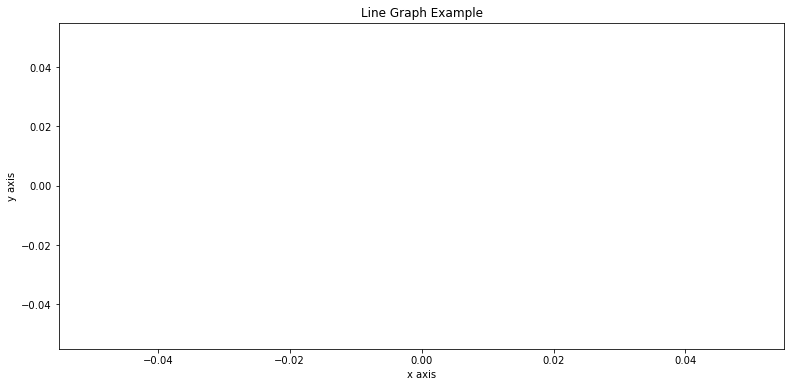

In [ ]:
def ShowV3():
  R = AllReward
  x = []
  s = 0
  for i in range(0,len(R)):
    s = s + R[i]
    x.append(s)
  y = np.arange(0,len(R) ) 
  plt.figure(figsize=(13, 6))
  plt.plot( y, x, label="US30 Line") 
  plt.xlabel("x axis")
  plt.ylabel("y axis")
  plt.title("Line Graph Example")
  plt.show()  # 200
ShowV3()

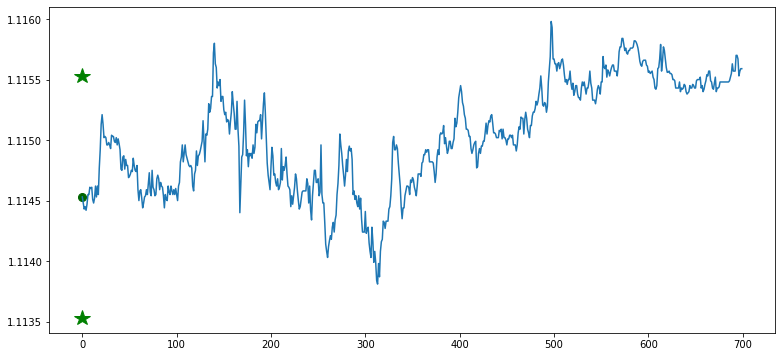

In [ ]:
b = 214022 +5
def showV6(b):  # data is np
  plt.figure(figsize=(13, 6))
  x = data[b:(b+700)]
  y  = np.arange(start=0, stop=len(x) , step=1) 
  price = data[b]
  plt.plot( 0  , price ,  marker='.', markersize=16, color="darkgreen") 
  plt.plot(  0 , price + 0.001 ,  marker='*', markersize=16, color="green") 
  plt.plot(  0 , price - 0.001 ,  marker='*', markersize=16, color="green") 
  plt.plot(  y ,  x    , label="EURUSD Line" )
  plt.show()

showV6(b)